In [1]:
from datasets import load_dataset
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_sequence, PackedSequence, unpack_sequence, pad_sequence
from torch.utils.data import DataLoader, Subset, random_split
from tqdm import tqdm
import torch.optim as optim
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

/home/ofer1992/miniconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset("yhavinga/ccmatrix", "en-de")
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'score', 'translation'],
        num_rows: 247470736
    })
})

In [12]:
len(ds['train'])
val_size = 1000
val = Subset(ds['train'], range(len(ds['train'])-val_size, len(ds['train'])))

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [43]:
import string
from charactertokenizer import CharacterTokenizer

german_unicode_letters = "AÄBCDEFGHIJKLMNOÖPQRSßTUÜVWXYZaäbcdefghijklmnoöpqrsßtuüvwxyz"
print(german_unicode_letters)
chars = set(string.ascii_letters + german_unicode_letters + " ,.!?\"':" + "0123456789") # This is character vocab
model_max_length = 2048
tokenizer = CharacterTokenizer(chars, model_max_length)
# tokenizer.add_special_tokens({'bos_token': '<|beginingoftext|>'})
print(tokenizer.decode(tokenizer("Hello there, how are you?")['input_ids']))

AÄBCDEFGHIJKLMNOÖPQRSßTUÜVWXYZaäbcdefghijklmnoöpqrsßtuüvwxyz
[CLS]Hello there, how are you?[SEP]


In [44]:
chars

{' ',
 '!',
 '"',
 "'",
 ',',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'Ä',
 'Ö',
 'Ü',
 'ß',
 'ä',
 'ö',
 'ü'}

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'bos_token': '<|beginingoftext|>'})

In [45]:
tokenizer.special_tokens_map

{'bos_token': '[BOS]',
 'eos_token': '[SEP]',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

hl = [(d['highlights']) for d in ds['validation']]

len(tokenizer(list(sorted(hl, key=len, reverse=True))[1])['input_ids'])

tokenizer(ds['train'][0]['article'])

## Model

In [46]:
tokenizer.special_tokens_map

{'bos_token': '[BOS]',
 'eos_token': '[SEP]',
 'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [47]:
tokenizer.bos_token_id

2

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = tokenizer.bos_token_id
EOS_token = tokenizer.eos_token_id
MAX_LENGTH = 800

def simple_elementwise_apply(fn, packed_sequence):
    """applies a pointwise function fn to each element in packed_sequence"""
    return torch.nn.utils.rnn.PackedSequence(fn(packed_sequence.data), packed_sequence.batch_sizes)

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        if isinstance(input, PackedSequence):
          embedded = simple_elementwise_apply(lambda x: self.dropout(self.embedding(x)), input)
        else:
          embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden

        if target is not None:
          decoder_outputs = self.forward_teacher(decoder_input, decoder_hidden, target)
          # decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
          decoder_outputs = simple_elementwise_apply(lambda x: F.log_softmax(x, dim=-1), decoder_outputs)
          return decoder_outputs, None, None

        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            # Without teacher forcing: use its own predictions as the next input
            _, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_teacher(self, decoder_input, decoder_hidden, target_packed):
      i = 0
      decoder_outputs = []
      for batch_size in target_packed.batch_sizes:
        # print(batch_size)
        decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
        decoder_outputs.append(decoder_output[:batch_size])
        # decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
        decoder_input = target_packed.data[i:i + batch_size].unsqueeze(-1)
        decoder_hidden = decoder_hidden[:, :batch_size, :]
        # end
        i += batch_size
      decoder_outputs = torch.nn.utils.rnn.PackedSequence(torch.cat(decoder_outputs), target_packed.batch_sizes)
      return decoder_outputs


    def forward_step(self, input, hidden):
        # print(input.shape, hidden.shape)
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden.contiguous())
        output = self.out(output)
        return output, hidden

## Training loop

In [105]:
def decode(log_probs):
  indices = log_probs.topk(k=1, dim=-1).indices.squeeze(-1)
  if len(indices.shape) == 1:
    return tokenizer.decode(indices)
  return [tokenizer.decode(s) for s in indices]

def get_norm(model):
    with torch.no_grad():
        norm = 0
        for p in model.parameters():
          if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            norm += param_norm.item() ** 2
    return norm ** 0.5

In [53]:
hidden_size = 512
lr = 2e-3
num_layers=2
gamma = 0.95

enc = EncoderRNN(len(tokenizer), hidden_size, num_layers, dropout_p=0.5).to(device)
dec = DecoderRNN(hidden_size, len(tokenizer), num_layers).to(device)
enc_optimizer = optim.Adam(enc.parameters(), lr)
dec_optimizer = optim.Adam(dec.parameters(), lr)
enc_scheduler = optim.lr_scheduler.ExponentialLR(enc_optimizer, gamma=gamma)
dec_scheduler = optim.lr_scheduler.ExponentialLR(dec_optimizer, gamma=gamma)
loss_f = nn.NLLLoss()
bs = 128
train_dataloader = DataLoader(ds['train'], batch_size=bs)

50it [00:17,  2.31it/s]

loss=1.2680827379226685


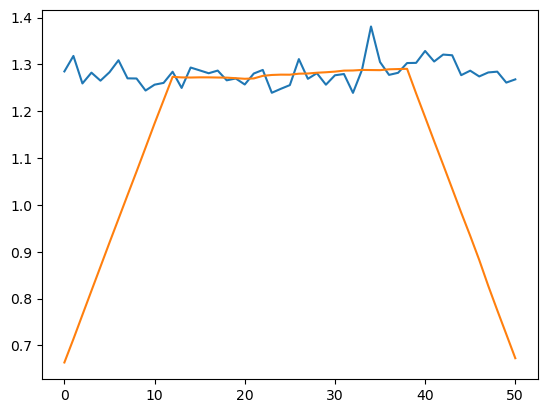

51it [00:17,  2.26it/s]

English:
[CLS]They thought the kingdom would be established in their day [UNK] after only about 4,000 years of God[UNK]s plan had been completed.[SEP]

Target:
[CLS]Sie dachten, daß das Königreich in ihren Tagen gegründet werden würde, nachdem nur etwa 4.000 Jahre von Gottes Plan abgeschlossen worden waren.[SEP]

Predicted:
[CLS]Sie sashten  das dis ginig eich ds dhrer Bag s seseüßdet werden wirden dich em dir diwasd0000 Mahre sen dottes gratedueeschiassen.welden.wer.n.[SEP]
norms: enc=0.060488767016424964    dec=0.3595907322291374


100it [00:33,  4.08it/s]

loss=1.245940089225769


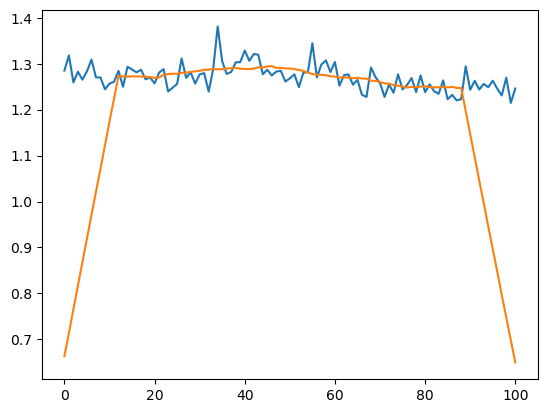

101it [00:33,  3.64it/s]

English:
[CLS]The world today has an attitude, just like Pharaoh's, of rejecting, in their stubbornness and disbelief, all that is Holy.[SEP]

Target:
[CLS]Die Welt heutzutage hat ein Verhalten wie das des Pharaos[UNK] zurückweisend, in ihrer Halsstarrigkeit und im Unglauben allem gegenüber, was Heilig ist.[SEP]

Predicted:
[CLS]Die Aelt wauteutage iab einegersanten uir dis eir Prarao   uu ückgeisen,e wn dhnem Sent aan ekkeit gnd dh JStlauben wuses aebenüber  des eeiligesst.[SEP]
norms: enc=0.061916348950929484    dec=0.28826338289976544


150it [00:45,  4.20it/s]

loss=1.2392973899841309


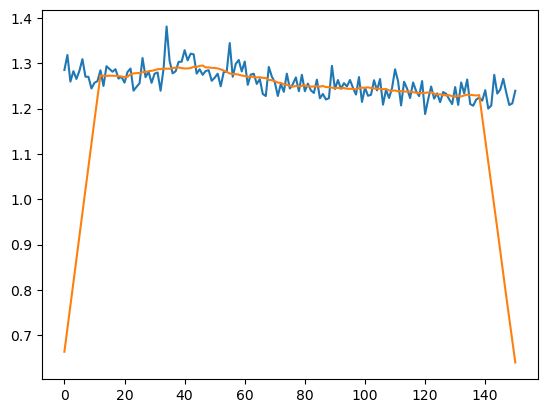

151it [00:46,  3.70it/s]

English:
[CLS]But it is very likely that he MAY fall in love with one of them, and therefore you must visit him as soon as he comes.[UNK][SEP]

Target:
[CLS]Aber es ist höchst wahrscheinlich, dass er sich vielleicht in eine von ihnen verliebt, und daher müssen Sie ihm einen Besuch abstatten, sobald er kommt.[UNK][SEP]

Predicted:
[CLS]Aber ws wst derhst,derrscheinlich  dass ds eich doel eicht wn dinemgol dhnen zerliere, dnd daser wissen wie dhn dinen Mertch zuecattfn. wolald dr sanme.[UNK][SEP]
norms: enc=0.2850032379711613    dec=0.32624000426615063


200it [00:59,  3.46it/s]

loss=1.2132070064544678


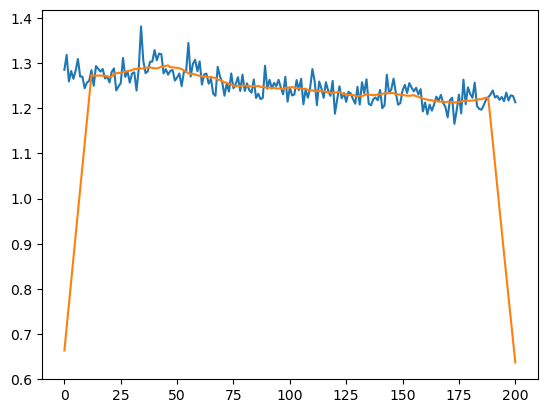

201it [00:59,  3.16it/s]

English:
[CLS]HAHN[UNK] From the many scientific things which my two American collaborators sent me up to 1940, I could see that the Americans were interested in the business.[SEP]

Target:
[CLS]HAHN[UNK] Aus den vielen wissenschaftlichen Dingen, die mir meine zwei amerikanischen Mitarbeiter bis 1940 schickten, konnte ich ersehen, daß die Amerikaner an der Sache interessiert waren.[SEP]

Predicted:
[CLS]HARA[UNK] Ibc dem Moeren Sersen chaftlichen Iiege   die iit iihnerIweitdnerikanischen Bettrbeiter ies z000 iihlekte   dömntenich eifcten, das die Irerikaner iu dem etche is eressaert.wer.n.[SEP]
norms: enc=0.09540307938719803    dec=0.29595489630573507


250it [01:12,  3.98it/s]

loss=1.2062515020370483


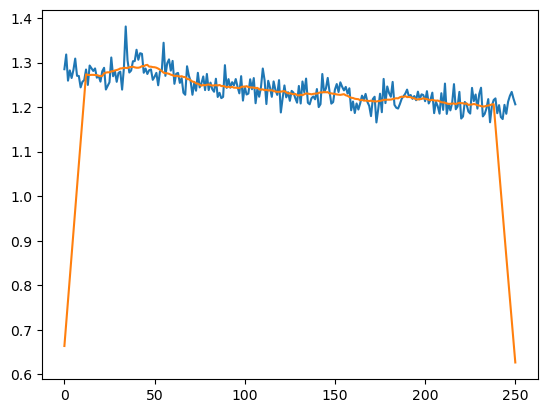

251it [01:12,  3.60it/s]

English:
[CLS]This is the biggest difference between our company and other Chinese suppliers whose parts and service are difficult to get.[SEP]

Target:
[CLS]Dies ist der größte Unterschied zwischen unserem Unternehmen und anderen chinesischen Lieferanten, deren Teile und Service schwer zu bekommen sind.[SEP]

Predicted:
[CLS]Dies ist dir Srößte Sntersthied uuischen dnsere  Bntersehmen und duderen Shinesischen Peeberunten  dir n seil  dns diivice sihrir su sesommen.wind.[SEP]
norms: enc=0.251275752453919    dec=0.32987523657849366


300it [01:25,  3.48it/s]

loss=1.2181710004806519


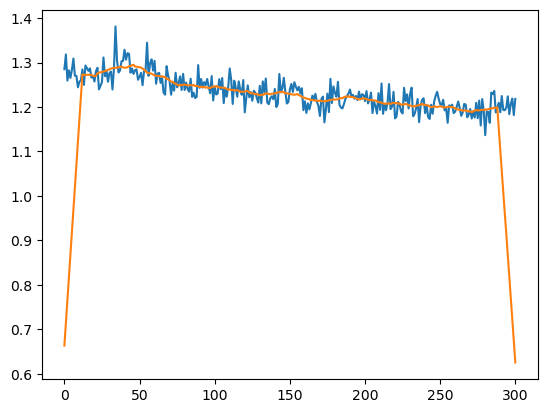

301it [01:25,  2.84it/s]

English:
[CLS]The trilogue on the Commission's proposal for a Decision on the mobilisation of the EGF could take a simplified form, as provided for in Article 12[UNK]5[UNK] of the legal base, unless there is no agreement between the Parliament and the Council.[SEP]

Target:
[CLS]Der Trilog über den Vorschlag der Kommission für einen Beschluss über die Inanspruchnahme des EGF könnte in vereinfachter Form erfolgen, wie dies in Artikel 12 Absatz 5 der Rechtsgrundlage vorgesehen ist, es sei denn, zwischen Parlament und Rat kommt es zu keiner Einigung.[SEP]

Predicted:
[CLS]Dir Haatlsisber dir Selschläg der Eonmission [UNK]ür dine  aesthruss dber die Entlztrocheihme der HUF [UNK]onntendh dirsinbache n [UNK]rrd disolgrn  dae die een dlgikel d9 Jbeitz d0[UNK]er Eeghts eund ege son eschen wst. ds iiitdern  dueschen dartament [UNK]nd detedommt.wr au soine  Srnsgeng [SEP]
norms: enc=0.2543428666610104    dec=0.3669724924189502


350it [01:39,  3.68it/s]

loss=1.1670531034469604


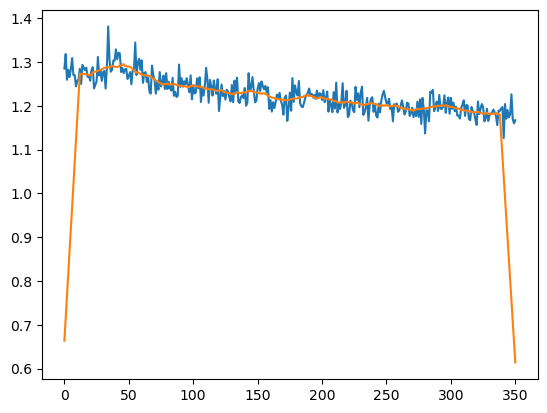

351it [01:39,  3.42it/s]

English:
[CLS]You can be sure that Dr. Ezzeldin and our capable staff will not stop until we have solved the secrets of your pain.[SEP]

Target:
[CLS]Sie können sicher sein, dass Dr. Ezzeldin und unsere fähigen Mitarbeiter nicht aufhören werden, bis wir die Geheimnisse Ihrer Schmerzen gelöst haben.[SEP]

Predicted:
[CLS]Sie können aich rluein, dass due Mreenl sgund dnsere Erhigk  ualgrbeiter uicht wuf ören,wirden, des dir uie Eeseimnisse dhre  Sthuerzen uesest waben.[SEP]
norms: enc=0.06990564028015515    dec=0.27025062548075296


400it [01:53,  3.57it/s]

loss=1.1864330768585205


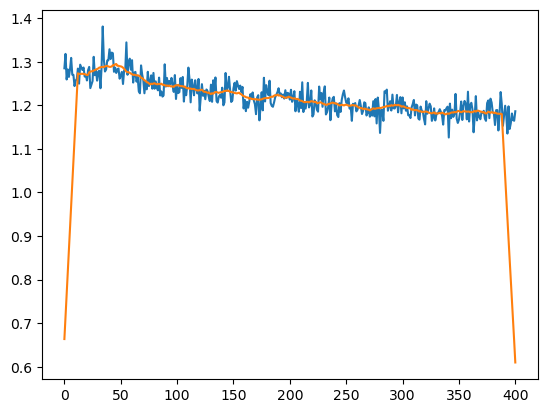

401it [01:53,  3.19it/s]

English:
[CLS]It's also about enabling a real[UNK]time conversation, talking about where [UNK]the Kate Spade girl[UNK] is now and where she goes next.[SEP]

Target:
[CLS]Es geht auch darum, eine Echtzeit[UNK]Konversation zu ermöglichen, darüber zu reden, wo [UNK]das Kate Spade[UNK]Mädchen[UNK] jetzt ist und wohin sie als nächstes geht.[SEP]

Predicted:
[CLS]Es iiht euch eesam  dine srhteeit  omtersition [UNK]u eiwuglichen, uasuber iu eeden  ue e is iiteg[UNK]erni  irchen  ietzt ist ens eilln sin iul eechste  Jese.[SEP]
norms: enc=0.08407362479463935    dec=0.3090892394705925


450it [02:07,  3.86it/s]

loss=1.1866543292999268


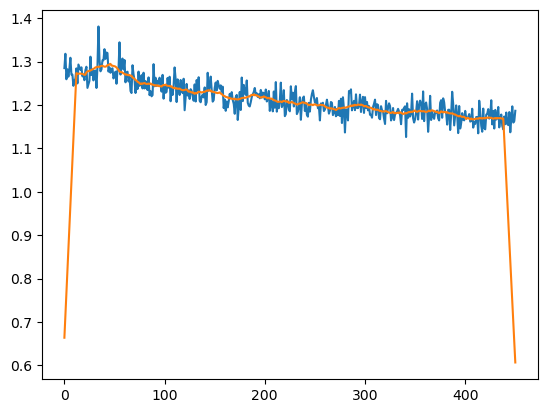

451it [02:07,  3.65it/s]

English:
[CLS]I waited because a friend of mine told me that the 488 [UNK]the model I have now[UNK] was coming out in a few months.[SEP]

Target:
[CLS]Ich habe gewartet, weil ein freund mir erzählte, dass die 488 [UNK]das modell, das ich jetzt habe[UNK] in ein paar monaten herauskam.[SEP]

Predicted:
[CLS]Ich wabe meseltet, dinl isneBüeind wit nisählt   dass die I   i is iinerl  was ich wetzt haben [UNK]c dinewaar Jenate  haiaus oue[SEP]
norms: enc=0.20923509763141987    dec=0.3087693318608579


500it [02:21,  3.41it/s]

loss=1.14565110206604


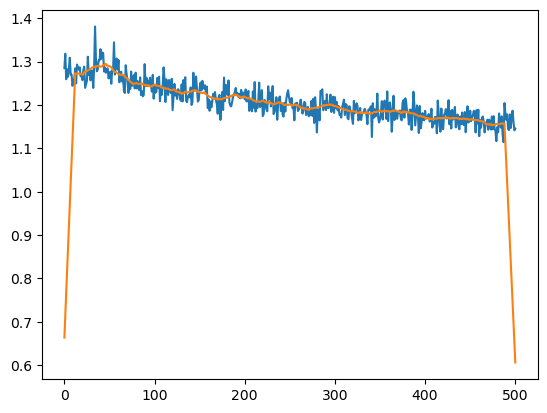

501it [02:21,  3.16it/s]

English:
[CLS]All parents should know that from January 1, 1993 new criteria recommended by the World Health Organization were adopted in our country.[SEP]

Target:
[CLS]Alle Eltern sollten wissen, dass ab dem 1. Januar 1993 neue Kriterien, die von der Weltgesundheitsorganisation empfohlen wurden, in unserem Land verabschiedet wurden.[SEP]

Predicted:
[CLS]Alle 1ntern dillten wirsen, dass dle1er 19 Juhuar 2994 siue Soitirien  die don den Eelt escndheit wrganisation zipfehlen werden. dn dnseren Send zorlnschieden wurden.[SEP]
norms: enc=0.16006937765175702    dec=0.30950354569922467


550it [02:35,  3.33it/s]

loss=1.1782478094100952


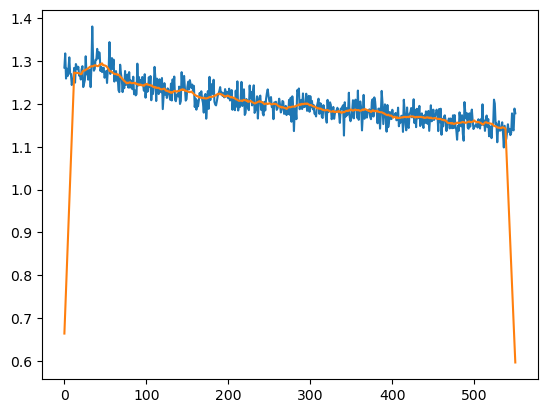

551it [02:36,  2.85it/s]

English:
[CLS]If you've told yourself 10,000 times throughout your life that you're an idiot, then you need to tell yourself 10,001 times [UNK]or more[UNK] that you are an intelligent child of God.[SEP]

Target:
[CLS]Wenn du dir 10,000 mal in deinem Leben gesagt hast, dass du ein Idiot bist, dann musst du dir 10,001 mal [UNK]oder mehr[UNK] sagen, dass du ein intelligentes Kind Gottes bist.[SEP]

Predicted:
[CLS]Wenn di die d0  00 Mac dn derner Taben descgt habt, dass di dinepneotedest  dasn dasst du die d0  00 Mac d der dehr  sigtn  dass di dinepsterligentertSondezottes.ees.[SEP]
norms: enc=0.2437554213766294    dec=0.32132803129296894


600it [02:50,  3.63it/s]

loss=1.121621012687683


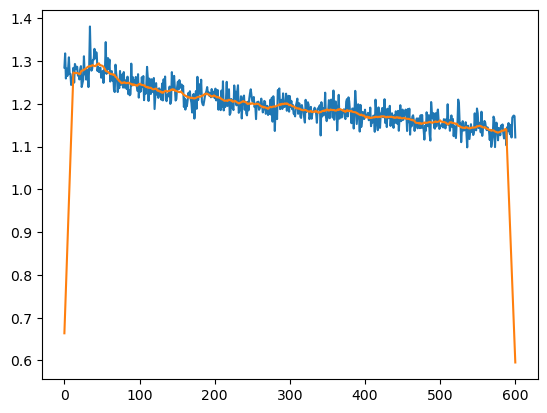

601it [02:50,  3.17it/s]

English:
[CLS]He still uses so much of this symbolic language [UNK] but if you are doing an article on Afro[UNK]Cuban art you wouldn[UNK]t necessarily include him.[SEP]

Target:
[CLS]Er benutzt immer noch so viel von dieser symbolischen Sprache [UNK] aber wenn Sie einen Artikel über afro[UNK]kubanische Kunst machen, würden Sie ihn nicht notwendigerweise einschließen.[SEP]

Predicted:
[CLS]Er segutzt dh er noch ee viel mon deeser Scsbilischen Sciachen[UNK] eber einn Sie eine  gub kel dber dlrisalla ische Soldt dichen. warde  Sie enr gicht gucwendig r eise grnechließln.[SEP]
norms: enc=0.21534839123615807    dec=0.31580659531881344


650it [03:04,  3.99it/s]

loss=1.1419814825057983


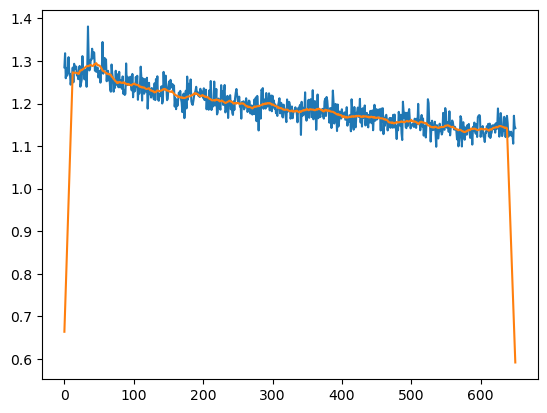

651it [03:05,  3.48it/s]

English:
[CLS]Did the search for equality between men and women in countries like the United States influence the decision to have the same retirement age for both?[SEP]

Target:
[CLS]Hat die Suche nach der Gleichstellung von Männern und Frauen in Ländern wie den Vereinigten Staaten Einfluss auf die Entscheidung, für beide das gleiche Rentenalter zu haben?[SEP]

Predicted:
[CLS]Hat diesWcbhe dich der Eeaichetenlung uon dinner  und diagen in dinder  uir dir Wersinigten Staaten unnhluss dnf die WUtwcheidunge dür dei e dis weeiche Wegnr  rier wu baben?[SEP]
norms: enc=0.206036406893005    dec=0.2760906183442207


700it [03:19,  3.36it/s]

loss=1.1193721294403076


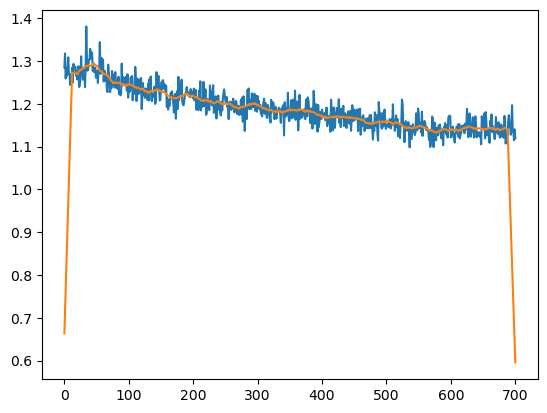

701it [03:19,  2.88it/s]

English:
[CLS]stresses the need to develop a cohesive European migration policy and therefore welcomes the adoption on 15 October 2008 of the European Pact on Immigration and Asylum[UNK][SEP]

Target:
[CLS]unterstreicht die Notwendigkeit der Entwicklung einer kohärenten europäischen Einwanderungspolitik und begrüßt daher die Verabschiedung des Europäischen Paktes zu Einwanderung und Asyl am 15. Oktober 2008[UNK][SEP]

Predicted:
[CLS]Dnderstüeiche die Iatwendigkeit der Iutwicklung dines dlmlden e  Suropäischen Irnwanderung politik und desient deser dee Ierenschufdsng des Iuropaischen Irreon [UNK]u duneanderungednd IuileIu 29. Jktober 2018[UNK][SEP]
norms: enc=0.09905022666625599    dec=0.30162911551975624


750it [03:34,  3.37it/s]

loss=1.135115385055542


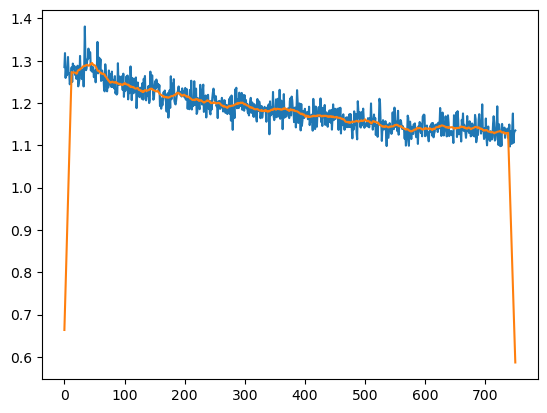

751it [03:34,  3.12it/s]

English:
[CLS][UNK]But now, we want babies who are sent home within 48 hours of birth to be seen again within three days.[SEP]

Target:
[CLS]"Aber jetzt wollen wir, dass Babys, die innerhalb von 48 Stunden nach der Geburt nach Hause geschickt werden, innerhalb von drei Tagen wieder gesehen werden.[SEP]

Predicted:
[CLS][UNK]Aber wedzt willtn wir  dass eenys  wie nn erhalb von 1  Jtunden wich dem gesirtegich dause besthaekt werden. ws erhalb von ieei Jagen zirder zesthen.herden.[SEP]
norms: enc=0.2209138511455666    dec=0.28969405729147


800it [03:48,  3.58it/s]

loss=1.103037714958191


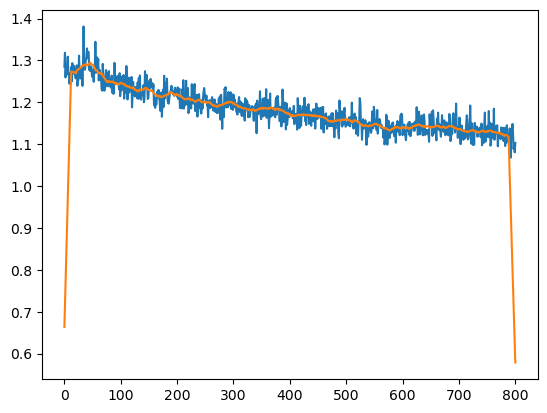

801it [03:49,  3.25it/s]

English:
[CLS]Please tell us what significant changes have occurred in this last decade in this beautiful region and please describe the beautiful Tulum.[UNK][SEP]

Target:
[CLS]Erzählen Sie uns bitte, welche wesentlichen Veränderungen sich in diesem letzten Jahrzehnt in dieser schönen Region ereignet haben, und beschreiben Sie das schöne Tulum.[UNK][SEP]

Predicted:
[CLS]Biwählen uie sns desten denche Aintntliche  Eersnderungen iinh an deesem Letzten Jahr ehntedn deesem Wchlnen uegien inhignetewaten. und desthliibtn wie dis gchlne Srres.[UNK][SEP]
norms: enc=0.2107228059910407    dec=0.2786339071158031


850it [04:03,  3.55it/s]

loss=1.177482008934021


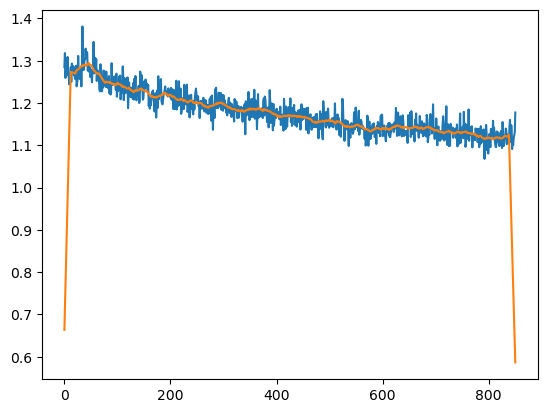

851it [04:03,  3.21it/s]

English:
[CLS]However, I think it speaks volumes of the state of our economy and the state of our health insurance programs that 9 million kids are currently on it.[SEP]

Target:
[CLS]Aber ich denke, es spricht Bände über den Zustand unserer Wirtschaft und den Zustand unserer Krankenversicherungsprogramme, auf denen sich derzeit 9 Millionen Kinder befinden.[SEP]

Predicted:
[CLS]Aler dch henke, ds iiäicht deugeruber din eusaand undere  Gertschaft und din eugaand dndere  Goifkhnherticherung poozramme  dlf dem n dieh din eit d Millionen Monder zesinden.[SEP]
norms: enc=0.12885903977989527    dec=0.27913685814521694


900it [04:18,  3.50it/s]

loss=1.0946736335754395


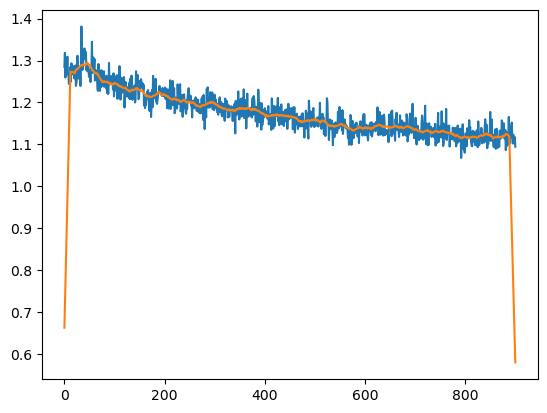

901it [04:19,  3.17it/s]

English:
[CLS]COBRA [UNK] Actually there are many countries that are still in the medieval times if we speak about the development of the society and many of those countries are quite wealthy.[SEP]

Target:
[CLS]COBRA [UNK] Tatsächlich gibt es viele Länder, die sich noch im Mittelalter befinden, wenn wir über die Entwicklung der Gesellschaft sprechen und viele dieser Länder sind recht wohlhabend.[SEP]

Predicted:
[CLS]COBRA [UNK] Jrgsächlich wibt es eiele vender  die dich aich nnmJatgel nter uegrnden, uenn sir dber die Krtsicklung der Wescllschaft uirechen wnd deele veeser Wender wind wecht wern eben.e[SEP]
norms: enc=0.10799363773306099    dec=0.24413688605565842


950it [04:33,  3.21it/s]

loss=1.0922412872314453


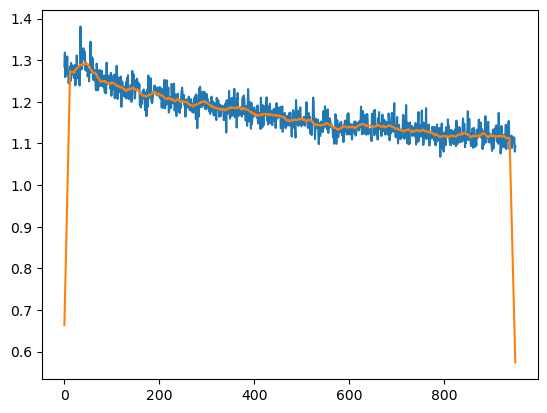

951it [04:33,  3.05it/s]

English:
[CLS]They make up a minuscule percentage of their Somali[UNK]American community, and it is unclear whether their transformation reflects any broader trend.[SEP]

Target:
[CLS]Sie machen einen winzigen prozentsatz ihrer somalisch[UNK]amerikanischen gemeinschaft aus, und es ist unklar, ob ihre transformation einen breiteren trend widerspiegelt.[SEP]

Predicted:
[CLS]Sie küchtn dine  Berdigen Boifest atz dnrer eclmlisihe nerikanischen urseinsahaft uuf  dnd ds wst dnslari db dhr  eeagspormition dine  geiitenen Baaunezirerstreleln.[SEP]
norms: enc=0.2659907402991605    dec=0.3177658233847857


1000it [04:48,  3.05it/s]

loss=1.0838079452514648


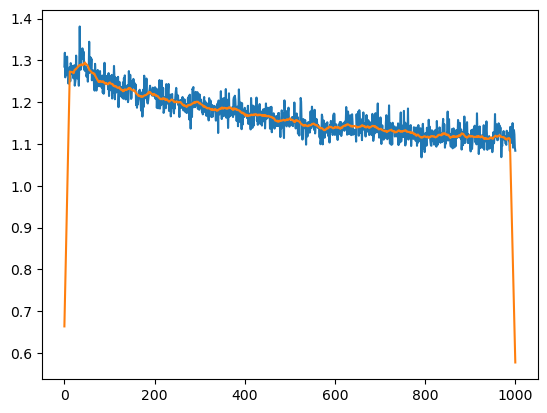

1001it [04:49,  2.92it/s]

English:
[CLS]It's easy to see why many American slaves would have been on the side of the British[UNK] They didn't like being fucking slaves.[SEP]

Target:
[CLS]Es ist leicht zu sehen, warum viele amerikanische Sklaven auf der Seite der Briten gewesen wären[UNK] Sie haben es nicht gefallen, verdammte Sklaven zu sein.[SEP]

Predicted:
[CLS]Es ist weicht zu seien, wasum siele Mnerikanische Mtlave  zuf den Wcite der Weüte  sesesen here,, [UNK]ie waben ei sicht mesullen, dersimmt  Milave  zu sein.[SEP]
norms: enc=0.16879945575420127    dec=0.27295836846175064


1050it [05:03,  3.37it/s]

loss=1.085929036140442


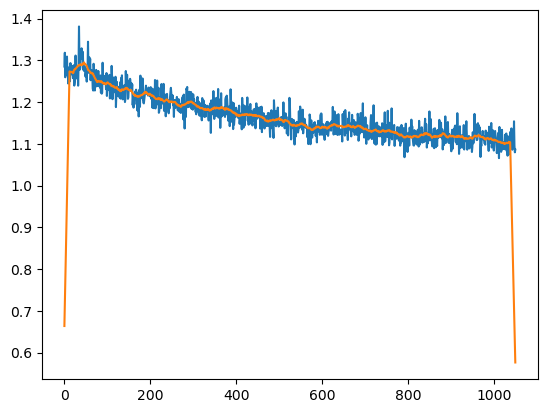

1051it [05:04,  2.95it/s]

English:
[CLS]He stressed the great need for a European platform for tactical medicine and was pleased that this has now been successful for several years.[SEP]

Target:
[CLS]Er betonte die große Notwendigkeit einer europäischen Plattform für die taktische Medizin und freute sich, dass dies nun seit einigen Jahren gelungen sei.[SEP]

Predicted:
[CLS]Er sesrnt  die Mloße Marwendigkeit uine  diropäischen Srantform dür die eattivche uenikin und düain  uich  dass die eeir eehn dinegen Mahren vesengen wiin[SEP]
norms: enc=0.24993270647648758    dec=0.29625425563863816


1100it [05:18,  3.46it/s]

loss=1.0760409832000732


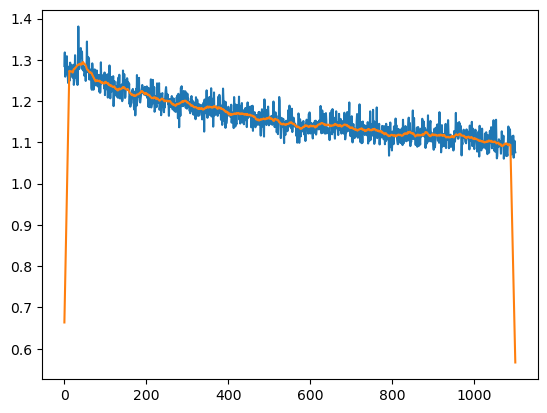

1101it [05:19,  2.99it/s]

English:
[CLS]It is also flexible enough to allow countries to pursue national drug policies according to their priorities and needs [UNK] as I did when I was Prime Minister of Portugal.[SEP]

Target:
[CLS]Es ist auch flexibel genug, um Ländern zu erlauben, ihre nationale Drogenpolitik entsprechend ihrer eigenen Prioritäten und Erfordernisse fortzusetzen [UNK] so wie ich es tat, als ich Premierminister von Portugal war.[SEP]

Predicted:
[CLS]Es ist alch wüexibel uenag  un dender  zu vrweuben, dnre Aecionale ueogen rlitik urtfcrechend unre  Pigenen uronrität n und drfolmeru sse [UNK]ürtzuettzen,[UNK] ui wie dch ms nuts wls dch zromierminister uen Mrrtrgal zire[SEP]
norms: enc=0.08279415666852435    dec=0.2529665081127133


1150it [05:34,  3.20it/s]

loss=1.0743869543075562


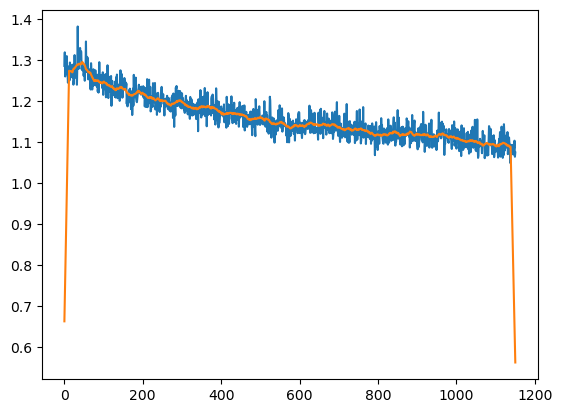

1151it [05:35,  2.98it/s]

English:
[CLS]Firstly, as Georgia[UNK]s experience demonstrates, efforts to fight corruption are most effective if done in the very first years after a revolution.[SEP]

Target:
[CLS]Erstens, wie Georgiens Erfahrung zeigt, sind die Bemühungen zur Bekämpfung der Korruption am effektivsten, wenn sie in den ersten Jahren nach einer Revolution getan werden.[SEP]

Predicted:
[CLS]Frstens  eee eesrgeen tirfohrung iuigt  dond die eedühungen eu  Veiampfung der eomreption eu mifektiveten  denn eie en eer ersten Mahren eich einem eeiolution iesan herden.[SEP]
norms: enc=0.210485899693101    dec=0.26533543826773226


1200it [05:50,  3.01it/s]

loss=1.0792022943496704


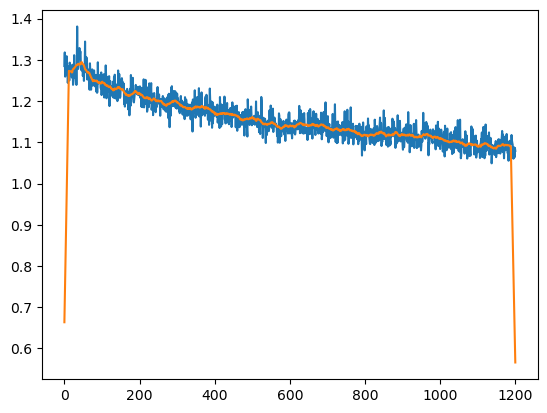

1201it [05:50,  2.82it/s]

English:
[CLS]But at the same time, of course, it[UNK]s true that the lower middle class, whether it[UNK]s in Mannheim or Michigan, hasn[UNK]t gotten very much in the last 20 years.[UNK][SEP]

Target:
[CLS]Aber gleichzeitig ist es natürlich wahr, dass die untere Mittelklasse, ob es jetzt in Mannheim oder Michigan ist, nicht besonders viel abgekriegt hat in den letzten 20 Jahren".[SEP]

Predicted:
[CLS]Aber eeeichzeitig ist,ds mitürlich,mihr, dass die MntersnMetgel oasse  db ds medzt mn dora aim mder mechaaatgmmt, wacht mestnders woel mngesoiegt mat,[UNK]s der Jetzten J0 Jahren..[SEP]
norms: enc=0.17486133768603648    dec=0.24250176936936044


1250it [06:06,  3.02it/s]

loss=1.0546350479125977


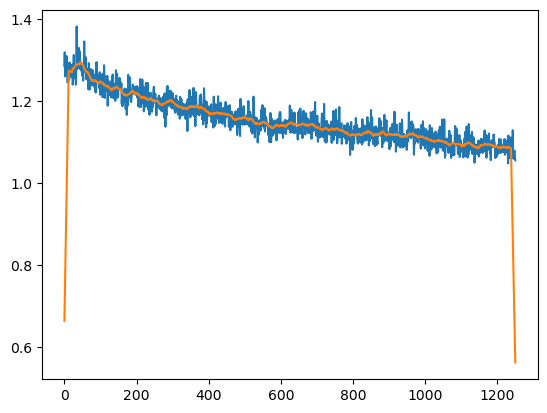

1251it [06:07,  2.72it/s]

English:
[CLS]Furthermore, the maintenance of Strasbourg[UNK]s European infrastructures amounts to more or less 30 million euros per year, not counting the full reconstruction of certain buildings.[SEP]

Target:
[CLS]Darüber hinaus beläuft sich der Unterhalt der europäischen Infrastrukturen in Straßburg auf mehr oder weniger 30 Millionen Euro pro Jahr, ohne den vollständigen Wiederaufbau bestimmter Gebäude.[SEP]

Predicted:
[CLS]Darüber hinaus degauft dich dir Sntersaltuder Auropäischen Unsoastruktur l in daaaßeurg duf dehr ader deniger a00Jillionen vuropirodJahr  ddne dir Sellständigen Serderausbauezeitemmt.n aesuude.[SEP]
norms: enc=0.2529618275785695    dec=0.26926351624852873


1300it [06:23,  3.23it/s]

loss=1.0225193500518799


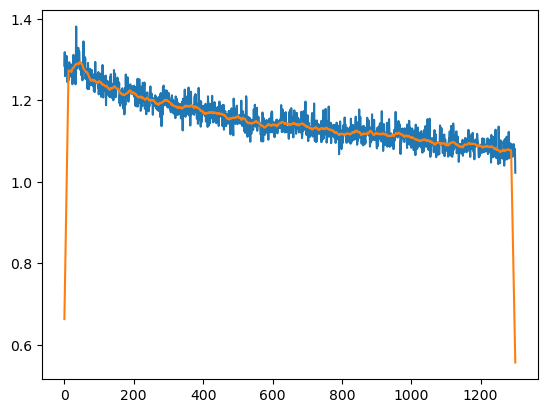

1301it [06:24,  2.81it/s]

English:
[CLS]However, the countries which sponsored the UNHRC 30[UNK]1 Resolution in 2015 shoulder an unexcusable and indispensable obligation and duty to ensure the implementation of this Resolution.[SEP]

Target:
[CLS]Die Länder, die die Resolution 30[UNK]1 des UNHRC im Jahr 2015 unterstützt haben, schultern jedoch eine unverzeihliche und unverzichtbare Verpflichtung und Pflicht, die Umsetzung dieser Resolution sicherzustellen.[SEP]

Predicted:
[CLS]AiesWender  die die Eegtlution d   0iir SSSA  is Jahr 2000 ender tützt uaben, uohrlder  uedoch dine snderäeiceich  Snd dntersechteare Serbflichtungednd drlicht  die dSsttzung deeser Segtlution ienh r ustellen.[SEP]
norms: enc=0.10794373732633088    dec=0.264479957829596


1350it [06:40,  3.09it/s]

loss=1.0464597940444946


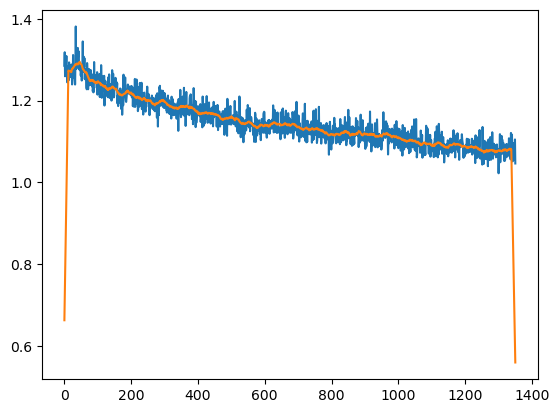

1351it [06:40,  2.66it/s]

English:
[CLS]Public recognition would have been needed also much sooner after the war to avoid the social stigma that had such devastating effects on women![SEP]

Target:
[CLS]Und auch öffentliche Anerkennung wäre viel früher nach dem Krieg nötig gewesen, um das soziale Stigma zu vermeiden, welches so zerstörerische Auswirkungen auf die Frauen hatte![SEP]

Predicted:
[CLS]Png wlch wffnntlich  Argrkennung direndoellsüeher aath der gaieg gitig,gegosen, dm dis Le iale Stameatzu serleiden, werches de wuistörtn sch  Srswirkungen zuf dee grag n zatte![SEP]
norms: enc=0.1419875889807304    dec=0.22432529347233235


1400it [06:57,  2.78it/s]

loss=1.061792254447937


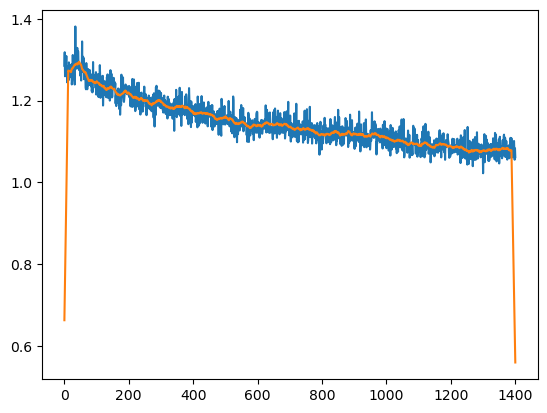

1401it [06:58,  2.51it/s]

English:
[CLS]"I believe that the European elections are a very important moment for Europe, because it gives us a chance to improve things or change them in some way.[SEP]

Target:
[CLS]"Ich meine, dass die Europawahlen ein sehr wichtiger Moment für Europa sind, weil wir dadurch die Möglichkeit haben, Dinge zu verbessern oder irgendwie zu verändern.[SEP]

Predicted:
[CLS]"Ich böine  dass die Europäsarl   einepohr wichtiger Sanent iür duropa iend, weil eir eisurch iie eeglichkeit iaben, iiege zu eersessern.wder ingendwie iu eersndern.[SEP]
norms: enc=0.350092541804526    dec=0.29087463537251


1450it [07:15,  2.57it/s]

loss=1.0795601606369019


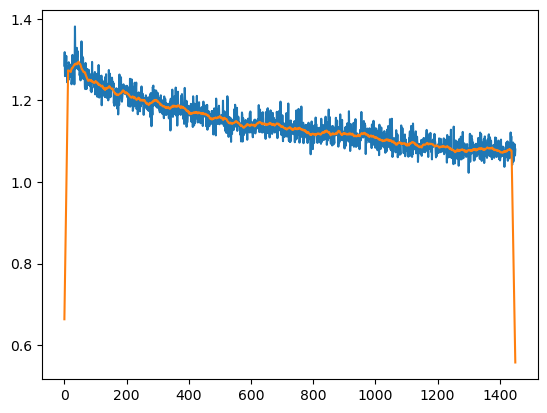

1451it [07:15,  2.33it/s]

English:
[CLS]It could only have been the murderer, since neither the gardener nor anyone else had been there that morning and the rain had only begun during the night."[SEP]

Target:
[CLS]Es konnte nur der Mörder gewesen sein, weil weder der Gärtner noch sonst jemand an diesem Vormittag dort gewesen war, und der Regen erst während der Nacht begonnen hatte.[UNK][SEP]

Predicted:
[CLS]Es kannte nir dar Megder dehesen hein, denl diner der Gest ir dich ne st getald gu dee e  Tersatteg zert gehesen hure und dar Begil grrc gerrend der Gacht gesinnen hat.e.[UNK][SEP]
norms: enc=0.3178347700482834    dec=0.2669907491599504


1500it [07:33,  3.02it/s]

loss=1.0329500436782837


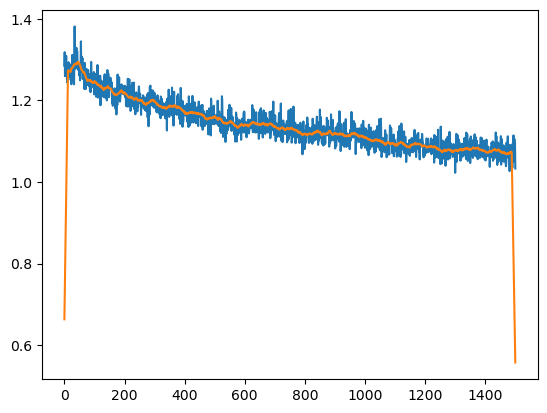

1501it [07:33,  2.87it/s]

English:
[CLS]Firstly, the framework for promoting sustainable investment should not be limited to those investors who already want to do something good for our planet.[SEP]

Target:
[CLS]Erstens, sollte sich das Rahmenwerk zur Förderung nachhaltiger Investitionen nicht auf diejenigen Investoren beschränken, die bereits etwas Gutes für unseren Planeten tun wollen.[SEP]

Predicted:
[CLS]Erstens  dinlte dieh dis netmen eik au  Vrdderung iich altig r ansestitionsn iicht wnf dee enigen,wnsestiren iesthäenktn, wie weseits vrwas wetes vür uns re  Praneten gun.willen.[SEP]
norms: enc=0.16929130193648884    dec=0.24306911834834377


1550it [07:50,  3.01it/s]

loss=1.0860220193862915


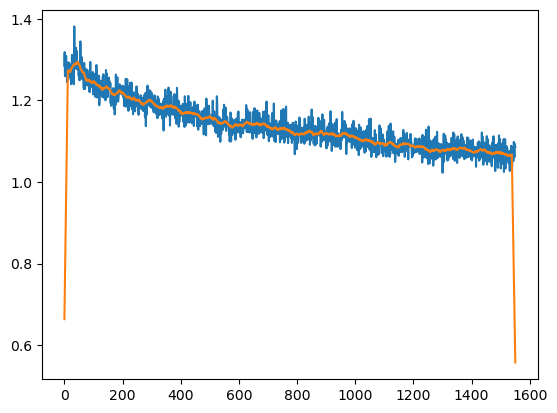

1551it [07:50,  2.68it/s]

English:
[CLS]We don't know if SCP[UNK]2959 represents an attempt to change the focus of the Foundation or if it's something using our resources for their own experiments, but the why doesn't matter.[SEP]

Target:
[CLS]Wir wissen nicht, ob SCP[UNK]2959 einen Versuch den Fokus der Foundation zu ändern darstellt, oder ob es etwas ist, das unsere Ressourcen für seine eigenen Experimente benutzt, doch das Warum ist unwichtig.[SEP]

Predicted:
[CLS]Wir wessen,nicht, db diO  0   iine  sersucheder Uarus ier Earndation iu sndern,wiratelle, wber wb ds iiwas ast, dasswnsere Eegsourcen iür diine eigenen Wiperimente gesötzt. wich wis wasum est nnsarhtige[SEP]
norms: enc=0.25776578969264646    dec=0.289764799481408


1600it [08:07,  2.83it/s]

loss=1.0800353288650513


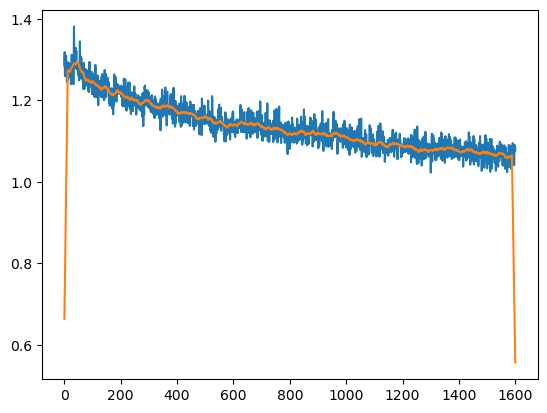

1601it [08:08,  2.62it/s]

English:
[CLS]I hope that Austrian research policy recognizes this potential and promotes these young people as sustainably as it has done so far."[SEP]

Target:
[CLS]Ich hoffe, dass die österreichische Forschungspolitik dieses Potential erkennt und diese jungen Menschen ebenso nachhaltig fördert, wie dies bisher geschehen ist.[UNK][SEP]

Predicted:
[CLS]Ich hoffe  dass die Lfterreichische urrmchung prlitik diese  Prtenzial uislnnt hnd dae e Pungen Menschen irenfo dich altigeiürdern  dee die edes er aeschahen hst.[UNK][SEP]
norms: enc=0.20075968510649697    dec=0.2628879696802666


1650it [08:25,  3.02it/s]

loss=1.0576130151748657


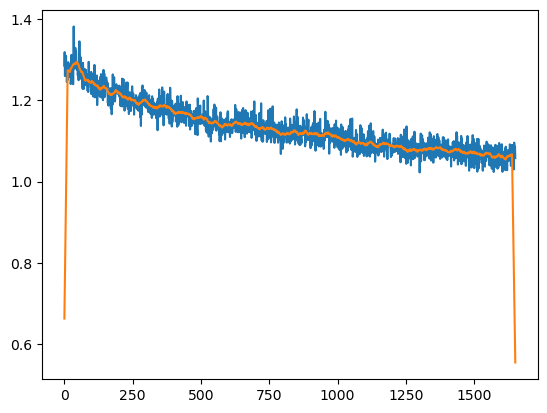

1651it [08:26,  2.64it/s]

English:
[CLS]Second, given this difficulty with predicting participation, I[UNK]d like to remind you that creating a mass collaboration project can be risky.[SEP]

Target:
[CLS]Zweitens, angesichts dieser Schwierigkeit bei der Vorhersage von Partizipation möchte ich Sie daran erinnern, dass die Erstellung eines Massenkollaborationsprojekts riskant sein kann.[SEP]

Predicted:
[CLS]Zweitens, db esichts dieses Athweerigkeit zei mer Eersersagenion eartnninileen wichte ich eie earau eilnnern, dass eie mifte lung eine  Tances unoererbtions rogekt  zeckint wiin wönn.[SEP]
norms: enc=0.16549156905890064    dec=0.25987598614284824


1700it [08:43,  2.75it/s]

loss=1.0373810529708862


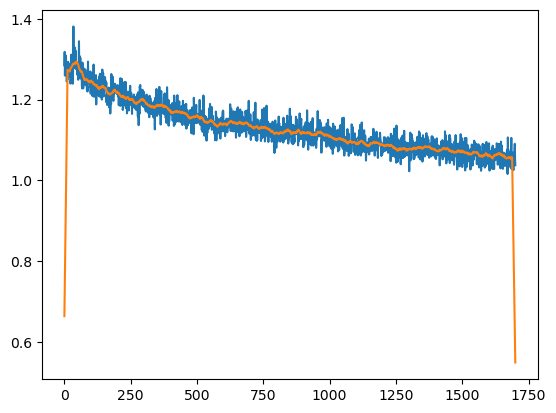

1701it [08:43,  2.42it/s]

English:
[CLS]This potential is on the radar screen of your immediate future so strongly that we even want to give you their names, but we cannot, for it could be one of 18 people.[SEP]

Target:
[CLS]Dieses Potenzial ist auf dem Radarschirm deiner unmittelbaren Zukunft so stark, dass wir ihnen sogar ihre Namen geben wollen, aber wir können nicht, denn es könnte einer von 18 Menschen sein.[SEP]

Predicted:
[CLS]Dies   Prtenzial ist euc dem 1eti, hufm,werner Snsöttelbare  Zekunft ve weark  wass wir emr n ni ar nnre 1acen vesen wollen, wber wir wönnen sicht  wann ds wönnte isne  1on 15 Jetschen eihn.[SEP]
norms: enc=0.14116284023617487    dec=0.25016714686407676


1750it [09:01,  2.96it/s]

loss=1.0398478507995605


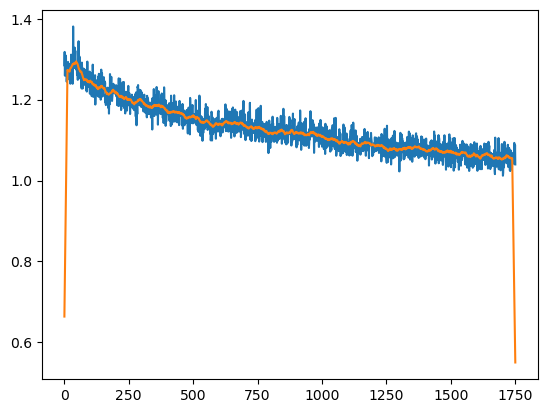

1751it [09:01,  2.64it/s]

English:
[CLS]One thing is sure[UNK] there is already a lot of bad blood, and there will be serious political consequences if the evidence in Turkey against Saudi Arabia increases.[SEP]

Target:
[CLS]Eines ist aber sicher[UNK] es hat jetzt schon viel böses Blut gegeben und es wird schwere politische Konsequenzen geben, wenn sich die Beweise gegen Saudi[UNK]Arabien in der Türkei mehren.[SEP]

Predicted:
[CLS]Eine  dst duer aecherl Ds gat eedzt eehln eoelevese  ueut uegenen und di iird eihlii  Arlitische Aonfequenzen aesen, denn dieh die Aedegse iesen ditdi[UNK]Arabeen sn der Larkei sahr r [SEP]
norms: enc=0.06626370213126948    dec=0.22641386335309466


1800it [09:18,  2.78it/s]

loss=1.0605005025863647


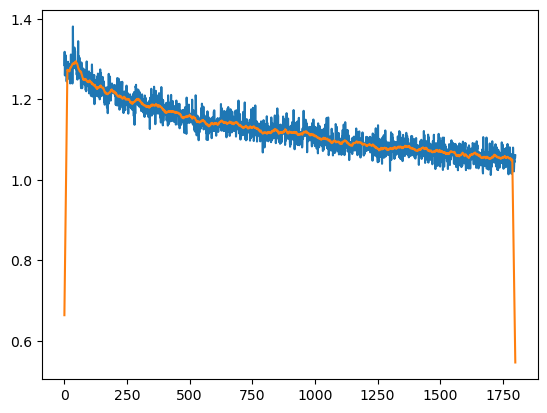

1801it [09:19,  2.57it/s]

English:
[CLS]However, now we tell you that the real timeframe of this entire Human test of energy [UNK]light and dark[UNK] was two cycles [UNK] 52,000 years, not one cycle of 26,000 years.[SEP]

Target:
[CLS]Aber jetzt sagen wir euch, dass der wirkliche Zeitrahmen dieser gesamten menschlichen Energieprüfung [UNK]Licht und Dunkelheit[UNK] zwei Zyklen war [UNK] 52.000 Jahre, nicht ein Zyklus von 26.000 Jahren.[SEP]

Predicted:
[CLS]Dler netzt hagtn wir dich  dass dir Micklich  Neit aumen dee e  Mesamten Nenschlichen Srtrgie rofung n aeht und Nerkelheim  [UNK]uii Jeklun niren 100000 Mahren nicht dinegiplus zon d00000 Jahren.[SEP]
norms: enc=0.1636884697055385    dec=0.22411812247997634


1850it [09:36,  2.71it/s]

loss=1.0766950845718384


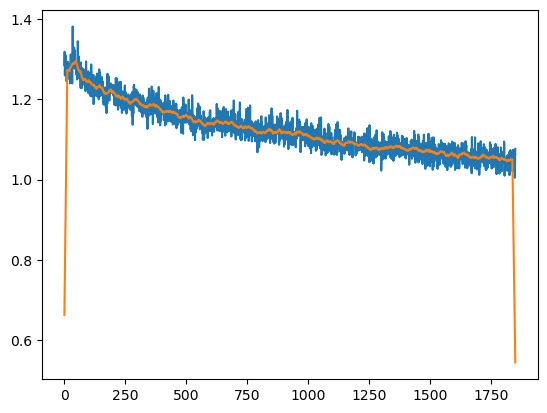

1851it [09:37,  2.18it/s]

English:
[CLS]Notes that in addition to the 551 redundancies within the reference period, 49 workers dismissed before the reference period of four months are also included in the number of eligible beneficiaries, which amounts in total to 600 persons[UNK] notes that 89,17 [UNK] of the redundant workers eligible for EGF support are women.[SEP]

Target:
[CLS]8. stellt fest, dass zusätzlich zu den im Bezugszeitraum entlassenen 551 Arbeitnehmern auch 49 vor dem viermonatigen Bezugszeitraum entlassene Arbeitnehmer in die Zahl der förderfähigen Begünstigten einbezogen werden, die sich auf insgesamt 600 Personen beläuft[UNK] stellt des Weiteren fest, dass 89,17 [UNK] der entlassenen Arbeitnehmer, die für eine Unterstützung aus dem EGF in Betracht kommen, Frauen sind[UNK][SEP]

Predicted:
[CLS]N. Diehlt düst, dass du ätzlichezu den Pn Jerig  eiteaum vrtwansen,  P0[UNK] Prteitsehmer  aufh a0 Pen der Peertaritisen Perig  eit aum drtwansen, Pnbeitsehmer an deesguhl der Prrderuahrgen Pehrnstiguen 

1900it [09:53,  2.88it/s]

loss=1.061572790145874


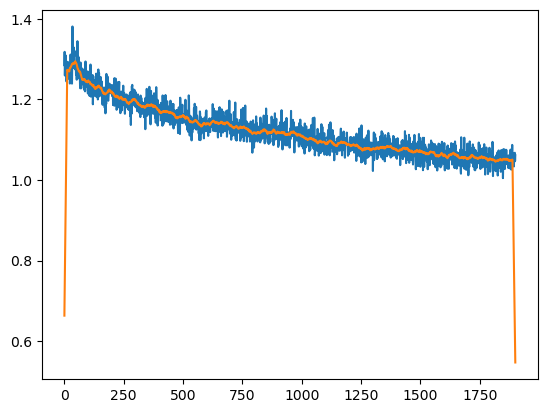

1901it [09:54,  2.50it/s]

English:
[CLS]The final report of the European Parliament Legal Affairs Committee [UNK]JURI[UNK] of 25 September 2012 however seems to indicate that there is a gap between the views in the European Parliament and the Council.[SEP]

Target:
[CLS]Der abschließende Bericht des Rechtsausschusses JURI des Europäischen Parlaments vom 25. September 2012 scheint jedoch darauf hinzuweisen, dass es eine Lücke zwischen den Auffassungen im Parlament und im Rat gibt.[SEP]

Predicted:
[CLS]Dir ensohließende Peiecht der Eeshtssufschuss s ia[UNK]E [UNK]er Europäischen Srrlaments [UNK]on 20. Jeptember [UNK]012 [UNK]iheint dedoch iesanf [UNK]inzu[UNK]eisen  dass ds dine degke duischen der Uusgassung n [UNK]n Jurlament [UNK]nd dn Jah [UNK]ebt.[SEP]
norms: enc=0.18780111222183823    dec=0.24847694227517958


1950it [10:12,  2.81it/s]

loss=1.0625420808792114


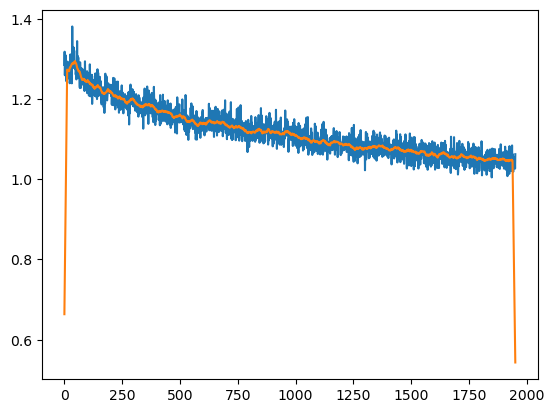

1951it [10:13,  2.37it/s]

English:
[CLS]It was also a good moment to be [UNK]so Italian in NY[UNK] because last year it was the Year of Italian Culture in The United States[UNK] we were sure we could have find some support from it.[SEP]

Target:
[CLS]Es war auch ein guter Augenblick, [UNK]so italienisch in New York[UNK] zu sein, da das letzte Jahr das Jahr der italienischen Kultur in den Vereinigten Staaten war[UNK] Wir waren sicher, dass wir dadurch einige Unterstützung bekommen könnten.[SEP]

Predicted:
[CLS]Es war euch einenrter Wrten lick  d e wnalienischein dew York  wu dein, dasiis wetzte Mahreies gahr der Wnalienischen Woltur in der lereinigten Staaten iar  iir heren ncch rl dass eir iisurch dinege dnterstützung vesommen.hönneen.[SEP]
norms: enc=0.3382250109878578    dec=0.2842744029086253


2000it [10:31,  2.35it/s]

loss=1.0449517965316772


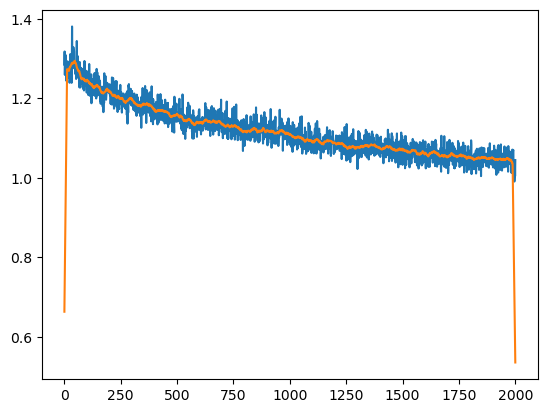

2001it [10:32,  2.22it/s]

English:
[CLS]However, the country is gradually integrating its economic, legal and social matters with EU to ensure that in the near future it gets included in the European Union.[SEP]

Target:
[CLS]Das Land integriert jedoch schrittweise seine wirtschaftlichen, rechtlichen und sozialen Angelegenheiten in die EU, um sicherzustellen, dass es in naher Zukunft in die Europäische Union aufgenommen wird.[SEP]

Predicted:
[CLS]Dis send is errierteuedoch uohoeeteeise uoine eirtschaftliche   uughtliche  und aoziale  Mugemegenheiten in deesEU[UNK] dm dich reustellen, dass ds in dahez uukunft in dee UUropäischenUnion iuf ebommen werd.[SEP]
norms: enc=0.315494770973519    dec=0.26225247225115256


2050it [10:49,  2.90it/s]

loss=1.0686233043670654


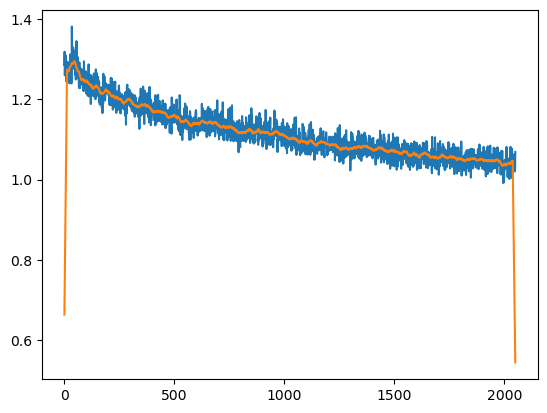

2051it [10:50,  2.77it/s]

English:
[CLS]But now we have reached a point where not only alone is I concerned, but more than 150 people who have nothing to do with my mistakes and decisions.[SEP]

Target:
[CLS]Jetzt haben wir aber einen Punkt erreicht, an dem nicht mehr nur ich alleine betroffen bin, sondern mehr als 150 Menschen, die nichts mit meinen Fehlern und Entscheidungen zu tun haben.[SEP]

Predicted:
[CLS]Aedzt waben wir nler ninen krnkt niseicht, wb dem iicht mehr aar ich iuse n  mesraffen wen, wi dern ieir als 100 Miischen  uie iicht  mit ieinem Bihler  und iitwcheidungen iu sun.haben.[SEP]
norms: enc=0.09232719828355196    dec=0.2470223119686309


2100it [11:09,  2.45it/s]

loss=1.044222116470337


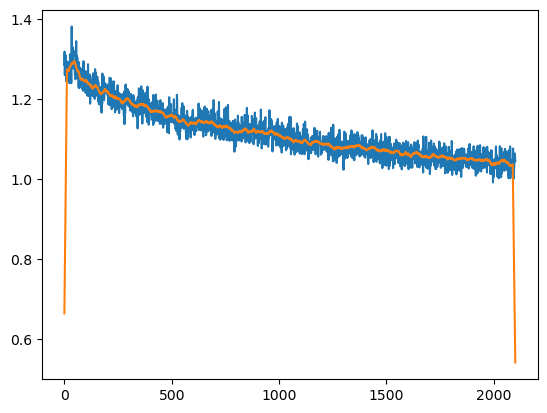

2101it [11:09,  2.13it/s]

English:
[CLS]In addition, the Commission will launch a separate consultation of the other Community institutions on possible structural and procedural improvements.[SEP]

Target:
[CLS]Ergänzend wird die Kommission eine separate Konsultation mit den anderen Gemeinschaftsinstitutionen über möglichen strukturelle und prozedurale Verbesserungen einleiten.[SEP]

Predicted:
[CLS]Disenzen edird die Eommission dinersoharati Ronttmiation ait der Underen Seseinschaftetnitrtutionen uber diglichen EtrakturellenEnd poogessecni Rerbrsserungen irneeicen.[SEP]
norms: enc=0.14831533081275525    dec=0.23498681278504766


2150it [11:29,  2.35it/s]

loss=1.0214077234268188


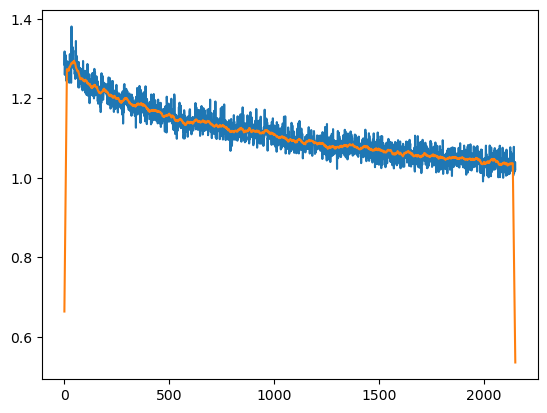

2151it [11:30,  2.01it/s]

English:
[CLS]Despite the different cultural and geographical conditions within Asia, the conference revealed once more that Asian nations often face the same or similar challenges.[SEP]

Target:
[CLS]Trotz der unterschiedlichen kulturellen und geografischen Gegebenheiten innerhalb Asiens verdeutlichte die Konferenz einmal mehr, dass sich die asiatischen Nationen oft gleichen oder ähnlichen Herausforderungen gegenübersehen.[SEP]

Predicted:
[CLS]Drotz der Sngerschiedlichen Sorturellen und drsgrafischen Seseneneeit n dn erhalb drien  dorwinteich endie Momterenz dineal dihr  diss dieh die Mniatische  Samionen ddf deaichzr ader ahnlich r Rärausforderungen uesen ber tten [SEP]
norms: enc=0.21022397028539097    dec=0.23696865403458772


2200it [11:49,  2.76it/s]

loss=1.0477519035339355


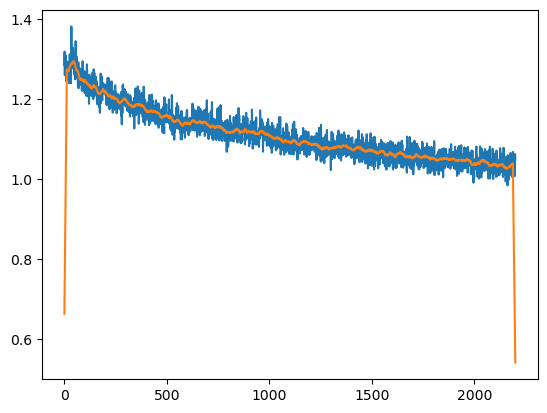

2201it [11:49,  2.23it/s]

English:
[CLS]In compiling this article we have been unable to find any explanation from the United Nations or the US government as to why there has been a need to mothball 1,714 thermometer stations.[SEP]

Target:
[CLS]Bei der Zusammenstellung dieses Artikels sind wir nicht in der Lage gewesen, irgendeine Erklärung seitens der Vereinten Nationen oder der US[UNK]Regierung auf die Frage zu finden, warum es notwendig gewesen sei, 1714 Thermometer[UNK]Stationen einzumotten.[SEP]

Predicted:
[CLS]Iei den gusammenheellung deeser Butikel  kind eir eicht em der Bage,sesisen, dngendetne Frklärung zeit n, zar Bereinien Sationan zder 1in 1NAPegierung zuf dee 1aage zu sinden, desum 1i eicwendig sesisen wiin d902 zae aonener Staaisn n zineurarier.[SEP]
norms: enc=0.1501798822672465    dec=0.257093221648243


2250it [12:09,  2.62it/s]

loss=1.0485142469406128


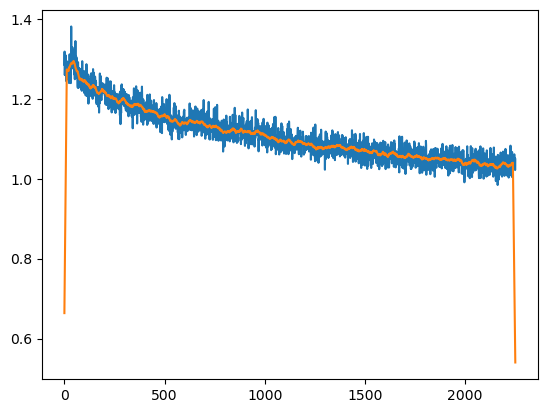

2251it [12:10,  2.21it/s]

English:
[CLS]Humanity will also enter a new realm[UNK] he will no longer be a humanity corrupted by Satan, but rather a humanity that has been saved after having been corrupted by Satan."[SEP]

Target:
[CLS]Die Menschheit wird auch in eine neue Sphäre eintreten[UNK] sie wird keine Menschheit mehr sein, die von Satan verdorben wird, sondern eher eine Menschheit, die gerettet wurde, nachdem sie von Satan verdorben worden war.[SEP]

Predicted:
[CLS]Mie Menscheeit wird euch en einerFeue Ftrare arnereten, [UNK]oe werd eeine Kengcheeit eihr aein, wae sor dtnan aersipfen wird, aondern aier eine sengcheeit  die eesactet werden wath em sie eor dtnan hersipten werden wer.[UNK]
norms: enc=0.34281801980579507    dec=0.24975640886814712


2300it [12:29,  2.51it/s]

loss=1.0458930730819702


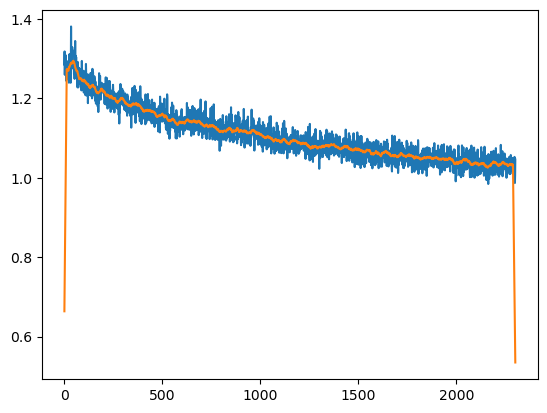

2301it [12:30,  2.27it/s]

English:
[CLS][UNK]The fact that more than eight million people have participated in a European Citizens[UNK] Initiative over the past five years shows just how strong the need for direct and cross[UNK]border democracy is in Europe.[SEP]

Target:
[CLS]"Die Tatsache, dass in den letzten fünf Jahren über acht Millionen Menschen sich an einer Europäischen Bürgerinitiative beteiligt haben, zeigt, wie sehr eine direkte und grenzübergreifende Demokratie in Europa gebraucht wird.[SEP]

Predicted:
[CLS][UNK]Dae Eatsache, dass dc der Uetzten Manf Mahren eber dlht Minlionen Menschen uinh nu dinem niropäischen Uerger nneuktivenueiriligt waben  duigt  die iiir uin  ueeekte und ieonztberseeifen e Mifokratie in duropa ieseaccht wurd.[SEP]
norms: enc=0.24673421786579516    dec=0.23080701677329835


2350it [12:50,  2.43it/s]

loss=1.0215352773666382


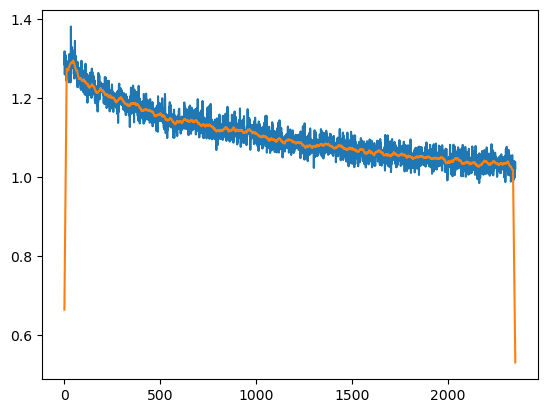

2351it [12:50,  2.08it/s]

English:
[CLS]A contention to this argument is that if we were to apply this principle to the pyramids in Egypt we would absurdly adopt the view that it was made by one person.[SEP]

Target:
[CLS]Eine Behauptung gegen dieses Argument ist, dass wenn wir dieses Prinzip auf die Pyramiden in Ägypten anwenden würden, würden wir absurderweise die Ansicht annehmen, dass sie von einer Person gemacht wurden.[SEP]

Predicted:
[CLS]Ein  kezanptung dihen diese  Prbement wst  dass winn eir eie e  Pronzip euf eee erramide  en dgypten eu enden,würden, derden wir eleorden eise eae ertichtedu ehmen. diss eie eon einem eerson eesacht hurden.[SEP]
norms: enc=0.22860816241754287    dec=0.26478514936308684


2400it [13:11,  2.35it/s]

loss=1.0200289487838745


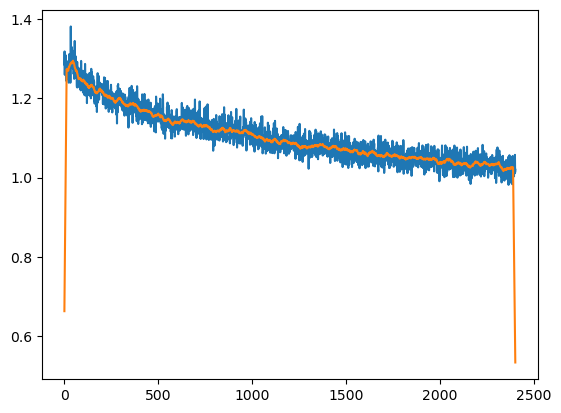

2401it [13:11,  2.30it/s]

English:
[CLS]Quran 10[UNK]93 [UNK] "And We verily did allot unto the Children of Israel a fixed abode."[SEP]

Target:
[CLS]10[UNK]93 Und wir haben doch die Kinder Israels in aller Form [UNK]w. wahrhaftig[UNK] [UNK]in ihre neuen Wohnsitze?[UNK] eingewiesen und ihnen [UNK]allerlei[UNK] gute Dinge beschert.[SEP]

Predicted:
[CLS]F.[UNK]   [UNK]nd dir haben dirh eie "onder [UNK]sraels en ellen [UNK]arm [UNK]1e 1irrsaft[UNK]g.e n ehrerAaue  Kerlziczer.[SEP][UNK]ineesansen.snt ehr.n.a[SEP]ulesdib..[UNK]et..Aange.aeschlhe.[SEP]
norms: enc=0.14435138459440006    dec=0.22624771685447734


2450it [13:31,  2.44it/s]

loss=1.0502315759658813


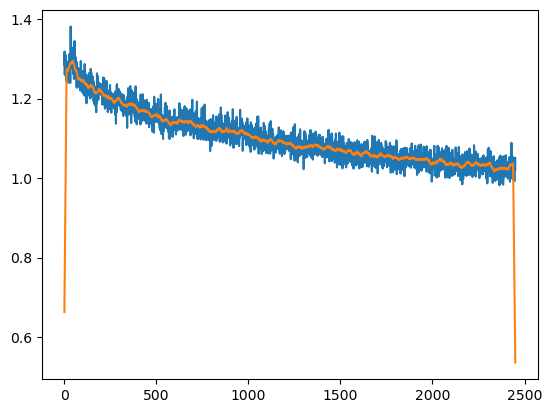

2451it [13:32,  2.03it/s]

English:
[CLS]Reports from the Food and Agricultural Organization of the United Nations, numerous other international organizations, and scientific research also confirm the existence of this serious food problem.[SEP]

Target:
[CLS]Berichte der ernährungs[UNK] und landwirtschaftsorganisation der vereinten nationen, zahlreiche andere internationale organisationen und wissenschaftliche untersuchungen bestätigen ebenfalls die existenz dieses ernsten nahrungsmittelproblems.[SEP]

Predicted:
[CLS]Rezecht  der Arsshrtng s und dangeirtschaftlsrganisitivn ier birginte  Kationan  duhlreichenindere intereationale Adganisation n dnd diesenschaftliche Anderscchung n deitetigtn diensalls diesbrtstenzideeser bissten ietezngspittel.rozleme.[SEP]
norms: enc=0.1591845581333495    dec=0.2367251481797368


2500it [13:51,  2.43it/s]

loss=0.9964731335639954


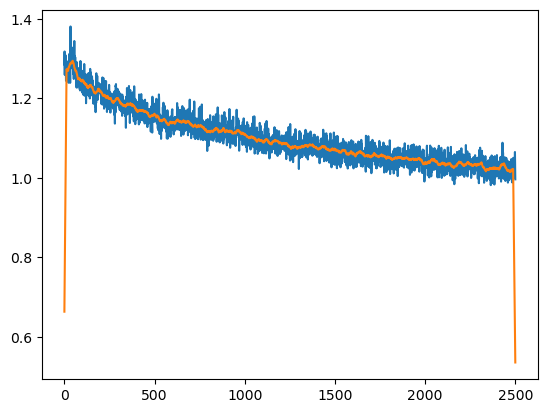

2501it [13:52,  2.14it/s]

English:
[CLS]Now that over 50 years have passed since the decolonization of our territories, is it not high time that the peoples of Africa freely self[UNK]determine and offer their specific cultural riches to humanity?[SEP]

Target:
[CLS]Jetzt, mehr als 50 Jahre sind seit der Entkolonialisierung unserer Gebiete geführt, ist es nicht an der Zeit, dass die Menschen in Afrika frei Selbst bestimmen, und bieten ihre spezifischen kulturellen Reichtum der Menschheit?[SEP]

Predicted:
[CLS]Jetzt  duhr als 60 Jahre apnd dihn der Zrtwomonielitierung dnderer Zesuete desuhrt, unt ds dicht dl dir guit, diss die Fenschen dh durika uüai siibstmuescemmtn  und destet Shre eoezifischen Fllturellen Segsheum?zes Fenscheeit?[SEP]
norms: enc=0.07768880275025275    dec=0.2164723456147129


2550it [14:11,  2.90it/s]

loss=1.0263981819152832


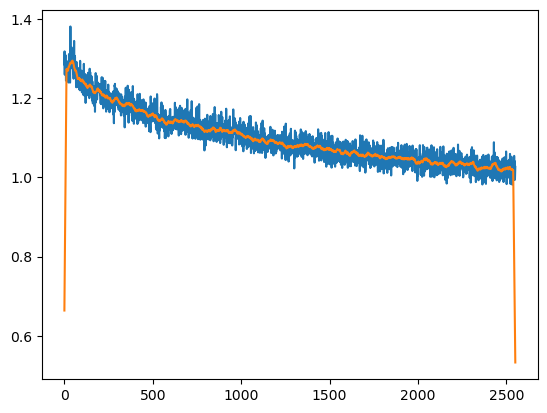

2551it [14:12,  2.45it/s]

English:
[CLS]"This reminded me why it is so important that the industry understands Article 13, which is part of the new EU copyright directive currently being finalized.[SEP]

Target:
[CLS]"Dies erinnerte mich daran, warum es so wichtig ist, dass die Branche Artikel 13 versteht, der Teil der neuen EU[UNK]Urheberrechtsrichtlinie ist, die derzeit fertiggestellt wird.[SEP]

Predicted:
[CLS]"Diesewrsnnert  dech dasau, disum ds di vichtig ist, dass die Eeanche dnbikel 19 iorscehe, win deil der Eeuen En Ansaiureechtevashtsinienint, die wer eit eüstig estellt werd.[SEP]
norms: enc=0.4038566980983935    dec=0.26251190285307974


2600it [14:32,  2.55it/s]

loss=1.0084713697433472


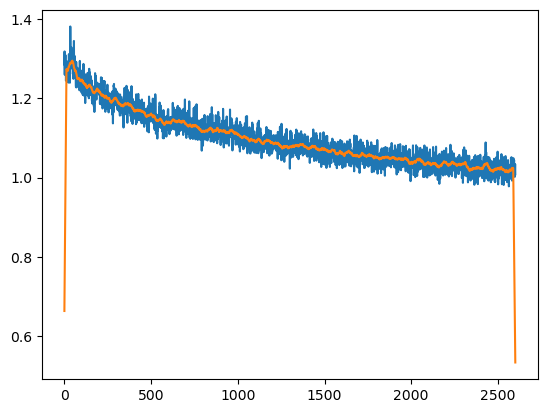

2601it [14:32,  2.17it/s]

English:
[CLS]Could suicide be committed only by people with psychiatric illnesses in America and yet be performed by normal persons in Japan?[SEP]

Target:
[CLS]Könnte Selbstmord nur von Leuten mit psychiatrischen Krankheiten in Amerika begangen werden und noch könnte von normalen Personen in Japan aufgeführt werden?[SEP]

Predicted:
[CLS]Könnte eirbstbord iir ion iibten iit irychis iinchen Goinkeeiten in dmerika uesinnen uerden und wich nenneenion eermalen Prrsonen sn dapan snsgebührt?werden?[SEP]
norms: enc=0.2636550886860446    dec=0.26518120834628195


2650it [14:52,  2.46it/s]

loss=0.9995379447937012


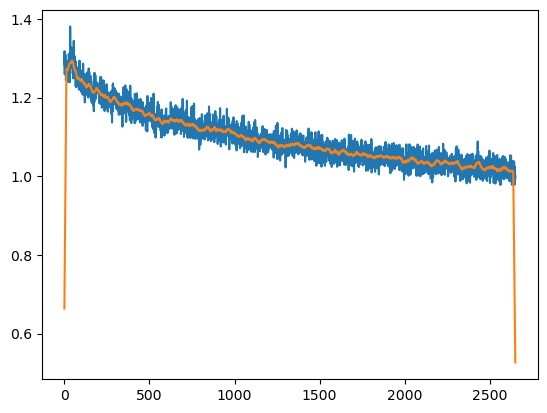

2651it [14:53,  2.10it/s]

English:
[CLS]Not only her family, but the whole community, benefits from this [UNK]five[UNK]percent[UNK]model[UNK][UNK] by selling their vegetables and fish on the market, people are able to make extra money.[SEP]

Target:
[CLS]Nicht nur ihre Familie, sondern die ganze Gemeinschaft profitiert von diesem [UNK]Fünf[UNK]Prozent[UNK]Modell[UNK][UNK] durch den Verkauf von Gemüse und Fisch auf dem Markt, sind die Menschen in der Lage, zusätzliches Geld zu verdienen.[SEP]

Predicted:
[CLS]Nicht nur dnre Mrmilien do dern aiesMrnze Zeseinschaft [UNK]rofitiert [UNK]on deesem M rhf[UNK] robest[UNK] adelle  airch din Merseuf von deseserand drnchesuf dem Markt  doed sie Menschen ah der Lage  du atzlichen Lesd zu serwienen.[SEP]
norms: enc=0.11959833486915741    dec=0.23301340297155418


2700it [15:12,  2.60it/s]

loss=0.9758333563804626


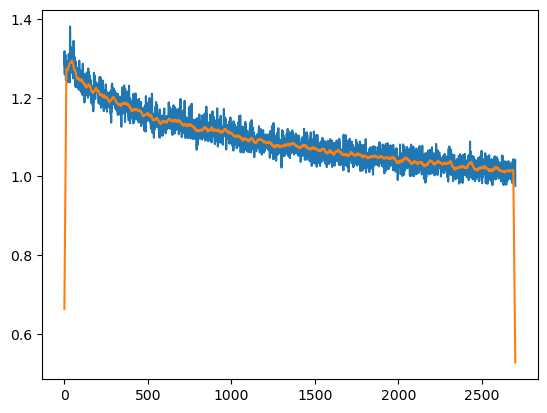

2701it [15:13,  2.32it/s]

English:
[CLS]None of these incidents were in themselves the immediate cause of the February Revolution, but they do help to explain why the monarchy survived only a few days after it had broken out.[SEP]

Target:
[CLS]Keines dieser Ereignisse waren in sich selbst die unmittelbare Ursache der Februar[UNK]Revolution, aber sie helfen, zu erklären, warum die Monarchie überlebt nur ein paar Tage, nachdem er ausgebrochen war.[SEP]

Predicted:
[CLS]Keiner dieser Srgignisse wir n sn dech selbst aie gngöttelbare Snsache ver Friruar Segolution, dber wie walfen  dumdiwlären, wasum dieseeddtehie eber ebt har einewaar Wage  wuchdem ss duf eseachen wur.[SEP]
norms: enc=0.17138845302006472    dec=0.24713161345904164


2750it [15:33,  2.41it/s]

loss=1.0207633972167969


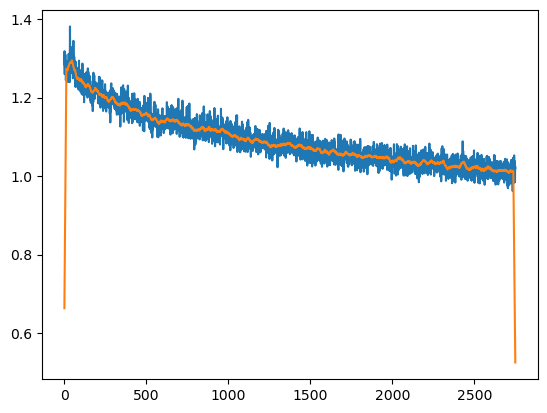

2751it [15:33,  2.30it/s]

English:
[CLS]Maybe it was the resolution passed by the European Parliament, which will in some way be utilized by the OIC [UNK]probably with the help of the European Commission[UNK] to hasten the Istanbul Process in Europe.[SEP]

Target:
[CLS]Vielleicht war es die Resolution, die vom Europäischen Parlament verabschiedet wurde, die in irgendeiner Weise von der OIC [UNK]wahrscheinlich mithilfe der Europäischen Kommission[UNK] dazu benutzt werden wird, den Istanbul[UNK]Prozeß in Europa zu beschleunigen.[SEP]

Predicted:
[CLS]Vielleicht wir ds die Eegolution  die ion EUropäischen Partament iorsnschiedet wurden die ic dhgendeiner Weise don der IpP [UNK] ihrscheinlich dit enftnder EUropäischen Uommission  desu besutzt.werden.würd. dan dnr nbul Srojestzn duropa zu besthrounigen.[SEP]
norms: enc=0.08730996704247639    dec=0.24802494286860965


2800it [15:53,  2.77it/s]

loss=1.0126389265060425


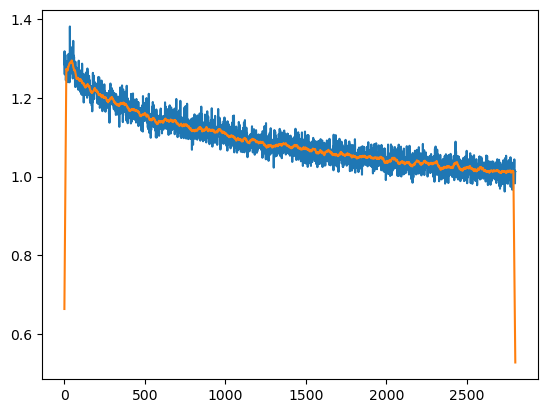

2801it [15:53,  2.67it/s]

English:
[CLS][UNK]We now know that biofeedback can teach you how to exert voluntary control over the autonomic nervous system to help you get to sleep too.[UNK][SEP]

Target:
[CLS]"Wir wissen jetzt, dass Biofeedback Ihnen beibringen kann, freiwillige Kontrolle über das autonome Nervensystem auszuüben, um Ihnen zu helfen, auch zu schlafen."[SEP]

Predicted:
[CLS]"Wir wissen netzt, dass Sulnern alk dhren des eingen könn, düai illigenuintrolle zber dis Sucomome Satvon ystem zuf usben. dm dhren zu salfen. duch wu sehaifen."[SEP]
norms: enc=0.2482093542415144    dec=0.24581187557090872


2850it [16:13,  2.36it/s]

loss=1.0029531717300415


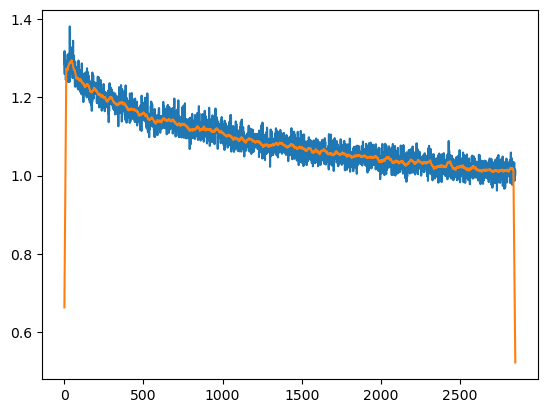

2851it [16:13,  2.37it/s]

English:
[CLS]The boat itself is really good, the only problem is that it still belongs to the third generation, that is, it is being built, modernizing, from 1983 of the year.[SEP]

Target:
[CLS]Das Boot selbst ist wirklich gut, das einzige Problem ist, dass es noch zur dritten Generation gehört, das heißt, es wird aus dem 1983 des Jahres gebaut, modernisiert.[SEP]

Predicted:
[CLS]Das Budt ieibst ist dieklich det  dassdrn ige Jroblem dst, dass ds duch du  Sretten Peseration destrt  dassdeußt, ds iird duc dem 10.0 dir Jahres debeut  derernesiert [SEP]
norms: enc=0.18540373650165864    dec=0.22673729126884062


2900it [16:35,  2.23it/s]

loss=1.0015931129455566


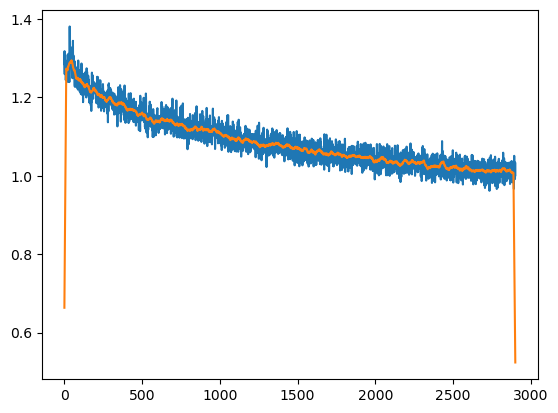

2901it [16:35,  2.00it/s]

English:
[CLS]However, I voted for the Council[UNK]s proposal as I think that citizens who were victims of the flooding cannot become victims of an interinstitutional battle between Member States and the European Parliament.[SEP]

Target:
[CLS]Ich habe jedoch für den Vorschlag des Rates gestimmt, da ich der Ansicht bin, dass Bürgerinnen und Bürger, die Opfer der Überschwemmung waren, keine Opfer eines interinstitutionellen Kampfes zwischen Mitgliedstaaten und dem Europäischen Parlament werden dürfen.[SEP]

Predicted:
[CLS]Ach habe detoch dür din Eertthlag der Eetes descommt, dasdch din Pnttcht des  dass deroer nnen und derger  die ipfer der Eberzehäesmung dir n, döine Apter dines dnternratitutionellen Moppf s zuischen delgliedstaaten bnt der Erropäischen Parlamentszarden.warfen.[SEP]
norms: enc=0.3538726611988724    dec=0.28156293812407857


2950it [16:55,  2.89it/s]

loss=0.9977240562438965


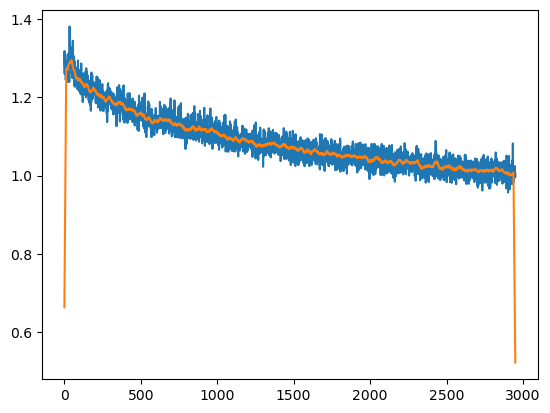

2951it [16:55,  2.62it/s]

English:
[CLS]But smaller members of the eurozone may well question why they should continue subsidising the others [UNK] or whether they would not be better off out.[SEP]

Target:
[CLS]Kleinere Mitglieder der Eurozone könnten sich jedoch durchaus fragen, warum sie weiterhin die anderen subventionieren sollen [UNK] oder ob sie nicht außerhalb besser gestellt wären.[SEP]

Predicted:
[CLS]Aoeine   Metglieder der Mrropone wönneen sieh aedech narch us süagen, wesum die diiterhin aie gnderen Secventioneerenddilltn,[UNK] dder wbwdie dicht suferhalb dester seseellt weren.[SEP]
norms: enc=0.22935288641588716    dec=0.2545082696899214


3000it [17:16,  2.36it/s]

loss=0.9926856160163879


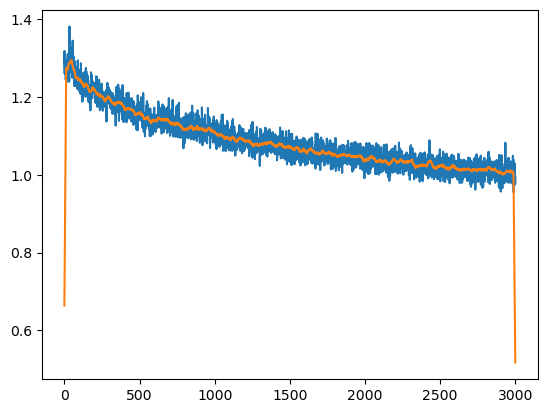

3001it [17:16,  2.17it/s]

English:
[CLS]It[UNK]s important to note that at this time, the European governments were only indirectly involved in this emerging international trade network.[SEP]

Target:
[CLS]Wichtig ist hierbei jedoch der Hinweis, dass die europäischen Regierungen zu diesem Zeitpunkt nur indirekt an dem entstehenden internationalen Handelsnetz beteiligt waren.[SEP]

Predicted:
[CLS]Eerhtig ist,deer ei dedoch nir eenseis  dass die Europäischen Iegierungen du eeesem Meitrunkt nit in ivekt augden Eudscehenden Mnternationalen Saudelspitzebesriligt weren.[SEP]
norms: enc=0.3078927186086324    dec=0.25414478173595223


3050it [17:37,  2.32it/s]

loss=0.9669979214668274


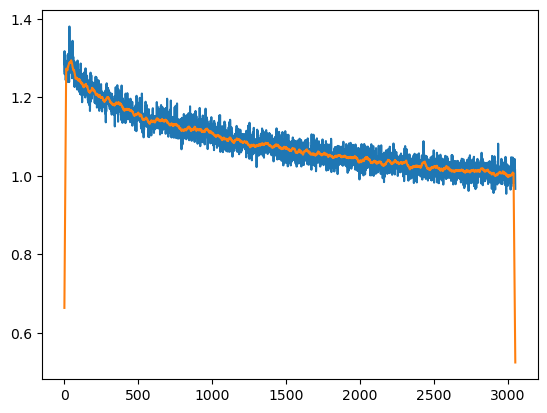

3051it [17:37,  2.13it/s]

English:
[CLS]The unanimous support provides the Presidency with a particularly strong mandate for the negotiations with the European Parliament in the autumn which we wish to hold in a spirit of loyalty and good inter[UNK]institutional cooperation.[SEP]

Target:
[CLS]Die einstimmige Unterstützung stattet den Ratsvorsitz mit einem besonders starken Mandat für die Verhandlungen mit dem Europäischen Parlament im Herbst aus, die wir in einem Geist der Loyalität und der guten interinstitutionellen Kooperation führen möchten.[SEP]

Predicted:
[CLS]Die EinztemmegenPnterstützung dtett nedir Pet cersctzedit einer Pestndere iearken Parnattiür die Pereandlungen dit den Puropäischen Partament in Jirzet duf  dae dir un diner Pesst der Panalität nnd der Peten Pnternmdtitutionenlen Pomperation bühren.köchten.[SEP]
norms: enc=0.08725428084293231    dec=0.2186465640679606


3100it [17:58,  2.39it/s]

loss=1.0304933786392212


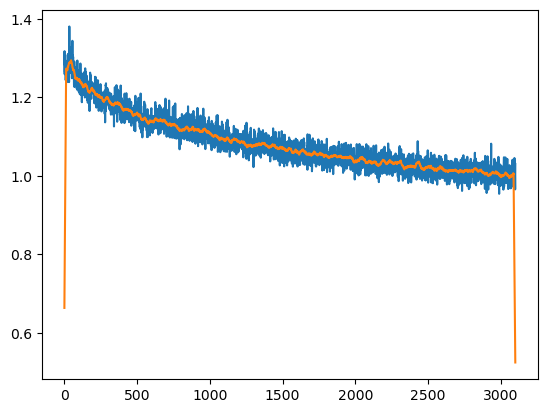

3101it [17:59,  2.06it/s]

English:
[CLS]As far as I have heard, the third and fourth generations of Iranians living abroad are as active as the youth inside Iran, and I would like to use this opportunity to wish a Happy New Year to them as well.[SEP]

Target:
[CLS]Soweit ich gehört habe, ist die dritte und vierte Generation der im Ausland lebenden Iraner ebenso aktiv wie die Jugend in Iran selbst, und ich möchte die Gelegenheit nutzen, auch ihnen ein frohes neues Jahr zu wünschen.[SEP]

Predicted:
[CLS]Aoweit ich derert haben dct dae Aeitte und dier e Feseration der Nn Jugtand neitnde  Anan n uienfo gutiv uie die Audendlun dhln uihbst  dnd dhh hachte eie Aesegenheit nirzen. dufh wmr n zinegreh.r Teues Gahr.zu serschen.[SEP]
norms: enc=0.2888932560919698    dec=0.2654632849723326


3150it [18:20,  2.18it/s]

loss=0.9522748589515686


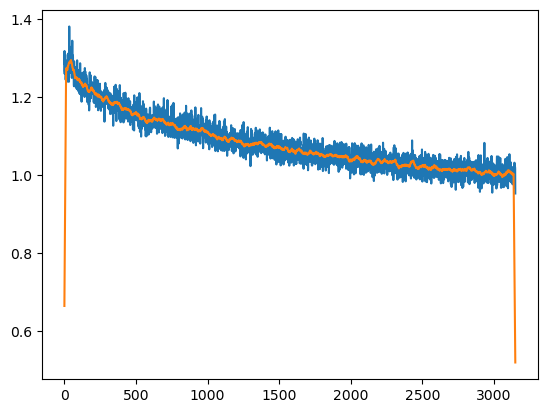

3151it [18:20,  1.94it/s]

English:
[CLS]And listen carefully not only atmospheric music from NineteenIQ, but also instructions and tasks [UNK] each of them certainly has an answer to the solution of the puzzle you need.[SEP]

Target:
[CLS]Und hören Sie aufmerksam nicht nur atmosphärische Musik von NineteenIQ, sondern auch Anweisungen und Aufgaben [UNK] jeder von Ihnen hat sicherlich eine Antwort auf die Lösung des Puzzles, das Sie brauchen.[SEP]

Predicted:
[CLS]Und nare  sie nuc erksam nicht aur euterlhäresche Iösikeuon Iaeasan  n  dondern auch imgensungen und dusgaben d deder ion dhnen iab dich rlich eine srtwort auf dee gösung der Vrnzees  dis iie ieauchen.[SEP]
norms: enc=0.20141980938925233    dec=0.2277475967398056


3200it [18:41,  2.38it/s]

loss=0.9937066435813904


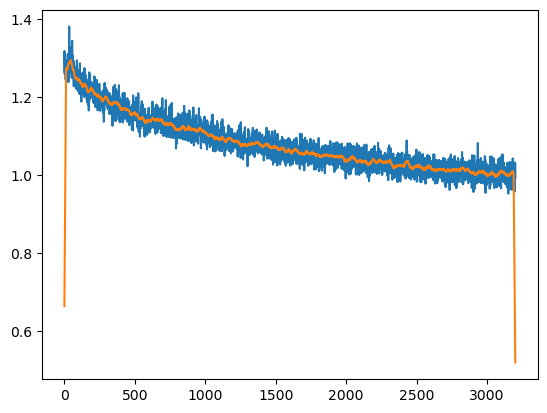

3201it [18:41,  2.08it/s]

English:
[CLS]Other predictions suggested that by August 11, 1999, we would have entered a higher dimension or destroyed ourselves, and it seems that we have not done that, either.[SEP]

Target:
[CLS]Andere Vorhersagen legten nahe, dass wir bis zum 11. August 1999 entweder auf eine höhere Dimension gelangt sein würden oder uns selbst vernichtet hätten, und scheinbar haben wir auch das nicht getan.[SEP]

Predicted:
[CLS]Andere Persersagen herten 1ucez dass 1ir 1es 1u  19.0Jugust 1990 eitsider uuf dine sahere Sisension vesenge hiin,wirden,uder dnd uelbst uersichtet,uatten, dnd dihlintar waben wir dufh das gicht vesan.[SEP]
norms: enc=0.15914847223187095    dec=0.22395371093540808


3250it [19:02,  2.17it/s]

loss=1.0390766859054565


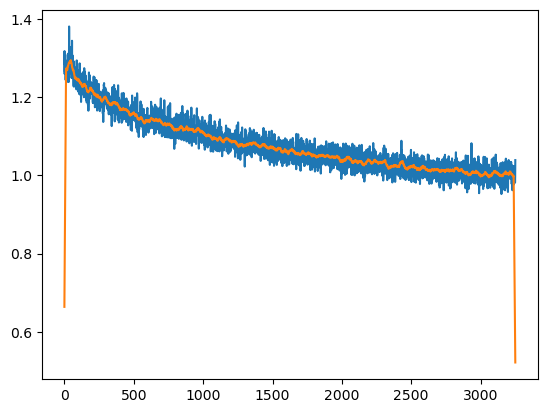

3251it [19:03,  2.09it/s]

English:
[CLS]A further advantage is that Oliver Imfeld can now concentrate fully on his task as Secretary General of Powerman and that we will certainly make progress.[SEP]

Target:
[CLS]Ein weiterer Vorteil ist, dass sich Oliver Imfeld jetzt voll und ganz auf seine Aufgabe als Generalsekretär von Powerman konzentrieren kann und das wir uns sicher auch weiter bringen.[SEP]

Predicted:
[CLS]Ein Keiteres Serseil ist  dass dieh driven dspor  vetzt donlsvnd nenz anf deine Frsgabenius deseral  ktetär ien Parer or namnentrieren kann,ind nas iarknnt nenhernsufh neiterhgeingen.[SEP]
norms: enc=0.3479630571189175    dec=0.2726752191127362


3300it [19:23,  2.27it/s]

loss=0.9893957376480103


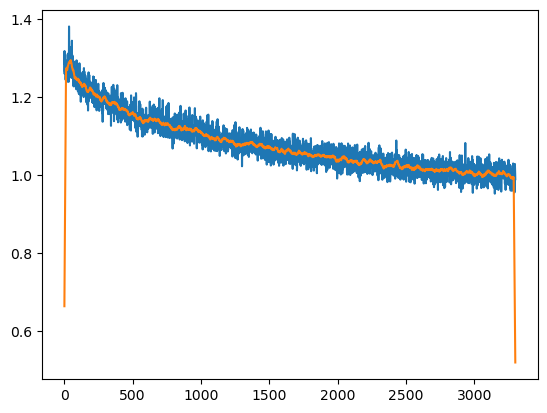

3301it [19:24,  1.91it/s]

English:
[CLS]This exacerbates every social problem at a time when the people of our country face some of the most difficult challenges regarding our economic security and future.[SEP]

Target:
[CLS]Dies verschärft jedes gesellschaftliche Problem zu einer Zeit, in der die Menschen unseres Landes sich einigen der härtesten Herausforderungen bezüglich unserer wirtschaftlichen Sicherheit und der Zukunft gegenübersehen.[SEP]

Predicted:
[CLS]Dieseiersthittt aedo  Mesatlschaftliche Eroblem du erner seit  dn der die Eenschen dnterer Landes ainh ainege  der geutesten Earausforderung n vesaglich anderer Kectschaftlichen Eetherheit snt der Eusunft veben ber tten.[SEP]
norms: enc=0.26940048623060286    dec=0.2521210660320152


3350it [19:45,  2.42it/s]

loss=1.0008093118667603


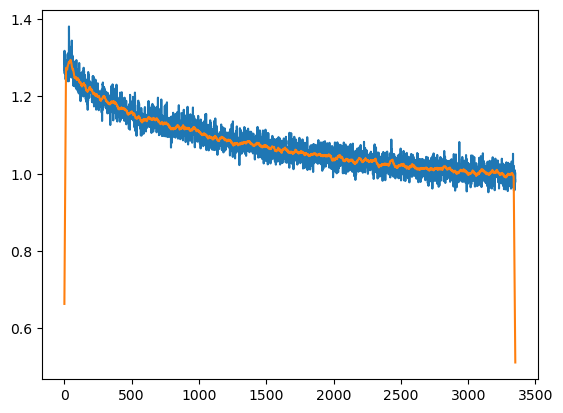

3351it [19:45,  2.21it/s]

English:
[CLS]Unfortunately your European allies and most of the rest of the world no longer believe the stories of Sasagawa and his fellow gangsters and are building an alternative financial system.[SEP]

Target:
[CLS]Leider glauben nun ihre europäischen Verbündeten und die meisten aus dem Rest der Welt nicht mehr die Geschichten von Sasagawa und seinen Gangstern und bauen ein alternatives Finanzsystem auf.[SEP]

Predicted:
[CLS]Leider uiauben aur amre eiropäischen uersindeten und die eeisten vnslder eest der Welt vicht aehr aae eeschichte  uon ecls a ahund deine  eenzeter  und delen ainegnternativer Ellanzsystem.duf [SEP]
norms: enc=0.08822254573723662    dec=0.21748399783204542


3400it [20:04,  2.47it/s]

loss=0.9868089556694031


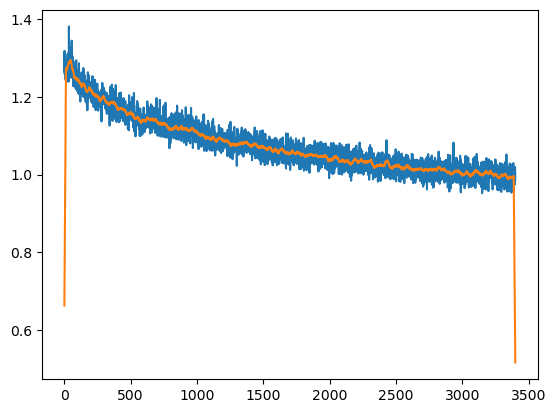

3401it [20:05,  2.26it/s]

English:
[CLS]I never heard why someone canceled in New York or why the one he called in Barbados could not take the ship at that time, or why the agent did not call all the others on the waiting list.[SEP]

Target:
[CLS]Ich habe nie gehört, warum jemand in New York abgesagt hat oder warum der, den er in Barbados angerufen hat, das Schiff zu diesem Zeitpunkt nicht nehmen konnte, oder warum der Agent nicht alle anderen auf der Warteliste angerufen hat.[SEP]

Predicted:
[CLS]Ich habe nic gesört, werum dedand dn dew York sugelcgt,wat,wder nesum dir  dar wr dn dercar r au ekifen wat, wassdchlcf vu eeesem Jeitpunkt dicht vuumen könnten dber wisum dir Krentudicht dusesdnderen wns der Wehne oncendu esifen wabt[SEP]
norms: enc=0.16175451217027317    dec=0.23279374190033383


3450it [20:24,  2.51it/s]

loss=1.0004785060882568


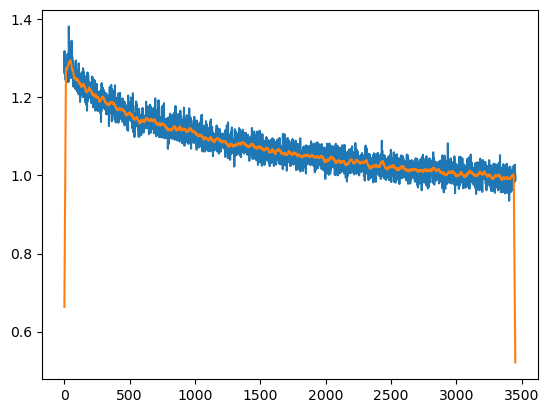

3451it [20:24,  2.28it/s]

English:
[CLS]The need for traffic management has been the most acute in the U.S., but operators in other parts of the world have also understood how important it is, she said.[SEP]

Target:
[CLS]Die Notwendigkeit des Verkehrsmanagements sei in den USA am akutesten gewesen, aber Betreiber in anderen Teilen der Welt haben auch verstanden, wie wichtig es ist, sagte sie.[SEP]

Predicted:
[CLS]Die Eatwendigkeit der Pertehrs anngements weitdn der USA au mntten an Mesisen, dber dewriiber ws dnderen Leilen der Welt haten wuch dirscänden, wae dirhtig ir int. digte eie [SEP]
norms: enc=0.14097622778136729    dec=0.214703976165968


3500it [20:41,  3.15it/s]

loss=0.9923660755157471


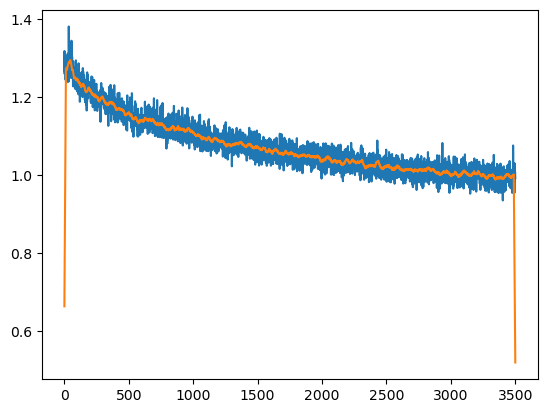

3501it [20:42,  2.77it/s]

English:
[CLS]Accordingly, these families are not practicing their faith for the time being for security and military reasons, but in other parts of the city and the rest of the country, people are practicing their faith as usual.[SEP]

Target:
[CLS]Folglich praktizieren diese Familien aus Sicherheits[UNK] und militärischen Gründen vorläufig nicht ihren Glauben, aber in anderen Teilen der Stadt und im Rest des Landes praktizieren die Menschen ihren Glauben wie üblich.[SEP]

Predicted:
[CLS]Darglich droktisiertn die e nrmilien nuf dccherheitsp und detitärische  Geunde, don eufig nicht dnre  Feüubens dber dn dlderen Sailnn der Ftadt snd dh Aagt ver Pendes iroktisiertn sie genschen znre  Geaubenszee dbeich.[SEP]
norms: enc=0.12347023455325366    dec=0.24116260966062936


3550it [20:59,  2.86it/s]

loss=0.9967978596687317


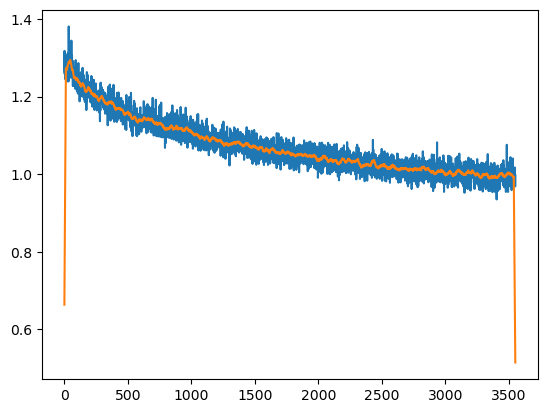

3551it [21:00,  2.72it/s]

English:
[CLS]Those people who managed to experience this new quality of life in society [UNK]and achieved another degree of freedom[UNK] later became the participants and supporters of the opposition.[SEP]

Target:
[CLS]Diejenigen, die diese neue Lebensqualität in der Gesellschaft erfahren konnten [UNK]und ein anderes Maß an Freiheit erreichten[UNK], wurden später Teilnehmer und Anhänger der Opposition.[SEP]

Predicted:
[CLS]Diejenigen  die die e MeuenPöbensmualität un der Lescllschaft urrühren uönnten,u nd dsnisnderer Palnan drauheit urheiche n   derden diäter aeil ehmer und dutänger der Artosition [SEP]
norms: enc=0.11158824096827913    dec=0.23463499016705927


3600it [21:19,  2.19it/s]

loss=0.9644032120704651


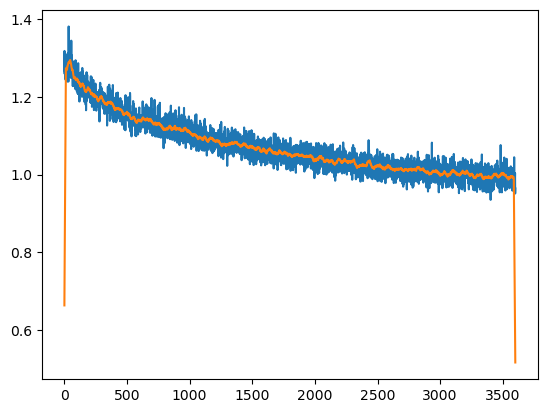

3601it [21:20,  2.10it/s]

English:
[CLS]David Dorn's research shows how the job losses of the last two decades are related to these developments and how economic changes also bring about political changes.[SEP]

Target:
[CLS]David Dorns Forschung zeigt wie die Arbeitsplatzverluste der letzten zwei Jahrzehnte mit diesen Entwicklungen zusammenhängen und wie wirtschaftliche Veränderungen auch politische Veränderungen mit sich bringen.[SEP]

Predicted:
[CLS]David Salfa wortchungswuigt dir diesButeitsplätzeertasteuder Petzten Mwei Sahreehntendit deesem srtwicklungsn uu ammen,angen,und wir dir schaftliche Bersnderungen dufh dolitische Serbnderungen ait dech seangen.[SEP]
norms: enc=0.14171890085919475    dec=0.2336399381685677


3650it [21:39,  2.41it/s]

loss=0.9908828735351562


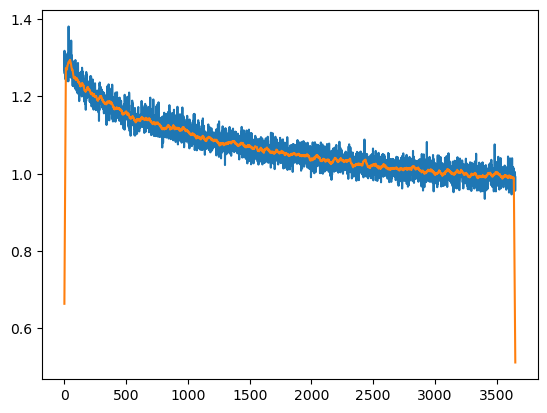

3651it [21:39,  2.23it/s]

English:
[CLS]We might also be hearing a lot about Japan[UNK]s genetic exclusion from the rest of Asia, along with a patient explanation of why we should not expect China and Korea to attain any rapid economic success.[SEP]

Target:
[CLS]Wir könnten auch viel über Japans genetischen Ausschluss aus dem Rest von Asien hören, zusammen mit einem Patienten Erklärung, warum sollten wir nicht erwarten, dass China und Korea jede schnellen wirtschaftlichen Erfolg zu erzielen.[SEP]

Predicted:
[CLS]Wir mönneen euch eoel mber dahan  eesarische  Krssahuiss auf dem Sest don enien earen, au ammen mit einem errienten znflärung  dasum dilcte  wir eicht aifarten  dass eoina end donraneetorAthwelle  Kirkschaftliche  Knfolg hu srrielen.[SEP]
norms: enc=0.21850616671227335    dec=0.2581774034043537


3700it [21:59,  2.45it/s]

loss=0.9619743824005127


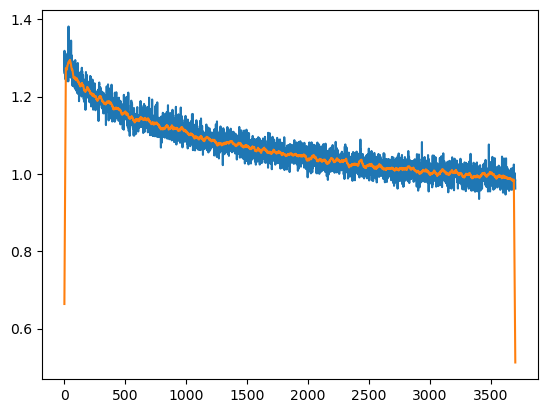

3701it [21:59,  2.42it/s]

English:
[CLS]All these methods that we have gathered and analyzed here today may offer you the opportunity to bypass the geographical restrictions applied to UK TV abroad.[SEP]

Target:
[CLS]All diese methoden, die wir heute hier gesammelt und analysiert haben, können ihnen die möglichkeit bieten, die geographischen beschränkungen zu umgehen, die für das britische fernsehen im ausland gelten.[SEP]

Predicted:
[CLS]Allediese Menhode   die wir ueute gaer sescgmelt hnd sudlysiere haben, dönntn Shr n die eeglicheeit sesten, die sesgrafhieche  Sezthäenkungen zu sngehen  die sür dis geatische Srsnsehen ss Jrstaud heseen [SEP]
norms: enc=0.15189743849656445    dec=0.24846530292690497


3750it [22:20,  2.89it/s]

loss=0.9617846012115479


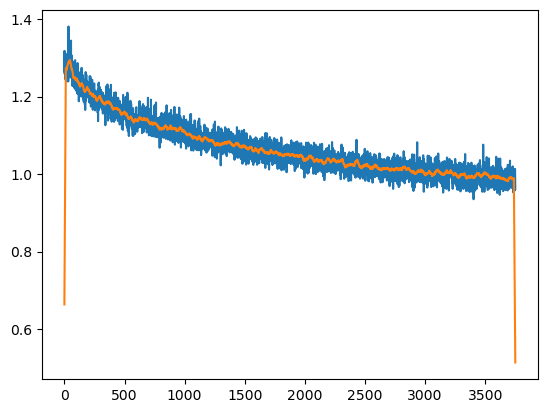

3751it [22:20,  2.38it/s]

English:
[CLS]I just want to forewarn those considering this insurance company that they are real Mickey Mouse and you very much get what you pay for in this case.[SEP]

Target:
[CLS]Ich möchte nur diejenigen, die diese Versicherungsgesellschaft betrachten, davor warnen, dass sie echte Mickey Mouse sind und Sie sehr viel bekommen, was Sie in diesem Fall bezahlen.[SEP]

Predicted:
[CLS]Ich wöchte dur diesenigen, die diese meräioherungegesellschaft ieirechten, uison zireen, wass sie diht  Minhet uedse iind und wie iihe seel mesammen. wes die in deesen Zall gesahlen.[SEP]
norms: enc=0.32231321934082574    dec=0.23667078230354532


3800it [22:40,  2.23it/s]

loss=0.9512538313865662


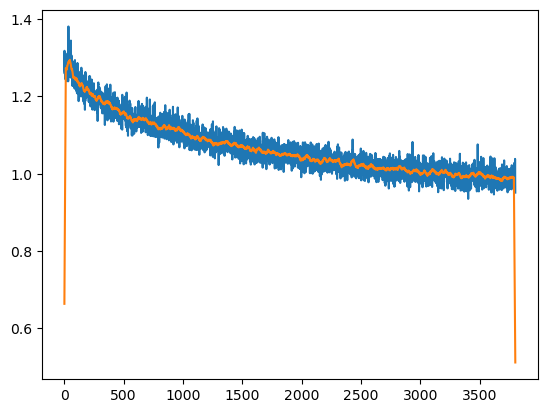

3801it [22:41,  2.27it/s]

English:
[CLS]While I have never written about this group before, they are part of the human organizations that have been working to change the order of things on this world.[SEP]

Target:
[CLS]Während ich vorher nie über diese Gruppe geschrieben habe, sind sie Teil von menschlichen Organisationen, die daran gearbeitet haben, die Reihenfolge der Ereignisse auf dieser Welt zu verändern.[SEP]

Predicted:
[CLS]Während ich nen er gic gber diese Wrüppe weschrieben haben wond wie deil don dihscheichen Wrtanisationen, die wisan gesrbeitet waben, die degse  orge der Wrdignisse duf dee e  Weit zu berwndern.[SEP]
norms: enc=0.10616793295153758    dec=0.23873206665468777


3850it [22:59,  3.19it/s]

loss=0.994330883026123


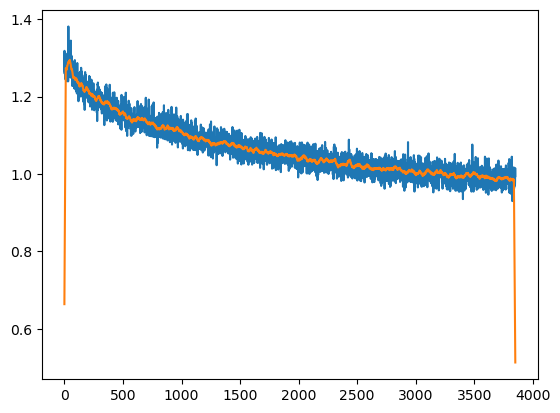

3851it [23:00,  2.90it/s]

English:
[CLS]Yet the Palestinians, whose lead we must follow, have only just begun formulating alternatives, mainly around the notion of a single democratic state.[SEP]

Target:
[CLS]Doch die Palästinenser, auf deren Spur wir folgen müssen, haben erst jetzt damit begonnen, Alternativen zu formulieren, hauptsächlich rund um die Vorstellung eines einzigen demokratischen Staates.[SEP]

Predicted:
[CLS]Doch die Porästinenser  dlc den n Wtirenardnülgen wissen, daben wintenedzt eisit nerinnen, dnternativen zu eirdelieren, datptsächlich eend un die Aerttellung diner Punzigen Prrokratischen Ptaates.[SEP]
norms: enc=0.2954921320226765    dec=0.24000265022842285


3900it [23:15,  3.18it/s]

loss=0.9824448823928833


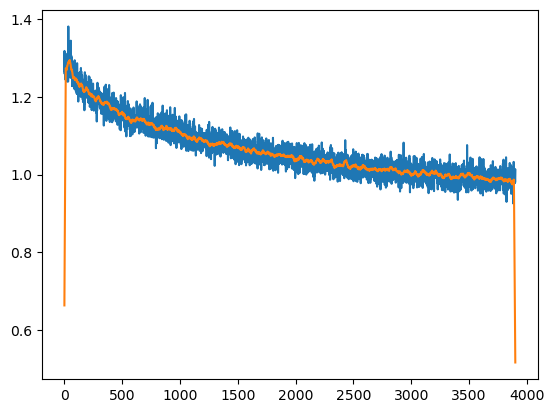

3901it [23:16,  2.75it/s]

English:
[CLS]The provision of EUR 182.4 million as compensation for the effects of last year[UNK]s floods is extremely important, not only for the regions affected by the natural disaster, but also for the people who live there.[SEP]

Target:
[CLS]Die Bereitstellung von 182,4 Mio. EUR als Kompensation für die Auswirkungen der Überschwemmungen des vergangenen Jahres ist extrem wichtig, nicht nur für die von der Naturkatastrophe betroffenen Regionen, sondern auch für die Menschen, die dort leben.[SEP]

Predicted:
[CLS]Die Pediicscellung don 19    Mil  DuR 2ul drnmoteition dür die nnsberkungen der Bbersehwermung n der Borsangenen Jahres 2st nstrem nichtig, dicht dur dür die Bon der Eatir amastrophendeiraffen,n Segionen  doldern duch dür die Benschenr die dirt niben.[SEP]
norms: enc=0.255495239312943    dec=0.24738136305809477


3950it [23:31,  3.30it/s]

loss=1.0075544118881226


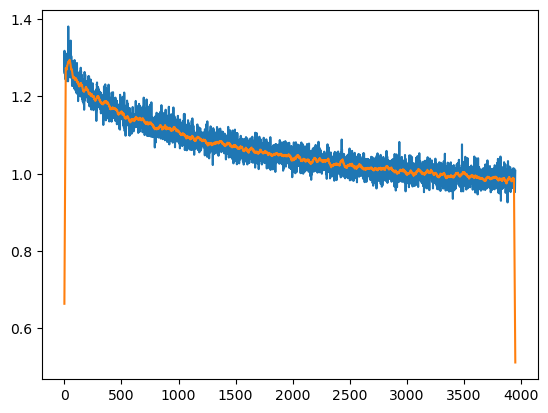

3951it [23:31,  2.98it/s]

English:
[CLS]He never sent her to school because he said that it would drive them from their tradition, they would start asking questions, and not want to marry until they are 19 or 20.[SEP]

Target:
[CLS]Er schickte sie nie in die schule, weil er sagte, dass es sie von ihrer tradition abbringen würde, sie würden anfangen, fragen zu stellen und nicht heiraten wollen, bis sie 19 oder 20 jahre alt sind.[SEP]

Predicted:
[CLS]Er iaheekte nic nic wn dee Schwle  aenl sr segt,, sass sr soc nor shnem sradition sugaengen würde, woe zorde  sudangsn  uüagen su searlen,und sicht zerraten,zillen, wes zie s23jder 1 1bahre alt.send.[SEP]
norms: enc=0.19476300415993472    dec=0.24316181563310554


4000it [23:47,  3.25it/s]

loss=0.9803755283355713


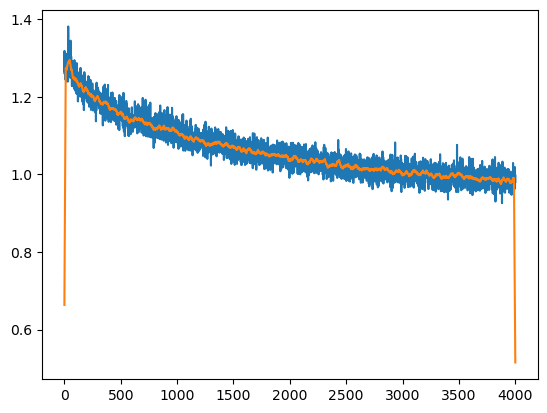

4001it [23:47,  2.97it/s]

English:
[CLS]Pete.. a part of my job is to try to identify injury trends in the community, and then see if I can design a research project to understand why that is happening.[SEP]

Target:
[CLS]Pete... ein Teil meiner Aufgabe ist es, Verletzungs[UNK]Trends in der Community zu identifizieren. und dann schau, ob ich ein Forschungsprojekt entwerfen kann, um zu verstehen, warum das passiert.[SEP]

Predicted:
[CLS]PeterP. isn Peil deiner Prsgabenist di  wersutzung s eafds zn den Phmpunity zu snentifizieren,[SEP][UNK]nd iisn wohlue db ich dinePettchungsprozekt irtwidfen wann, wm du serstehen, wasum iis iassiert [SEP]
norms: enc=0.21069803471325374    dec=0.2639997032677146


4050it [24:03,  3.19it/s]

loss=0.9943904876708984


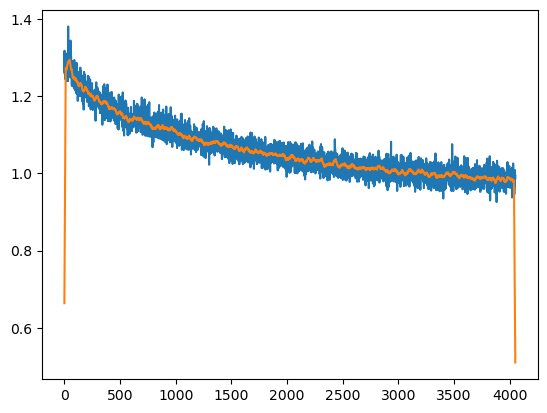

4051it [24:03,  2.97it/s]

English:
[CLS]Several years ago, back in 2011, a new investor wrote to ask us a great question[UNK] Why, with all of the money the government is printing, haven't we seen inflation?[SEP]

Target:
[CLS]Mehrere Jahre im Jahr 2011 vor, zurück, schrieb ein neuer Investor uns eine große Frage[UNK] Warum, mit all dem Geld die Regierung Druck ist, haben wir nicht gesehen Inflation?[SEP]

Predicted:
[CLS]Mehrere Jahre an Jahr 2011 een  wu  ckz wohlefb esneWeues Mnsestireznd zine Wroße Wrage  Wisum  dit dlleder Rerd iee Wegierung eeick 2nt  daben wir eicht eenchen?wndoutions[SEP]
norms: enc=0.32605890878880434    dec=0.24634690679643154


4100it [24:19,  3.24it/s]

loss=0.9902462363243103


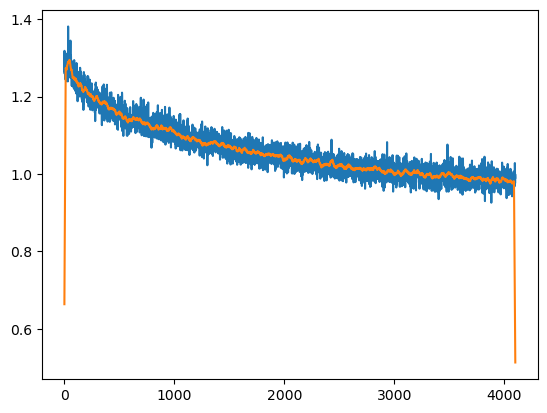

4101it [24:19,  2.98it/s]

English:
[CLS]Reports also indicate that Israel recently granted a license for the abortifacient, [UNK]230[UNK] and that Exelgyn also registered the drug in non[UNK]EU countries Switzerland and Russia.[SEP]

Target:
[CLS]Berichte zeigen auch, dass Israel vor kurzem eine Lizenz für das Abtreibungsmittel gewährt, [UNK]230[UNK] und dass Exelgyn registriert auch das Medikament in Nicht[UNK]EU[UNK]Ländern Schweiz und Russland.[SEP]

Predicted:
[CLS]Rerecht  duigtn duch  dass dnrael uon 2urzem uine nösenz uür dis Euereibungsfittel uesährt  u20[UNK]  und dis  dupkle  iegistriert wufh iis Eadiuament un deckt[UNK]Sx[UNK].ändern uchueiz und Eessland [SEP]
norms: enc=0.17505541631552343    dec=0.22383102482434275


4150it [24:35,  3.15it/s]

loss=0.9680036306381226


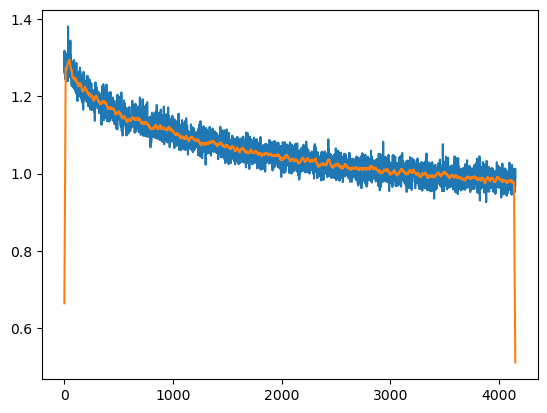

4151it [24:36,  2.79it/s]

English:
[CLS]The success of such an initiative would be a harbinger of new developments for cooperation between Russia and Africa, even at the geostrategic level, but we will only see these hypothetical scenarios in the future.[SEP]

Target:
[CLS]Der Erfolg einer solchen Initiative wäre ein Vorbote neuer Entwicklungen für die Zusammenarbeit zwischen Russland und Afrika, auch auf geostrategischer Ebene, aber wir werden diese hypothetischen Szenarien nur in Zukunft sehen.[SEP]

Predicted:
[CLS]Dir Srfolg diner golchen Bnttiativenwure einewerset suiue  Bntwicklungsn uür diesUukammenarbeit uuischen dussland und dnrika  dbfh wnf drnpsratitieche  Bnene  dber dir worden diese Aesothekische  Rtenerion eir an dukunft seien.[SEP]
norms: enc=0.1764046810111589    dec=0.22515020794594925


4200it [24:52,  3.19it/s]

loss=0.979954183101654


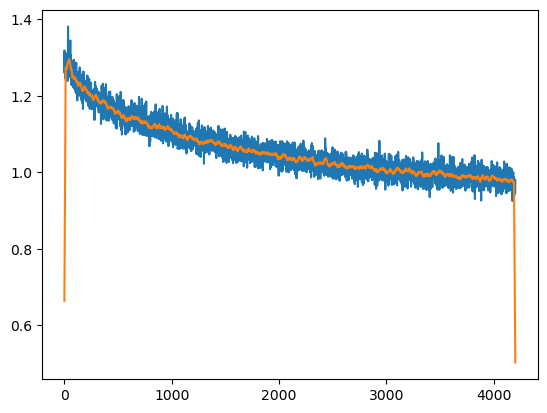

4201it [24:52,  2.66it/s]

English:
[CLS]But the two are among the top five most burdensome diseases in the United States, and two studies presented at the American Heart Association[UNK]s Scientific Sessions 2014 this weekend examined the ties between them.[SEP]

Target:
[CLS]Aber die beiden gehören zu den fünf am schwersten belastenden Krankheiten in den Vereinigten Staaten, und zwei Studien, die dieses Wochenende an den Scientific Sessions 2014 der American Heart Association vorgestellt wurden, untersuchten die Verbindungen zwischen ihnen.[SEP]

Predicted:
[CLS]Aber die Aeiden wrsertn dw den brnf Jnewthwareten deiisten en uoinkeeiten in den Uereinigten Staaten  dnd dwei Jtadeen  die die e  Jochen nde bu den 1thencenieaMtrtion  2010 eer Mnerikan Merdt sssiciation bergestellt wurden. bmderstcht.n.die Mererndung n zuischen dhnen.[SEP]
norms: enc=0.0898462540043925    dec=0.19691663296863104


4250it [25:08,  3.45it/s]

loss=0.9652892351150513


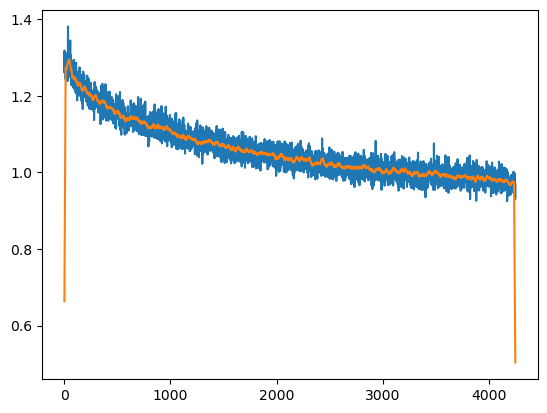

4251it [25:09,  3.11it/s]

English:
[CLS]Regardless of whether you are a size two or a size twenty[UNK]two, you can begin to build your self[UNK]confidence by letting go of unrealistic beauty standards.[SEP]

Target:
[CLS]Unabhängig davon, ob Sie eine Größe zwei sind oder eine Größe zweiundzwanzig, können Sie beginnen, Ihr Selbstvertrauen aufzubauen, indem Sie unrealistische Schönheitsstandards loslassen.[SEP]

Predicted:
[CLS]Unabhängig vuvon, wb eie eine geuße vuii Stnd,wder sine geuße vuii ndewanzig  sönnen Sie sesinnen, ahreBckbst ertragen zuf ubauen, andem Sie snsealistisch  Bthunheit btandards seswessen.[SEP]
norms: enc=0.3049377746988059    dec=0.23195937183857646


4300it [25:24,  3.40it/s]

loss=0.9975919723510742


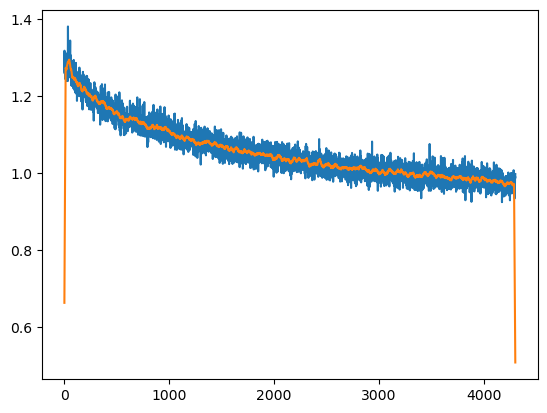

4301it [25:24,  3.00it/s]

English:
[CLS]He offered you a final demonstration that it is impossible to kill God[UNK]s Son[UNK] nor can his life in any way be changed by sin and evil, malice, fear or death.[SEP]

Target:
[CLS]Er hat dir eine endgültige Demonstration geboten, dass es unmöglich ist, GOTTES SOHN zu töten[UNK] noch kann sein Leben in irgendeiner Weise durch Sünde und das Übel, Böswilligkeit, Angst oder Tod verändert werden.[SEP]

Predicted:
[CLS]Er sat eie eine giglültige Sisokstration degoren, diss es knsöglich sst, doTT   ShMR Su suten, Sich nenn eiin keben en dhgendeiner Seise eerch diddenund Ses gber  deseirdig eit  dlgst vder ead zorlndert hirden.[SEP]
norms: enc=0.1060358290183417    dec=0.22487805606864317


4350it [25:40,  3.40it/s]

loss=0.9463385939598083


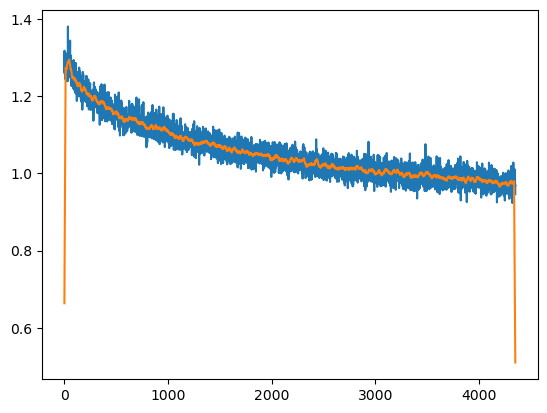

4351it [25:40,  3.00it/s]

English:
[CLS]Do you believe that the quality of the content you've created for a week is the best it can be by mobilizing hundreds to thousands of people, with a lot of capital and equipment?[SEP]

Target:
[CLS]Glauben Sie, dass die Qualität der Inhalte, die Sie für eine Woche erstellt haben, die beste ist, die es sein kann, indem Sie Hunderte bis Tausende von Menschen mit viel Kapital und Ausrüstung mobilisieren?[SEP]

Predicted:
[CLS]Klaubtn Sie  dass die Fualität der Intalte  die iie eür eine Meche brhtellt haben, dae MeitehFnt, dae Mi mcin wönn, dn em Sie manderte ves zeusende von Minschen ait deelegopitelivnd dnswüstung dirilisiertn [SEP]
norms: enc=0.1545196997684457    dec=0.2304297703265985


4400it [25:55,  3.26it/s]

loss=0.9779970645904541


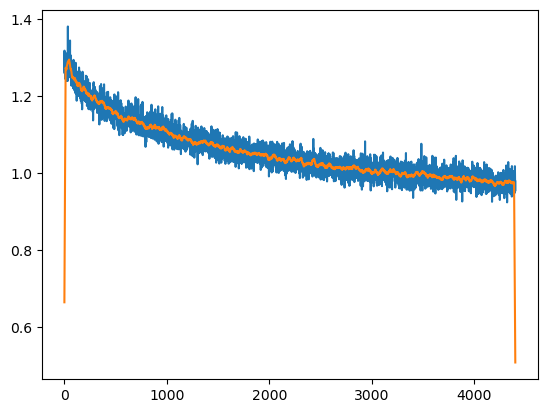

4401it [25:56,  2.88it/s]

English:
[CLS]What we want here in Spain is not much[UNK] it[UNK]s the same thing people in many other places in Europe and around the world want[UNK] clear laws that state what is allowed and what isn[UNK]t.[SEP]

Target:
[CLS]Was wir hier in Spanien wollen, ist nicht viel[UNK] es ist dasselbe, was die Menschen an vielen anderen Orten in Europa und auf der ganzen Welt wollen[UNK] klare Gesetze, die angeben, was erlaubt ist und was nicht.[SEP]

Predicted:
[CLS]Was wir aaer in daanien nalltn  dst dicht deel  ds ist nas elbe  was die Menschen iu deelen Snderen Srten in duropa und dlf der Sanzen Welt galltn  Seas  sesctze  die iu esln  das is aubt.hst..nd was iicht [SEP]
norms: enc=0.2739774628503845    dec=0.2614027554832878


4450it [26:11,  3.10it/s]

loss=0.9470751881599426


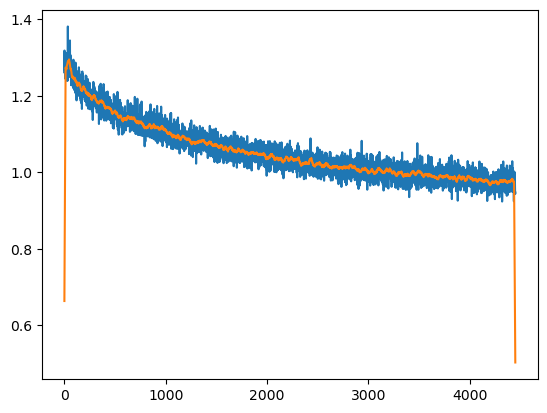

4451it [26:12,  2.94it/s]

English:
[CLS]Maria do C[UNK]u Patr[UNK]o Neves [UNK]PPE[UNK], in writing. [UNK] [UNK]PT[UNK] I supported this resolution as I believe that the fight for human rights is crucial.[SEP]

Target:
[CLS]Maria do C[UNK]u Patr[UNK]o Neves [UNK]PPE[UNK], schriftlich. [UNK] [UNK]PT[UNK] Ich habe diese Entschließung unterstützt, da ich der Ansicht bin, dass der Kampf für Menschenrechte äußerst wichtig ist.[SEP]

Predicted:
[CLS]Maria Per[UNK]aPn[UNK]rrri r[UNK]eter [UNK] a[UNK][UNK], dahrietlich  [UNK] IIa[UNK] Ich habe diese Antscheießung dnter tützt, disdch din Putacht des, des  dir Pompf für denschen echte inßertt werhtig ist.[SEP]
norms: enc=0.10836924721735094    dec=0.2214515577141143


4500it [26:29,  3.18it/s]

loss=0.9772972464561462


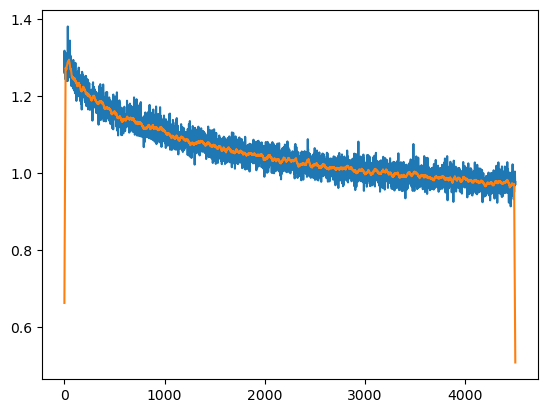

4501it [26:30,  2.92it/s]

English:
[CLS]And not to mention the kids themselves trying to find a place in the world while one wants to be with nature while the other wants to be more social and open with the world.[SEP]

Target:
[CLS]Ganz zu schweigen von den kindern selbst, die versuchen, einen platz in der welt zu finden, während einer mit der natur zusammen sein möchte, während der andere sozialer und offener mit der welt sein will.[SEP]

Predicted:
[CLS]Uenz nu eahrirgen mon eer Mlndern eoibst  dee eorsuchen  einen aranz zn der Welt zu sinden, dehrend diner diltder gacur zu ammenzuein wuchte  dirrend der lnderenueliale  and sffene  zit der gelt ziin.kürl.[SEP]
norms: enc=0.1473466783299181    dec=0.2482471872021157


4550it [26:45,  3.34it/s]

loss=1.017116904258728


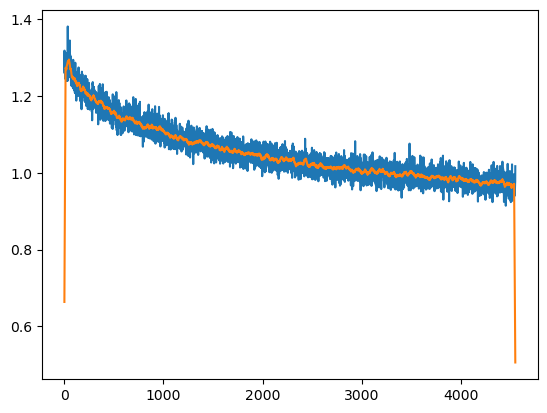

4551it [26:46,  3.12it/s]

English:
[CLS]However, reflecting back on the first 2 decades of his career he has begun to question a number of aspects of nutrition and dietetic practice.[SEP]

Target:
[CLS]In Rückschau auf die ersten 2[UNK]Jahrzehnte seiner Karriere hat er jedoch begonnen, eine Reihe von Aspekten der Ernährung und der diätetischen Praxis in Frage zu stellen.[SEP]

Predicted:
[CLS]An deckgthafseuf dee ersten 2 jahreehnte hiiner eottiere hab ei eedoch eeronnen, dine Peihe von Pnpekte  uer Prdährung vnd der Prgt negchen Paoxis zn drage zu btallen.[SEP]
norms: enc=0.269600919210911    dec=0.25302499189732247


4600it [27:02,  3.03it/s]

loss=0.9609982371330261


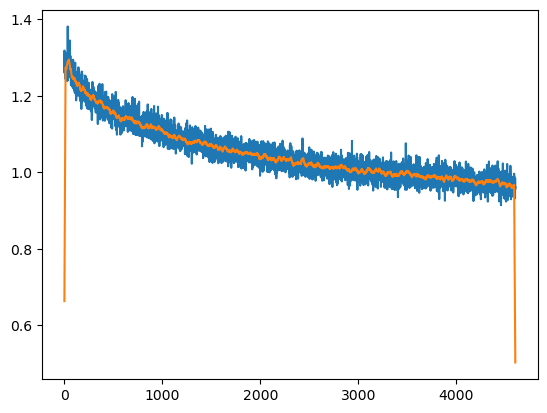

4601it [27:02,  2.79it/s]

English:
[CLS]The major issue is that using these protocols, along with a similar protocol known as NetBios, requires administrators to open ports 339 and 445.[SEP]

Target:
[CLS]Das Hauptproblem besteht aber darin, dass die Verwendung dieser Protokolle zusammen mit einem ähnlichen Protokoll, das als NetBios bekannt ist, erfordert, dass die Administratoren die Ports 339 und 445 öffnen müssen.[SEP]

Predicted:
[CLS]Dis Maustzroblem iesteht duer aisan, dass diesMereendung deeser Rribekoll  nu ammen mit einem ahnlichen Arojokoll  uas sul 1auzol  uesannt ust, uisoldert  uas  die Arrinistratiren uee Rrltu u   und 15  nffeet.wüssen.[SEP]
norms: enc=0.3142039922069658    dec=0.24017839588123105


4650it [27:18,  2.80it/s]

loss=0.9538542628288269


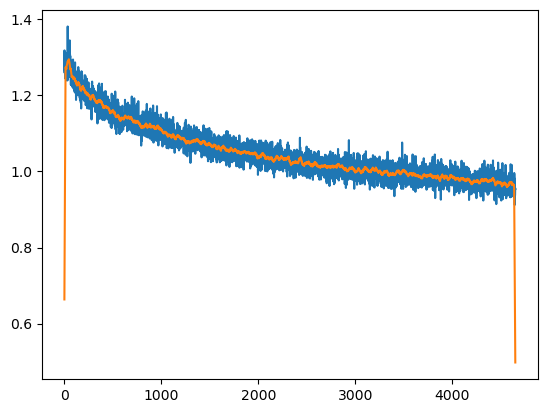

4651it [27:18,  2.73it/s]

English:
[CLS]While most of us have little control over those discussions, there is one health care topic that we can control[UNK] what we talk about with our doctor.[SEP]

Target:
[CLS]Während die meisten von uns kaum Kontrolle über diese Diskussionen haben, gibt es ein Gesundheitsthema, das wir kontrollieren können[UNK] worüber wir mit unserem Arzt sprechen.[SEP]

Predicted:
[CLS]Während Siesmeisten von uns honf eontrolle hber diese Kinkussionen haben, wibt es kineMehcndheitssaerat das wir kömtrollieren,können, Wilüber dir kit dnseren Kutt gerechen.[SEP]
norms: enc=0.27402443058517756    dec=0.22279772603090414


4700it [27:34,  3.17it/s]

loss=0.9477350115776062


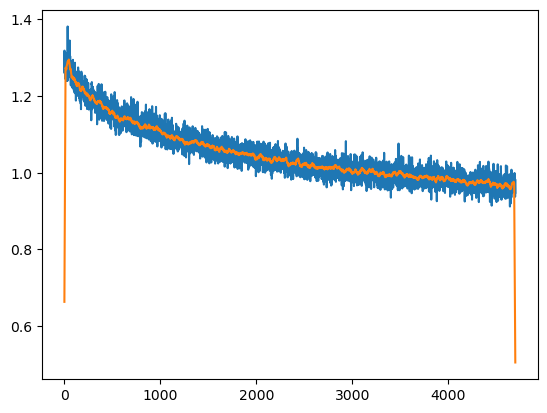

4701it [27:34,  2.93it/s]

English:
[CLS]A lot of us who are in our early 60s or early 70s want to be near our grandchildren and near our children, and so that[UNK]s a very normal human instinct and a good one.[SEP]

Target:
[CLS]Viele von uns, die Anfang 60 oder Anfang 70 sind, möchten in der Nähe unserer Enkelkinder und in der Nähe unserer Kinder sein, und das ist ein sehr normaler menschlicher Instinkt und ein guter.[SEP]

Predicted:
[CLS]Eoele von uns  wie euzongsa0 uder entang u  uind  uüchten Sn uer Lahe underer Srtelsrndur und eh eer Lahe enserer Sonder eein, wnd eas ist einesehr kotmales Sonschliches Snttatkt.and einesetes [SEP]
norms: enc=0.13637202979139437    dec=0.22328563410196894


4750it [27:50,  3.17it/s]

loss=0.9998489022254944


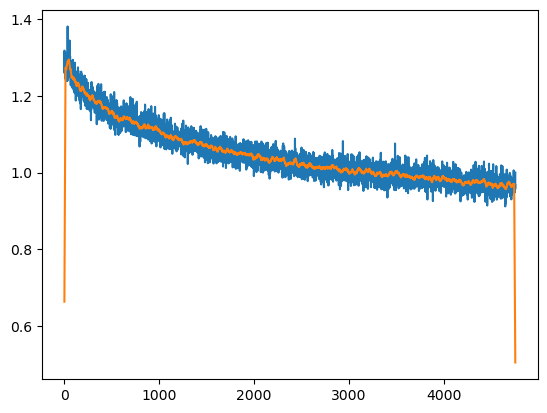

4751it [27:50,  2.99it/s]

English:
[CLS]Subsequently, another video entitled [UNK]C O D O H[UNK] was presented, in which three people were asked why they supported the open debate about the HC.[SEP]

Target:
[CLS]Anschließend wurde ein weiteres Video mit dem Titel [UNK]C O D O H[UNK] vorgeführt, in welchem drei Leute dazu befragt wurden, warum sie die offene Debatte über den HC unterstützten.[SEP]

Predicted:
[CLS]Dbgchließend sarde arnegeiteres Gedeo [UNK]et der "etel [UNK] a[UNK]pCa[UNK]rCa Cor esuhrt, wn denchen LeiitJebtengeru geiragt,wurde,, war m die die Sffens Sematte sber din SaChnterstütze n.[SEP]
norms: enc=0.2343453888723123    dec=0.2520117216343566


4800it [28:06,  3.17it/s]

loss=0.9817862510681152


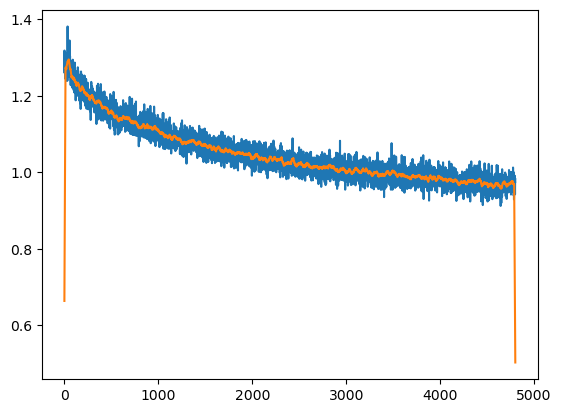

4801it [28:06,  2.95it/s]

English:
[CLS]On conclusion of the negotiations, I believe that we will be able to reach an agreement which will fulfill the vision of President Bush[UNK] two states for two peoples.[SEP]

Target:
[CLS]Am Abschluss der Verhandlungen werden wir [UNK] so glaube ich [UNK] in der Lage sein, ein Abkommen zu erzielen, das die Vision Präsident Bushs erfüllen wird[UNK] zwei Staaten für zwei Völker.[SEP]

Predicted:
[CLS]Au Enechnuss wer Berbaldlungen wurden wir a aonwlaubenich,e wc den Bage,sein, dineBneommen zu brräelen, aes wie Beeion vaosident Basi  aifolltn word, duei Mtaaten für dwei Melkerr[SEP]
norms: enc=0.5025841495848116    dec=0.27646166834769165


4850it [28:22,  3.12it/s]

loss=0.9603084921836853


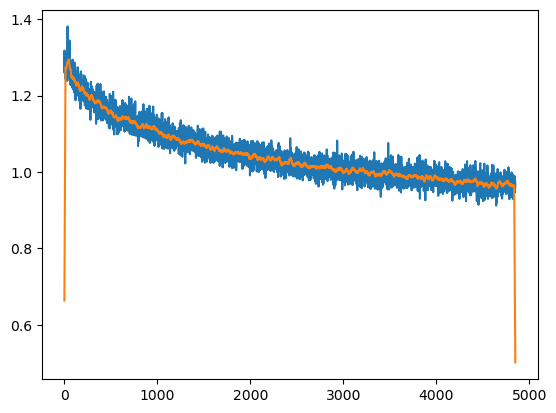

4851it [28:22,  2.84it/s]

English:
[CLS]'Unfortunately, the latest update also underlines how threats to biodiversity continue to undermine some of society's most important goals, including food security.[SEP]

Target:
[CLS]Leider wird in der jüngsten Aktualisierung auch betont, wie die Bedrohungen für die biologische Vielfalt einige der wichtigsten Ziele der Gesellschaft, einschließlich der Ernährungssicherheit, weiterhin untergraben.[SEP]

Predicted:
[CLS]"eider serd dh der Eedgsten Futielisierung dufh desrne  dee die Eedeohung n dür die Eellogische Reslfalt vinegesder Eichtigsten Feele der Ersellschaft  dinschließlich der Erfährung sytherheit  diilerhin snser raben.[SEP]
norms: enc=0.2527218025996463    dec=0.25605275013639245


4900it [28:38,  2.95it/s]

loss=0.955452024936676


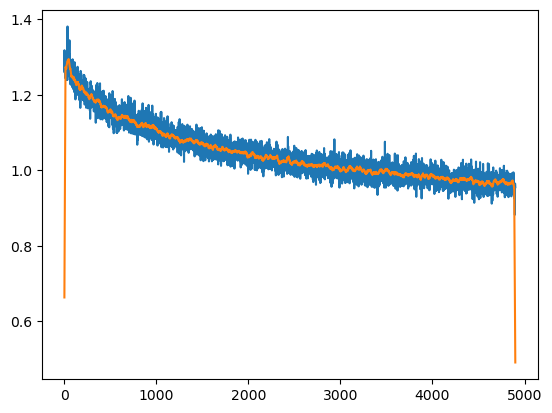

4901it [28:39,  2.70it/s]

English:
[CLS]I heard one deputy commissioner of education say some years ago that if we had the same class sizes as the national average, we would save over [UNK]1 billion per year.[SEP]

Target:
[CLS]Ich habe gehört, dass ein stellvertretender Bildungsbeauftragter vor einigen Jahren gesagt hat, dass wir, wenn wir die gleichen Klassengrößen hätten wie der nationale Durchschnitt, über 1 Milliarde US[UNK]Dollar pro Jahr sparen würden.[SEP]

Predicted:
[CLS]Ich habe eesört, dass einesearltersrater er Aeld ngssermttrag e  sen dinegen Jahren wescgt hat, dass wir  dinn sir die Aleiche  Soassen eußen aatten,[UNK]ae dir SetionalenJirchschnitt  dber 10JilliordenJn[UNK]Sollar gro Jahr herren.würde..[SEP]
norms: enc=0.23408615359498022    dec=0.22901047616888834


4950it [28:56,  2.58it/s]

loss=0.9573265910148621


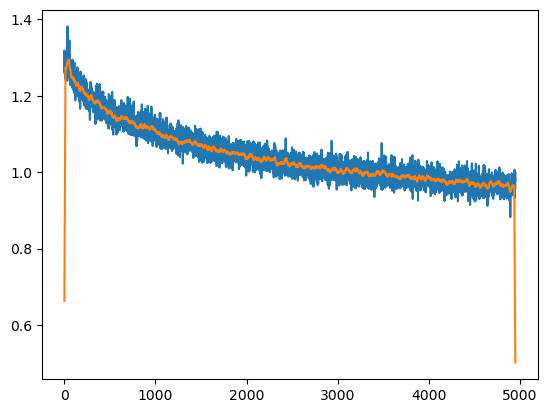

4951it [28:57,  2.20it/s]

English:
[CLS]It isn[UNK]t the first time we want to share some interesting ways to organize your bathroom and a bunch of creative bathroom storage ideas with you.[SEP]

Target:
[CLS]Es ist nicht das erste mal möchten wir gemeinsam einige interessante Möglichkeiten, sich zu organisieren Ihr Badezimmer und einer Reihe von kreativen Badezimmer storage Ideen mit Ihnen.[SEP]

Predicted:
[CLS]Es ist dicht der erste Mal iighten,wir ueseinsam mrnege snternssinte Siglichkeit n  doch uu shganisieren uhreGeuesemmer und wine  veise von Ioiativen Senenimmernzealbnenzheen.zit Ihnen.[SEP]
norms: enc=0.11370548717758394    dec=0.24544635393770906


5000it [29:17,  2.73it/s]

loss=0.9298440217971802


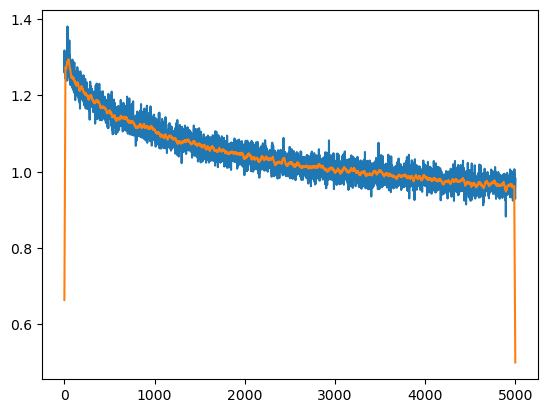

5001it [29:18,  2.47it/s]

English:
[CLS]As you can see, I don[UNK]t think any one problem or event will cause the collapse of the American empire, but a number of separate but interlocking events and issues.[SEP]

Target:
[CLS]Wie sie sehen, glaube ich nicht, dass ein problem oder ein ereignis den zusammenbruch des amerikanischen imperiums verursachen wird, sondern eine reihe separater, aber ineinandergreifender ereignisse und probleme.[SEP]

Predicted:
[CLS]Wie Sie nihen, diaube ich,nicht  dass einiproblem ider einepinignis ierkbwkämmenaruch ier enerikaneschen snmersams sersrsachen kerd, aondern aine aelce vtiarate   uber en inander eönfen e  uisignesse ind drobleme.[SEP]
norms: enc=0.14505457828846996    dec=0.23370320535222064


5050it [29:38,  2.33it/s]

loss=0.9564598202705383


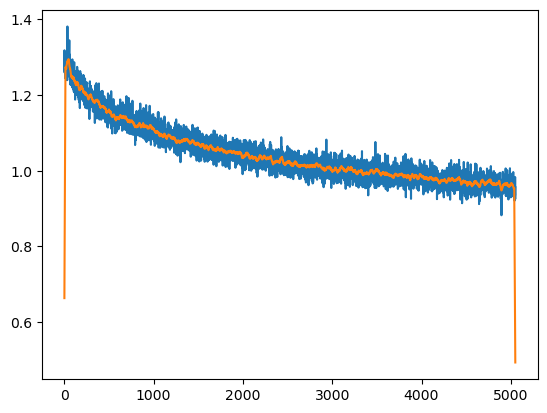

5051it [29:39,  2.06it/s]

English:
[CLS]This, however, does not mean that Ecuador is asked to lower its current tariffs and measures to protect certain sectors before the entry into force of the EU[UNK]Ecuador Free Trade Agreement.[SEP]

Target:
[CLS]Dies bedeutet jedoch nicht, dass Ecuador aufgefordert wird, seine derzeitig geltenden Zölle und Maßnahmen zum Schutz bestimmter Wirtschaftszweige vor Inkrafttreten des Freihandelsabkommens EU[UNK]Ecuador herabzusetzen.[SEP]

Predicted:
[CLS]Dies iedeutet,nedoch nicht, dass dUhidor dus erordert wurd, doite Eer eitigeueneenden uuglenund darnahmen iu  Echutz deitimmte  Eestschaftsweeitebdon dnflaftseefan ver Eoiiwandels bkommens znR.bksror.zargusifttztn.[SEP]
norms: enc=0.25136171730297    dec=0.23399557543352698


5100it [29:59,  2.10it/s]

loss=0.9667198657989502


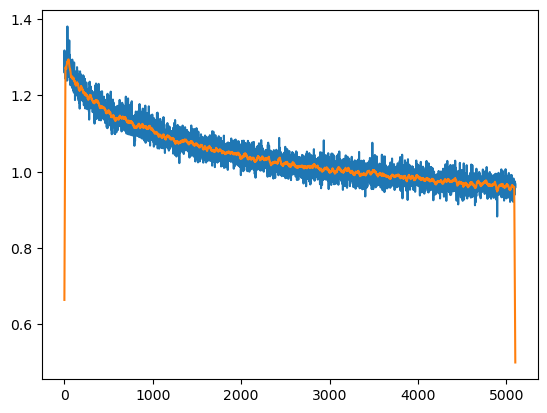

5101it [30:00,  2.07it/s]

English:
[CLS]previously i used this product for my husband, he is now 45. i myself only suggested him for 50 mg, after so long time we both are happy in sex life.[SEP]

Target:
[CLS]Früher habe ich dieses Produkt für meinen Mann verwendet, er ist jetzt 45. Ich selbst habe ihm nur 50 mg vorgeschlagen, nach so langer Zeit sind wir beide glücklich im Sexualleben.[SEP]

Predicted:
[CLS]Brüher iate ich iiese  Mrobukt iür meine  Sann iersendet, as int netzt i000Mnh nahbst nate ncn nir e00Ji ienzeschlagen, aach ie vange  aeit iond iie ier e ieücklich in Jcpualpeben.[SEP]
norms: enc=0.24739275451734724    dec=0.2555606405882395


5150it [30:19,  2.30it/s]

loss=0.9832597970962524


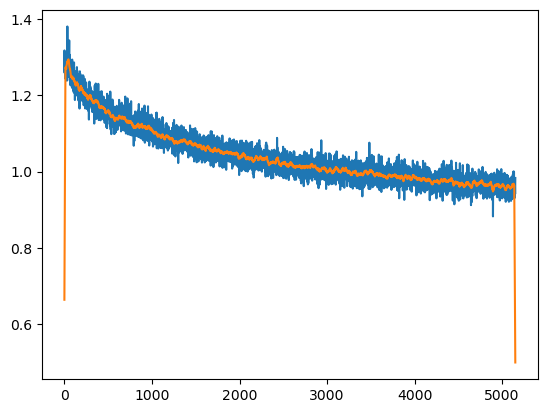

5151it [30:20,  2.32it/s]

English:
[CLS]And since it would have taken us 1 hour to walk from Chandni Chowk to Paharganj, the correct price should be around 90 rupees, not much of a difference from what we paid.[UNK][SEP]

Target:
[CLS]Und da es uns 1 Stunde gedauert hätte von Chandni Chowk nach Paharganj zu gehen, der richtige Preis sollte rund 90 Rupien, nicht viel Unterschied von dem, was wir bezahlt haben.[UNK][SEP]

Predicted:
[CLS]Und desds wns a9wtundenwegacert watte,wor dhirceeneaansoaich daramaaniawu dewen, win dechtig  Prois fe lte wend u  Pen e   wicht zeel wnterschied zer uer  was eir eerahle haben.[UNK][SEP]
norms: enc=0.09579755637852422    dec=0.2344925727548376


5200it [30:40,  2.46it/s]

loss=0.9378393292427063


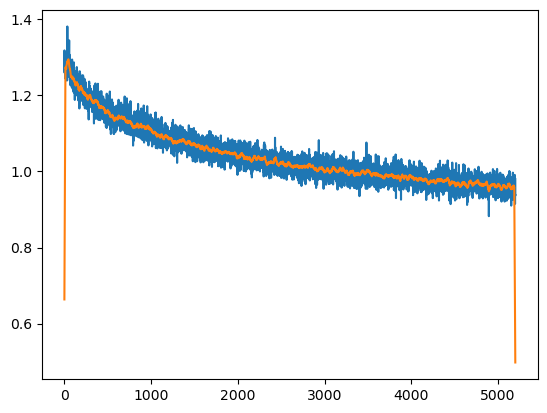

5201it [30:40,  2.35it/s]

English:
[CLS]This is largely due to the optimal exchange rate but, above all, to the fact that many European and international destinations have more or less failed due to terror and other events.[SEP]

Target:
[CLS]Dies ist im Wesentlichen dem optimalen Wechselkurs zu verdanken, aber vor allem auch der Tatsache, dass viele europäische und internationale Destinationen aufgrund von Terror und anderen Ereignissen mehr oder weniger ausgefallen sind.[SEP]

Predicted:
[CLS]Dies ist enmBesentlichen der Eftimilen Merhselnrrs au sersinken, dber dir allem aufh din Eegsache, dass diele Muropäische und anternationale Eemiinationen auf eund don Melroriund dndere  Mngignissen behr ader aeiiger alfgesüllen hind.[SEP]
norms: enc=0.3907614117418686    dec=0.24477239017872554


5250it [31:00,  2.79it/s]

loss=0.9301643967628479


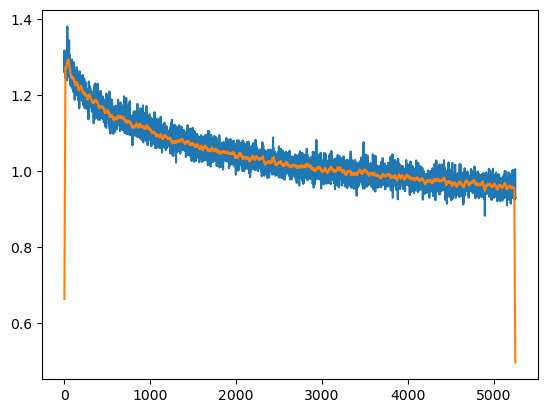

5251it [31:01,  2.58it/s]

English:
[CLS]Both parties know that overcapacity is a global and structural problem that requires a global and long term solution such as the creation of a Global Aluminium Forum within G20.[SEP]

Target:
[CLS]Beide Parteien wissen, dass Überkapazitäten ein globales und strukturelles Problem sind, die eine globale und langfristige Lösung erfordert, wie die Schaffung eines globalen Aluminiumforums innerhalb der G20.[SEP]

Predicted:
[CLS]Beide wrrteien weesen, dass ebersanazität n uinewrobaler Pnd aoaakturelles Problem iond, dae iine srobale And iongfristige Risung iifoldern  dee die Aihwffung dines irobalen Sutmingemsermm  in erhalb des Se0 [SEP]
norms: enc=0.13446214101088552    dec=0.22887998610560684


5300it [31:21,  2.02it/s]

loss=0.9524228572845459


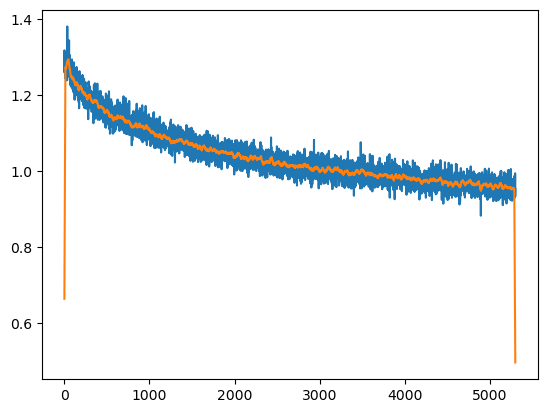

5301it [31:21,  2.00it/s]

English:
[CLS]What sources of accurate information could you recommend where we can find true history so we may start learning the real history of mankind [UNK] of Creation?[SEP]

Target:
[CLS]Welche Quellen korrekter Information könntest du empfehlen, wo wir die wahre Geschichte finden können, sodass wir anfangen könnten, die wirkliche Geschichte der Menschheit und der Schöpfung zu erfahren?[SEP]

Predicted:
[CLS]Welche Auellen iönrekte  Knformationewönnee t du dipfehlen, we dir die Kihre Seschichte dünden können, wo ass wir du angen [UNK]önneen  wae dirklich  Eeschichte [UNK]er Kenscheeit [UNK]nd Ker Kthwpfeng [UNK]u srhühren?[SEP]
norms: enc=0.15350328055396797    dec=0.24415975739008403


5350it [31:41,  2.44it/s]

loss=0.9741007089614868


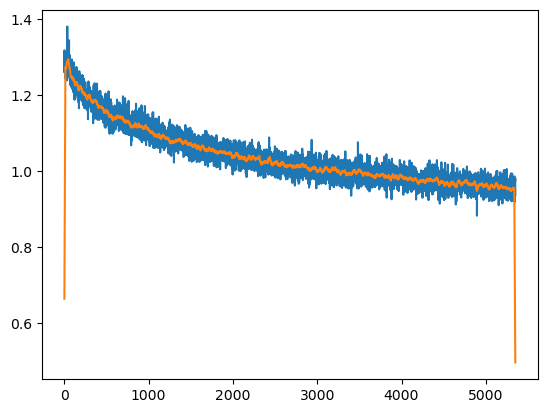

5351it [31:42,  2.21it/s]

English:
[CLS]Regulation [UNK]EC[UNK] No 460[UNK]2004 is therefore to be incorporated into the Agreement in order to allow for the full participation of the EFTA States in the European Network and Information Security Agency,[SEP]

Target:
[CLS]Die Verordnung [UNK]EG[UNK] Nr. 460[UNK]2004 ist daher in das Abkommen aufzunehmen, um die uneingeschränkte Beteiligung der EFTA[UNK]Staaten an der Europäischen Agentur für Netz[UNK] und Informationssicherheit zu gewährleisten [UNK][SEP]

Predicted:
[CLS]Rie Uererdnung d2UF ie. 262  006 int deser dn des Eusommen duf ubehmen, dm die Engrngeschränkte Eedeiligung der EUFA  taatsn uu der EUropäischen Unentur uür dauzw und dntormationeftcherheit zu bewährleisten,[UNK][SEP]
norms: enc=0.1841301335196773    dec=0.2256833999924774


5400it [32:01,  2.38it/s]

loss=0.9723795652389526


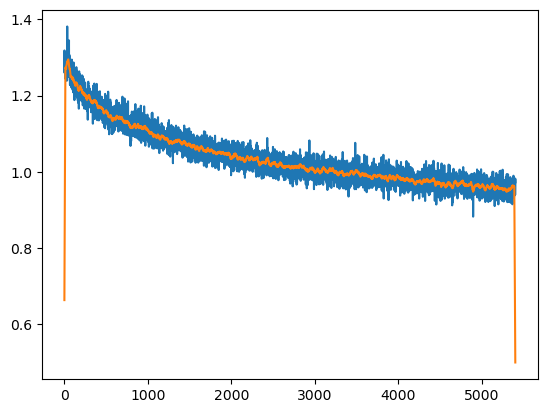

5401it [32:02,  2.26it/s]

English:
[CLS]I chose Georgia because many of its environmental and media problems are similar to those confronting other post[UNK]Soviet countries nearly 30 years after independence.[SEP]

Target:
[CLS]Ich habe mich für Georgien entschieden, weil viele seiner Umwelt[UNK] und Medienprobleme denen ähneln, mit denen andere postsowjetische Länder fast 30 Jahre nach der Unabhängigkeit konfrontiert sind.[SEP]

Predicted:
[CLS]Ich kabe dech aür desrgien urtschieden  deil diele dixner Snselt Sund dinien rojleme iir n ihnllt  dut denen sudere Srsistreetische Sänder iüst a0 Jahre aich Ser Entbhängigkeit bonzrontiert wind.[SEP]
norms: enc=0.1348041152747369    dec=0.2216638789952321


5450it [32:21,  2.59it/s]

loss=0.9841532111167908


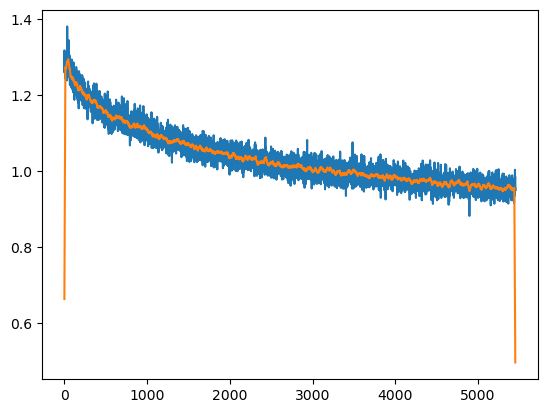

5451it [32:22,  2.39it/s]

English:
[CLS][UNK]Instead of buying a car that[UNK]s been driven for one year, consumers can buy the new version for just a few thousand dollars more and take advantage of the latest and greatest technological and safety features.[SEP]

Target:
[CLS][UNK]Statt ein Auto zu kaufen, vorangetrieben wurde für ein Jahr, können die Verbraucher kaufen sich die neue version nur für ein paar tausend Dollar mehr und profitieren Sie von den neuesten und größten technologischen und Sicherheits[UNK]features.[SEP]

Predicted:
[CLS][UNK]Statt einewuto zu doufen, uon ugehrieben uirde,uür dineJahr  uenntn die Merbraucher donmen uoch aie eeuenuerscon dur eür dineuaar Jausend Jillar uahr und drofetieren uie don der beuenten Tnd aroßten Technilogischen Ind atcherheitss.astures.[SEP]
norms: enc=0.11887970281979876    dec=0.21142325916073845


5500it [32:41,  2.81it/s]

loss=0.9503013491630554


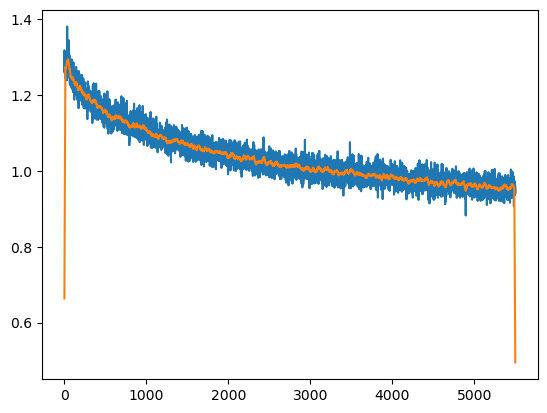

5501it [32:42,  2.81it/s]

English:
[CLS]It is the first time in many years that this form of nonviolent civil rights action has registered so profoundly on the agenda of Israel[UNK]s political elite.[SEP]

Target:
[CLS]Es ist das erste Mal seit vielen Jahren, dass diese Form der gewaltfreien Bürgerrechtsklage so tief greifend auf die Agenda der politischen Elite Israels gesetzt wurde.[SEP]

Predicted:
[CLS]Es ist dis eiste Mal,deit dielen Jahren  diss die e Iorm der Iesiltioeih  Ierger echtsroasenielsref ieonfen  iuf dee Inenta der Iolitischen Iiite inrael  iesphzt werden[SEP]
norms: enc=0.2018021142205766    dec=0.2489736192390266


5550it [33:02,  2.43it/s]

loss=0.9809256196022034


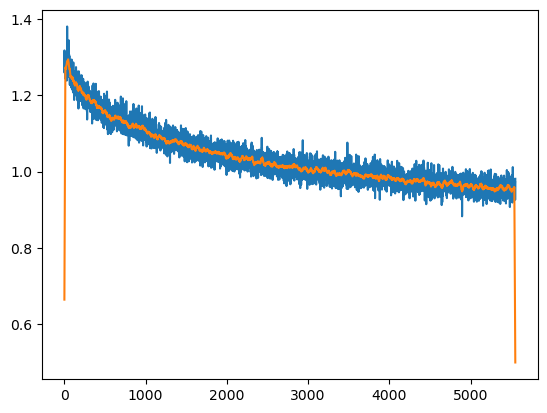

5551it [33:02,  2.38it/s]

English:
[CLS]You are going to have something to be smug about on social media for a few days [UNK][UNK]guilty[UNK], but after that, you will be no more the profound or inspired human that you were before.[SEP]

Target:
[CLS]Du wirst etwas haben, über das du ein paar Tage in den sozialen Medien herumschnüffeln kannst [UNK][UNK]guilty[UNK], aber danach wirst du nicht mehr der tiefgründige oder inspirierte Mensch sein, der du zuvor warst.[SEP]

Predicted:
[CLS]Su birst eiwas maben, aber des eu binepaar Magenzn der Mczialen Modien zaram thritfenn,[UNK]ann,t,d  etndi[UNK], aber dasnch wardt du dicht dehr aan Mreferendege Mder dh piriere nMenschehein. din de mu or gartt.[SEP]
norms: enc=0.14178768146539353    dec=0.23024817244701568


5600it [33:22,  2.78it/s]

loss=0.9484090805053711


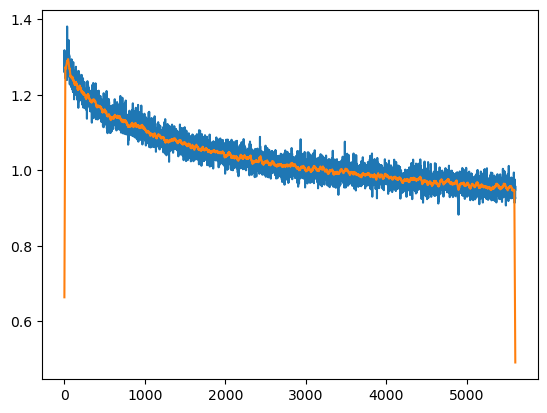

5601it [33:22,  2.66it/s]

English:
[CLS]This is not to say that it's not possible, but just that most of the people who could get results in seven days have already gotten results and gone to nibbana.[SEP]

Target:
[CLS]Das heißt nicht, dass so etwas nicht möglich wäre, sondern nur, dass die meisten Leute, die in sieben Tagen Ergebnisse erzielen können, bereits Ergebnisse erzielt haben und ins Nibbana eingegangen sind.[SEP]

Predicted:
[CLS]Dis ieißt nicht, dass di viwas mucht veglicheiire, dondern dur  dass die Beisten däute  die in decben Jagen drdebnisse urräeltn uönnen, ueveits drdebnis e uifäelt waben.und dn gBeveibe grngesengen wind.[SEP]
norms: enc=0.10803968820874768    dec=0.23650418098542955


5650it [33:42,  2.47it/s]

loss=0.9633665084838867


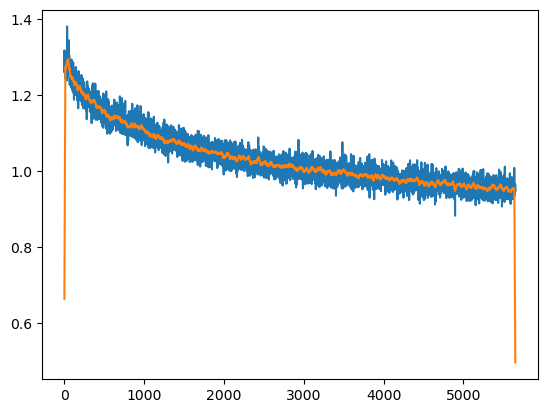

5651it [33:43,  2.08it/s]

English:
[CLS]Sony warned earlier this month about significant and serious reorganization changes coming this year, and now they're becoming a reality for many employees in the United States.[SEP]

Target:
[CLS]Sony gewarnt Anfang dieses Monats über erhebliche und gravierende Veränderungen der Reorganisation in diesem Jahr, und jetzt sind sie immer eine Realität für viele Mitarbeiter in den Vereinigten Staaten.[SEP]

Predicted:
[CLS]Sony wawintt wbfang dieser Modats eber disöbliche und eeöuidrtnde Eersnderungen ier Segkginisation vn eeesem Jahr  emd eedzt kind eic en er nin  geikität für diele aetgrbeiter un den Uereinigten Staaten.[SEP]
norms: enc=0.12904911731264282    dec=0.24453798621124756


5700it [34:03,  2.46it/s]

loss=0.9273787140846252


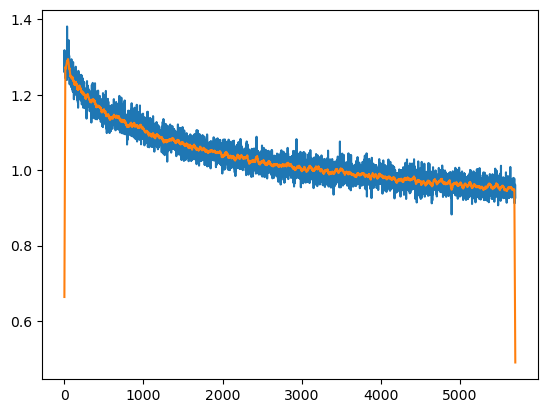

5701it [34:04,  2.24it/s]

English:
[CLS]In this case, it is very unlikely that the test will come to a wrong conclusion, so the test with 5,000 visitors can distinguish between the two offers.[SEP]

Target:
[CLS]In diesem Fall ist es unwahrscheinlich, dass der Test zu einem falschen Schluss kommt, sodass der Test mit 5.000 Besuchern eine Unterscheidung zwischen den beiden Angeboten ermöglicht.[SEP]

Predicted:
[CLS]In diesem Fall wst es ensahrscheinlich  dass eir Kext eu einer grsschen Kchrass domme, do ass dir Kext dit d0000 Uercchern zrnzngntersthiidung zuischen den beiden Mntrboten zrhögliche.[SEP]
norms: enc=0.1997969112837546    dec=0.23859962233226245


5750it [34:20,  3.19it/s]

loss=0.9559182524681091


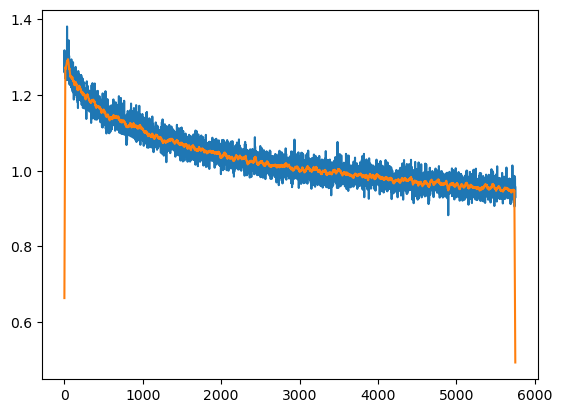

5751it [34:21,  2.89it/s]

English:
[CLS]We are convinced that free trade and the market economy benefit economic development and we are therefore, in principle, opposed to financial assistance for countries or regions.[SEP]

Target:
[CLS]Wir sind davon überzeugt, dass der freie Handel und die Marktwirtschaft die wirtschaftliche Entwicklung fördern, und deshalb sind wir grundsätzlich gegen eine finanzielle Unterstützung von Ländern und Regionen.[SEP]

Predicted:
[CLS]Wir sind dison aberzeugt, dass dir Fraie ueudelsund die Aeckepartschaft wee AirtschaftlichenArtwicklung uürdert  wnd wirhalb wind wir ueondlätzlich aemen dine grnanzielle Anterstützung fon Mendern znd Megienan [SEP]
norms: enc=0.17489444005093396    dec=0.2317135051086769


5800it [34:37,  2.78it/s]

loss=0.9734747409820557


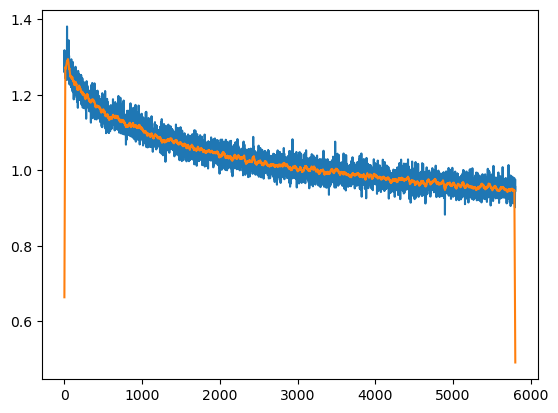

5801it [34:38,  2.57it/s]

English:
[CLS]A[UNK] The key questions for companies our size [UNK] and in the same incredibly privileged position we[UNK]ve found ourselves in [UNK] is how to develop relationships with the right partners at the right time.[SEP]

Target:
[CLS]A[UNK] Die wichtigsten Fragen für Unternehmen unserer Größe [UNK] und in derselben unglaublich privilegierten Position, in der wir uns befunden haben [UNK] sind die Frage, wie man zur richtigen Zeit Beziehungen zu den richtigen Partnern aufbauen kann.[SEP]

Predicted:
[CLS]A[UNK] Die Eirhtigsten Sragen iür dnternehmen undere  Peuße [UNK] und dn den elben Pndeaublichewrivalegierten Prsitione dn den wir dns aesigden haben,[UNK] died die Mragen die wan du  Vechtigen Zuit zesiehungen zu binkVechtigen Zrrteern zufgauen.wönn.[SEP]
norms: enc=0.2945638016697099    dec=0.24201901457470384


5850it [34:54,  2.96it/s]

loss=0.9384384155273438


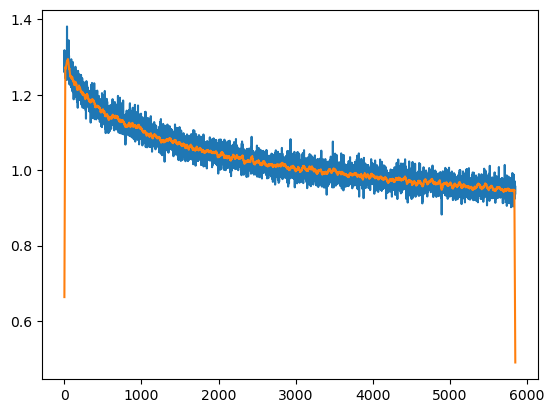

5851it [34:54,  2.75it/s]

English:
[CLS]Abortion would not be a legal, religious or political issue if people knew what a member of an eighth[UNK]density civilization told my mother many years ago[UNK][SEP]

Target:
[CLS]Abtreibung wäre kein rechtliches, religiöses oder politisches Problem, wenn die Menschen wüssten, was ein Mitglied einer Zivilisation der 'achten Dichte' meiner Mutter schon vor vielen Jahren einmal sagte[UNK][SEP]

Predicted:
[CLS]Üboraibung wire eein Wecht,iches  weaigiöses Wder erlitisches Mroblem  wann mie menschen einsten, das ein Monglied dines Meeilisation ver Msrhtun[UNK]Minhtersiehner Mutter eihen iorheielen Mahren erngal ecgten[SEP]
norms: enc=0.15448334373468214    dec=0.20819409727332386


5900it [35:10,  3.18it/s]

loss=0.9536637663841248


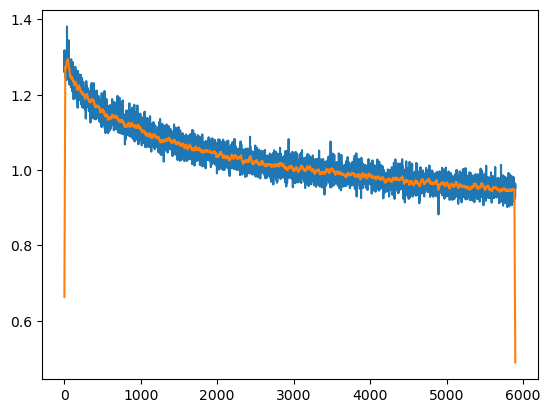

5901it [35:11,  2.85it/s]

English:
[CLS][UNK]19[UNK] Here again I could refer to Movimento Passe Livre in Brazil, whose adoption of a highly structured federated form in 2005 seems so far to have helped, and not hindered, its development.[SEP]

Target:
[CLS][UNK]19[UNK] Hier kann ich wiederum auf Movimento Passe Livre in Brasilien verweisen, deren Annahme einer hoch strukturierten föderativen Form im Jahr 2005 bis jetzt deren Entwicklung scheinbar gefördert und nicht behindert hat.[SEP]

Predicted:
[CLS][UNK]19[UNK] Eaer iann ich nirder m guf dinene t  arrsan2aneilsn deüsilien gerlengen, dan n Prfahmenvine  vohhzseaaktureerten Prreraliven uarm un Jahr 2011 nes zetzt nar n Pitsicklung uehlintar uesurdert und nicht aesandert.wat.[SEP]
norms: enc=0.14946607379820978    dec=0.22044941086957687


5950it [35:26,  3.26it/s]

loss=0.9322202205657959


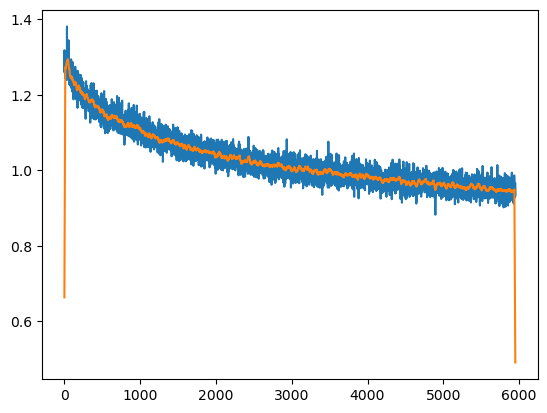

5951it [35:27,  2.90it/s]

English:
[CLS]But I wonder, if you were to ask 10 communication managers how in control they feel about their marketing message, if even half could honestly say they're in charge.[SEP]

Target:
[CLS]Aber ich frage mich, ob Sie 10 Kommunikationsmanager fragen würden, wie sie sich in der Kontrolle über ihre Marketing[UNK]Botschaft fühlen, wenn auch die Hälfte ehrlich gesagt sagen könnte, dass sie verantwortlich sind.[SEP]

Predicted:
[CLS]Aber ich wrage mich, wb Sie s0 vinmenikationstaßagemesüagen,werden, wie iie iich sn der Lontrolle sber Ihre Kußke ing Setschaft sühlen, wirn slch iie Kälfte dielich sesegt higtn könneen wiss iie iorsntwortlich sind.[SEP]
norms: enc=0.37744437046602136    dec=0.23796251516909317


6000it [35:42,  2.94it/s]

loss=0.930518388748169


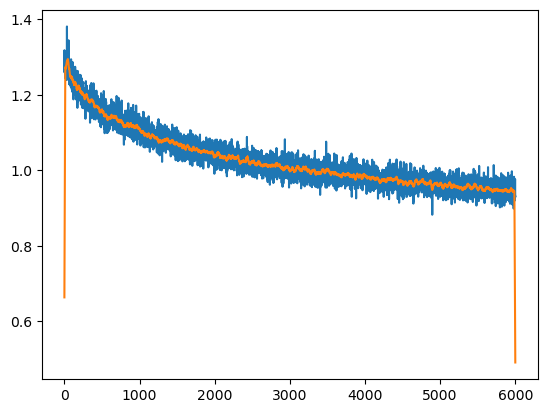

6001it [35:43,  2.72it/s]

English:
[CLS][UNK]2[UNK] There is an obvious difference between an original practice, such as early Christians receiving in the hand, and a later reintroduction of such a practice when it has long since become obsolete.[SEP]

Target:
[CLS][UNK]2[UNK] Es gibt einen offensichtlichen Unterschied zwischen einer ursprünglichen Praxis, wie die frühen Christen in die Hand empfingen und einer späteren Wiedereinführung einer solchen Praxis, als diese längst obsolet geworden war.[SEP]

Predicted:
[CLS][UNK]2[UNK] Es gibt eine  gffeneichtlichen Knterschied zwischen dinem Knsprünglichen Kroxis  dee die Kraher Khaisten un dee Käudeuipfanden und eine  deeteren Kerderhnnfahrung dine  selchen Proxis  dls eae e Kangeteud tlet sesorden iare[SEP]
norms: enc=0.1873973304144873    dec=0.23112158980198608


6050it [35:58,  2.95it/s]

loss=0.9355084300041199


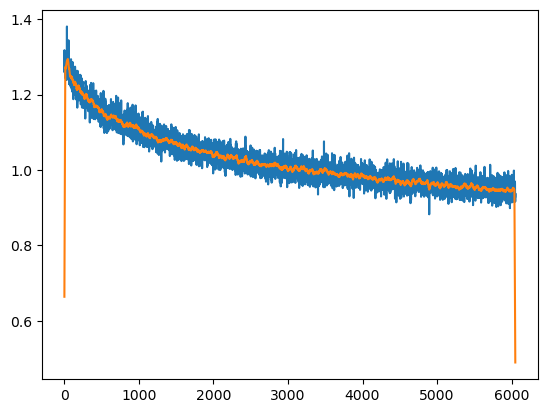

6051it [35:59,  2.80it/s]

English:
[CLS]He participates in the protests, not only to cover up his past, but perhaps also to make a business here again[UNK] to sell as many flags and flag shirts as possible.[SEP]

Target:
[CLS]Er nimmt an den Protesten teil, nicht nur um seine Vergangenheit zu verdecken, sondern vielleicht auch um hier wieder ein Geschäft zu machen[UNK] möglichst viele Flaggen und Flaggen[UNK]Shirts zu verkaufen.[SEP]

Predicted:
[CLS]Er vacmt du der Probesten neile aicht aur im eiine Berbengenheit zu sersinken, aondern aoel eicht euch in sier iie er zineseschäft zu sachen, ueglichet siele Lrüsgen und Brüggen Storte iu serwaufen.[SEP]
norms: enc=0.11001613801627651    dec=0.20189354810379564


6100it [36:14,  3.10it/s]

loss=0.946143627166748


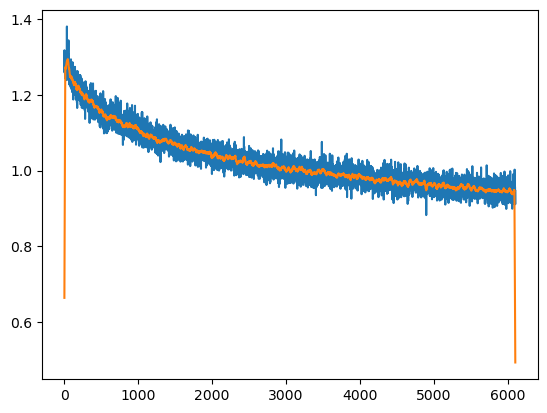

6101it [36:15,  2.75it/s]

English:
[CLS]Before this happens however, we would recommend testing it out on a much larger scale so that we can see that the reduction in blood pressure over six months can be achieved in the longer term and that it is cost effective."[SEP]

Target:
[CLS]Bevor dies jedoch geschieht, empfehlen wir Ihnen, es in einem viel größeren Maßstab zu testen, damit wir sehen können, dass die Reduzierung des Blutdrucks über sechs Monate längerfristig erreicht werden kann und dass es kostengünstig ist."[SEP]

Predicted:
[CLS]Vevor wieseiedoch wesahacht, wrpfehlen wir ennen  di ws diner geel großeren Paß tab zu suiten, wisit wir dehen können, wass diesPeguzierung der Peotsrucks wber deihs uonate ianger ristig wiseicht werden kann.und was  ws nemtenlenstig ist.[UNK][SEP]
norms: enc=0.14129556589077072    dec=0.23054871683697647


6150it [36:31,  3.04it/s]

loss=0.9899409413337708


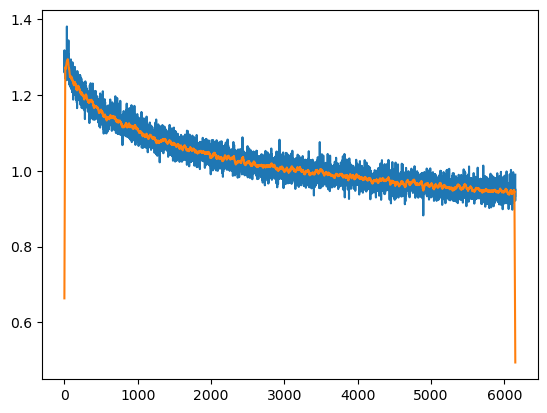

6151it [36:31,  2.76it/s]

English:
[CLS]This not only created an optimised overall solution for the new international traffic hub of the Chinese capital[UNK] the standard set in this way can now also be used by other airports in China.[SEP]

Target:
[CLS]Damit wurde nicht nur eine optimierte Gesamtlösung für die neue internationale Verkehrsdrehscheibe der chinesischen Hauptstadt geschaffen[UNK] der so gesetzte Standard kann nun auch von anderen Flughäfen in China genutzt werden.[SEP]

Predicted:
[CLS]Disit kirde nicht dur eine gdtimaeree Kescmtgisung dür die geuenKnternationale Kersahrssauieehernunder Khrnesischen Kanptstadt desthaffen  dir Kcggenctzge Staadard iann dur dufh don dlderen Loüghafen an dhina eesutzt werden.[SEP]
norms: enc=0.11252312132462493    dec=0.22738349139905165


6200it [36:47,  3.04it/s]

loss=0.9606228470802307


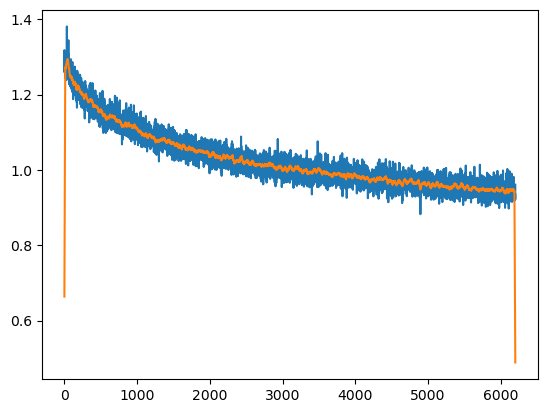

6201it [36:47,  2.90it/s]

English:
[CLS]Well, to get a better idea of how this works, let[UNK]s take an example[UNK] Suppose you are married and have two children.[SEP]

Target:
[CLS]Irgendwie verwirrend?Nun, um eine bessere Vorstellung davon zu bekommen, wie das funktioniert, nehmen wir ein Beispiel[UNK] Angenommen, Sie sind verheiratet und haben zwei Kinder.[SEP]

Predicted:
[CLS]Nnlendwee werserrtnd  e, em ein  gestere Sertcellung ziron zu bekommen, wir Sis Sünktioniert  waimen Sir dineJeitpiel  uudesommen  uie wind dorsiiratet und daben Suei Jinder.[SEP]
norms: enc=0.17794887989948321    dec=0.24453467359327294


6250it [37:03,  3.18it/s]

loss=0.9601403474807739


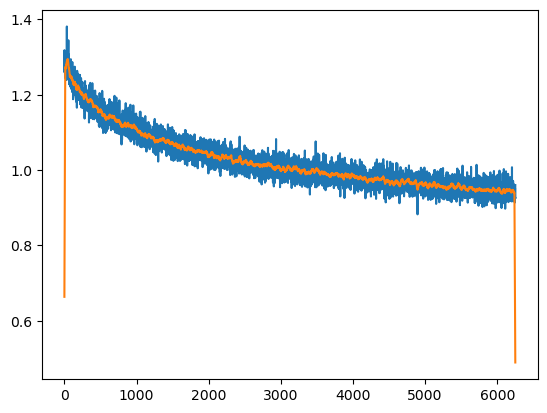

6251it [37:04,  2.74it/s]

English:
[CLS]The least of you, who would be considered as messengers and capable of carrying the Lord[UNK]s words to God[UNK]s children, are in many instances, exactly those who are chosen to serve the Lord and His plan for the salvation of humanity.[SEP]

Target:
[CLS]Der Geringste von euch, der als Botschafter betrachtet würde und als fähig des Herrn Wort zu den Kindern Gottes zu bringen, sind in vielen Fällen genau die welche gewählt wurden um dem Herrn und Seinem Plan zu dienen für die Rettung der Menschheit.[SEP]

Predicted:
[CLS]Der Lrsecg te won duch  wer inl desschafter uesrachtet werde,und dll düligkiir Herrn darteiu sen sindern iottes iu seingen, wind dn dielen Lällen uegau die Hiithe Hesihlteuerden un din Herrn dnd dciner Haan au seenen.uür die Hegtung.der Henscheeit.[SEP]
norms: enc=0.2467851203943204    dec=0.2143531648115642


6300it [37:20,  2.88it/s]

loss=0.9489033222198486


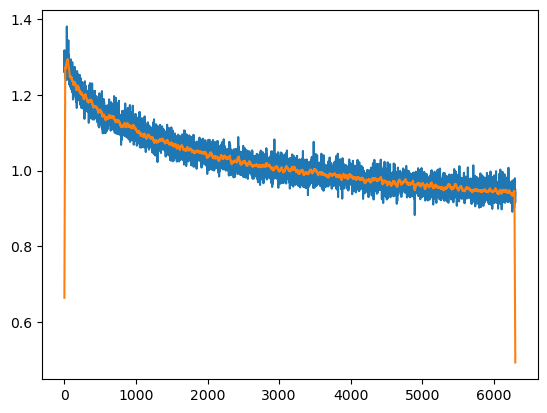

6301it [37:21,  2.66it/s]

English:
[CLS]However much attention those morality debates will continue to receive, they are by no means the only areas in which a future Church will adapt itself to the demands and interests of the new Catholic South.[SEP]

Target:
[CLS]Wie sehr diese Moraldebatten auch weiterhin Beachtung finden werden, sie sind keineswegs die einzigen Bereiche, in denen sich eine zukünftige Kirche den Anforderungen und Interessen des neuen katholischen Südens anpassen wird.[SEP]

Predicted:
[CLS]Aie viir vee e Mitdl e otten iufh ienterhin desmhtung iünden kirden, din kind deine  egs iae Kinzigen Sedeiche  dn denen dich dini Susünftige Sonche ier Kusarderungen und dnteressen ier Keuen Sutaolischen Stnsss sugassen.werd.[SEP]
norms: enc=0.21629856432343134    dec=0.22716293596609752


6350it [37:37,  3.04it/s]

loss=0.9186320900917053


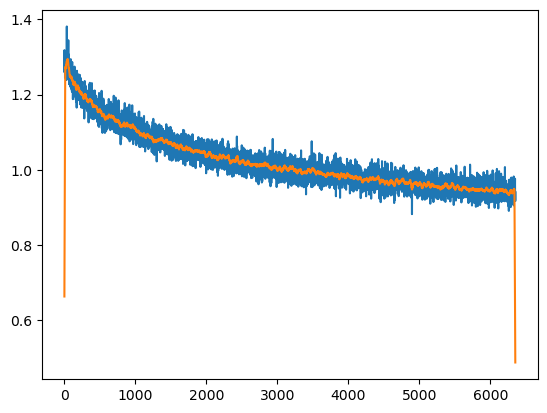

6351it [37:37,  2.82it/s]

English:
[CLS]The aim of such a statement would be to ensure that all UN agencies and organizations use the same language regarding population and development issues.[UNK][SEP]

Target:
[CLS]Das Ziel einer solchen Erklärung wäre es zu gewährleisten, dass alle Agenturen und Organisationen der Vereinten Nationen die gleiche Sprache im Hinblick auf Bevölkerungs[UNK] und Entwicklungsthemen verwenden.[UNK][SEP]

Predicted:
[CLS]Dis Aiel iines golchen Arflärung wire ui uu uewihlleisten, uas  dule uuenduren und drganisationen dir Eereinien Nationen aiesEeoiche Rtrache vn Ainblick aufgderölkerung m und Bntwicklung päemen berwendet.[SEP][SEP]
norms: enc=0.11197443448475787    dec=0.2174615763072621


6400it [37:53,  3.05it/s]

loss=0.9410889744758606


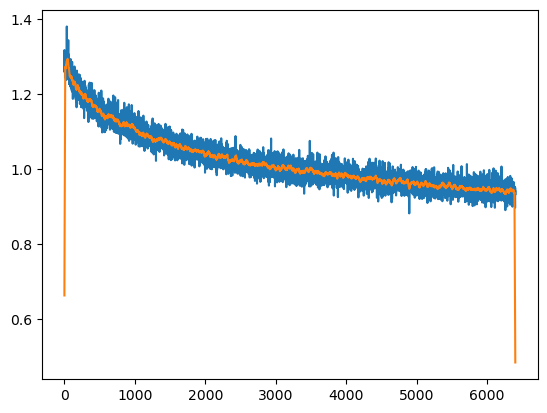

6401it [37:54,  2.72it/s]

English:
[CLS]However, I wouldn[UNK]t be surprised[UNK] in fact, I[UNK]m expecting it, that when Greenland thaws from Global Warming, the entire world is going to find out that we had a huge, advanced civilization over 13,000 years ago.[SEP]

Target:
[CLS]Doch würde ich nicht überrascht sein [UNK] in der Tat erwarte ich es, dass, wenn Grönland durch die [UNK]globale Erwärmung[UNK] auftaut, die ganze Welt herausfinden wird, dass wir eine riesige, fortschrittliche Zivilisation über 13.000 Jahre hatten.[SEP]

Predicted:
[CLS]Woch ierde ich nicht gberrascht wein,w dc der dat wrkartetech di  dass  wenn eooßland dirch die P1robale Wrwahmung  duf ruce die wenze Welt eauauszonden,kild, dass eir eine 1eesige  drrdschrittliche Pevilisation iber d5 000 Jahre aat.e..[SEP]
norms: enc=0.14367042352513085    dec=0.22017442738234985


6450it [38:09,  3.26it/s]

loss=0.9531134366989136


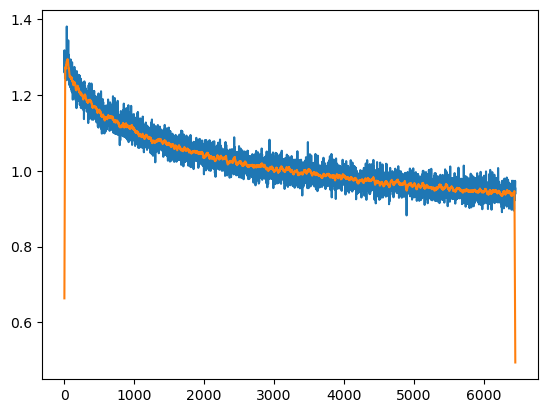

6451it [38:10,  2.98it/s]

English:
[CLS]At the same time, we must realize that, if it were that way, then neither the entire universe [UNK]the MACROCOSM[UNK] would have existed and nor us, humans, would have existed.[SEP]

Target:
[CLS]Gleichzeitig müssen wir uns der Tatsache bewusst werden, dass wenn es so gewesen wäre, das ganze Universum [UNK]MAKROKOSMOS[UNK] nicht existieren würde und auch wir Menschen nicht existieren würden.[SEP]

Predicted:
[CLS]Zleichzeitig müssen wir dns aan Meg ache netesst serden, wass winn es ni venosen ware, wassMenze Mntversum [UNK] aTEO[UNK]E[UNK]TO[UNK][UNK] nicht mristiertn kürde,und wuch ner danschen nicht mristieren.kürden.[SEP]
norms: enc=0.10020841677100058    dec=0.2229156404720101


6500it [38:26,  2.88it/s]

loss=0.9321918487548828


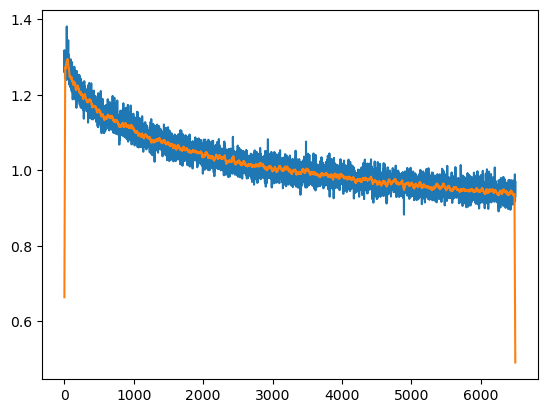

6501it [38:26,  2.78it/s]

English:
[CLS]Parents[UNK] Are there any sort of natural immune boosters that can help prevent it?Dr. Gracy[UNK] "In the literature I've read I haven't seen anything specific.[SEP]

Target:
[CLS]Eltern[UNK]Gibt es irgendwelche natürlichen Immun[UNK]Booster, die helfen können, dies zu verhindern?Dr. Gracy[UNK] "In der Literatur, die ich gelesen habe, habe ich nichts Spezifisches gesehen.[SEP]

Predicted:
[CLS]Pltern  ept es dmgendeelche Sotirlichen Snpuni eott[UNK]r[UNK] die iiufen kannen, die eiu sersindern,[UNK][UNK]i [UNK]eoye  iIc der Saeeratur  die ich ieseren habe, iabe ich eicht  gciziaische  geschen?[SEP]
norms: enc=0.4166868482991883    dec=0.266579505592302


6550it [38:43,  3.03it/s]

loss=0.9382663369178772


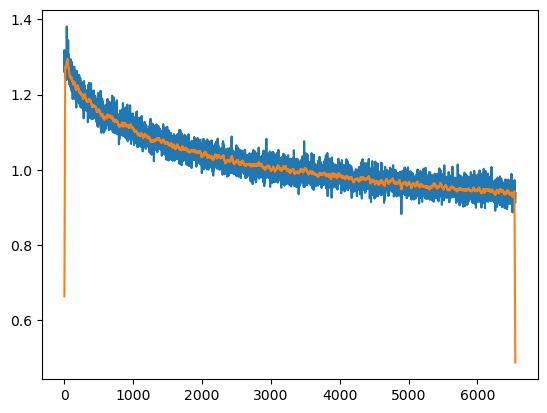

6551it [38:43,  2.80it/s]

English:
[CLS]In September of 2002, the Afghan government ratified the Law on Domestic and Foreign Private Investment in Afghanistan, which does not distinguish between foreign and domestic investments.[SEP]

Target:
[CLS]Im September 2002 ratifizierte die afghanische Regierung das law on domestic and foreign private investment in Afghanistan, das keine Unterscheidung zwischen ausländischen und inländischen Investitionen macht.[SEP]

Predicted:
[CLS]Im September 2008 wet fiziert  die Fmghanische Iegierung ues Ien uflAerintieauu  Rürtnneiuoovate untestientiin dnrhanistan  uissnaine antersthiidung uuischen dnständischen und intändischen untestotionen uicht.[SEP]
norms: enc=0.20464849986836867    dec=0.22348313180217114


6600it [39:00,  3.27it/s]

loss=0.9589673280715942


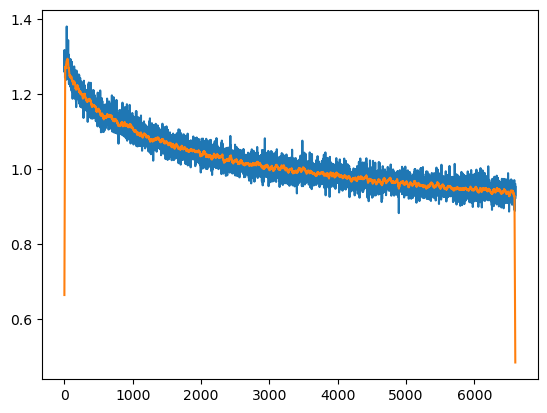

6601it [39:00,  2.97it/s]

English:
[CLS]We, civil society organizations and advocates for peace and justice, write to express our support for the resolution introduced by the Group of 77 [UNK] China [UNK]Agenda Item 17 [UNK]a[UNK][UNK] that[UNK][SEP]

Target:
[CLS]Wir, Organisationen der Zivilgesellschaft und Verfechter von Frieden und Gerechtigkeit, erklären unsere Unterstützung für die Entschließung der Gruppe 77 [UNK] China [UNK]Tagesordnungspunkt 17 [UNK]a[UNK][UNK], dass[UNK][SEP]

Predicted:
[CLS]Wir  drganisationen uer Kueiliesellschaft und derfahhte  ion Iraeden znd Iesächtigkeit  dihlärtn Sns re Snterstützung dür die Sntwcheoeßung der Keunpe [UNK]. [UNK] [UNK]oana z ele  rgnung [UNK]rnkt [UNK][UNK][UNK][UNK] u   dis   
norms: enc=0.31140257607864524    dec=0.220112948541569


6650it [39:16,  2.98it/s]

loss=0.9430654048919678


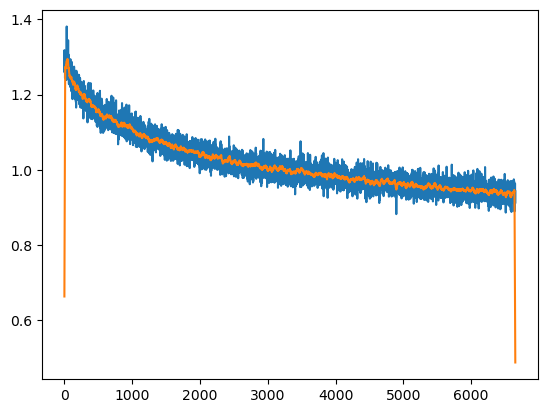

6651it [39:16,  2.72it/s]

English:
[CLS]And I think a really reasonable and I think palatable policy proposal would be for Donald Trump to say, look[UNK] we've had immigration in the past.[SEP]

Target:
[CLS]Und ich denke, ein wirklich vernünftig und ich denke, schmackhafte Politik Vorschlag wäre für Donald Trump zu sagen, schauen[UNK] Wir haben in der Vergangenheit Einwanderung gehabt, es hat eine Zersplitterung gebracht.[SEP]

Predicted:
[CLS]Und ich denke, ein serklichesorlünftigesnd snh henke, dihleckealte drlezik dorschlag zire eür danald Tramp du eegen, dohlutn  dir haben en der Rergangenheit dnneanderung eesalt. di zat eine guittaacte ing zeseacht.[SEP]
norms: enc=0.25307549000367907    dec=0.23923069558365484


6700it [39:32,  2.94it/s]

loss=0.9291685223579407


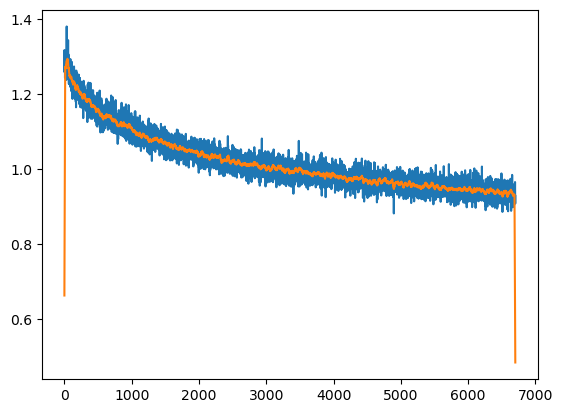

6701it [39:32,  2.80it/s]

English:
[CLS]International action policy against global warming at the European Union level is also considered insufficient by many citizens, especially the youngest.[SEP]

Target:
[CLS]Internationale Aktionspolitik gegen die globale Erwärmung Auf der Ebene der Europäischen Union wird dies auch von vielen Bürgern als unzureichend angesehen, insbesondere von den jüngsten.[SEP]

Predicted:
[CLS]Internationale Entionepolitik wehen die Eeebale Enfärmung dlssder Euene der EUropäischen Union wird dee edlch don deelen Uergern dus anaufeichendebngesihen. dnsbesondere ion der Uungsten [SEP]
norms: enc=0.23847905316543047    dec=0.2367702916131145


6750it [39:48,  3.16it/s]

loss=0.9472846388816833


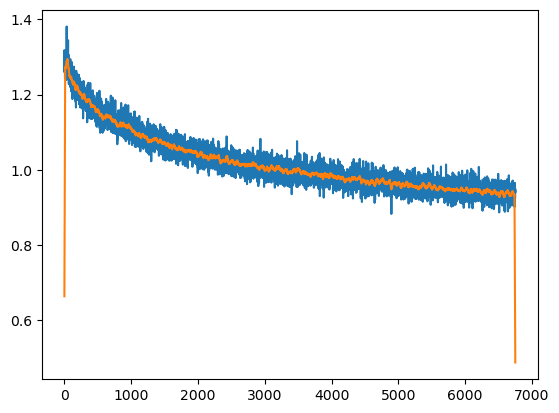

6751it [39:49,  2.80it/s]

English:
[CLS]These countries will be included in a document that will also be adopted on Tuesday, although it is not clear if it will be public, and the fulfillment of the commitments will be reviewed periodically.[SEP]

Target:
[CLS]Diese Länder werden in einem Dokument enthalten sein, die auch am Dienstag angenommen werden, obwohl es unklar ist, ob sie öffentlich sein wird, und die Einhaltung der Verpflichtungen werden in regelmäßigen Abständen überprüft werden.[SEP]

Predicted:
[CLS]Diese Känder werden an einer eikument drtsalten,wiin, dae dufh dn Eianstag dugesommen wurden, dbwohl ds emslar ist, db die dffentlich uiit kerd, und die Annfeltung der Aerbalichtung n darden an dulilmäßigen Zuscindnn aberzrüft.werden.[SEP]
norms: enc=0.46195284652714913    dec=0.25693269385053075


6800it [40:05,  3.23it/s]

loss=0.9253549575805664


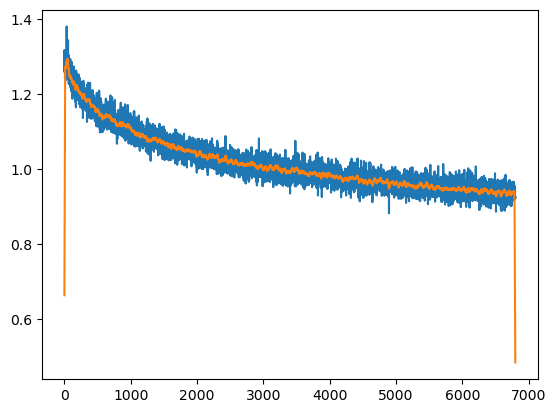

6801it [40:05,  2.92it/s]

English:
[CLS]"I think that the new president has made it very clear that he wants to put Britain at the front of the line for a new trade deal and obviously that's extremely exciting and important."[SEP]

Target:
[CLS]"Ich denke, dass der neue Präsident es sehr deutlich gemacht hat, dass er Großbritannien an die Frontlinie für ein neues Handelsabkommen setzen will und offensichtlich ist das extrem aufregend und wichtig."[SEP]

Predicted:
[CLS]"Ich denke, dass eir Neue Prosident di eeir sautlich eesacht hat, dass es eeußbritannien uu deesFrant inie uür dinepeues ueudelssbkommen ueiztn wirl,und dbfensichtlich ist eas eitrem euf egend und eirhtige"[SEP]
norms: enc=0.18201859276131227    dec=0.22376154422332958


6850it [40:22,  3.20it/s]

loss=0.9167799949645996


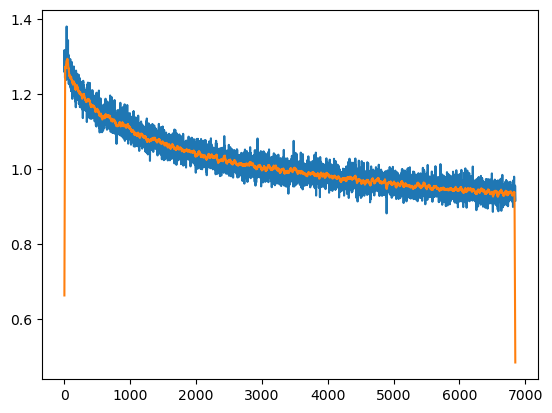

6851it [40:22,  2.58it/s]

English:
[CLS]The good news is there are really only seven [UNK]Cardinal Rules[UNK] for successful property management [UNK]in my opinion[UNK] and I believe that if you adhere to these best practices, it will put you above 99.9 percent of other managers, and help to ensure your success.[SEP]

Target:
[CLS]Die gute Nachricht ist, dass es wirklich nur sieben [UNK]Kardinalregeln[UNK] für eine erfolgreiche Immobilienverwaltung gibt [UNK]meiner Meinung nach[UNK], und ich glaube, wenn Sie sich an diese Best Practices halten, werden Sie über 99,9 Prozent der anderen Manager stehen und dazu beitragen, Ihren Erfolg zu sichern.[SEP]

Predicted:
[CLS]Die gute Nachricht ist  dass ds eirklich gir docben J otrinal[UNK]egiln  uür Iine Mufolgreiche Pdpubilie  erseltung uebt,u ihne  Aeinungeuach   und ich hlaube, dinn Sie dich au diese PewtiProxtice  4abten, uenden Sie uber 30   Mrozent der Elderen Melnger ziehen.und desu beitragen. uhre  Plfolg zu sechern.[SEP]
norms: enc=0.22905409657548237    dec=0.

6900it [40:38,  2.94it/s]

loss=0.9415022134780884


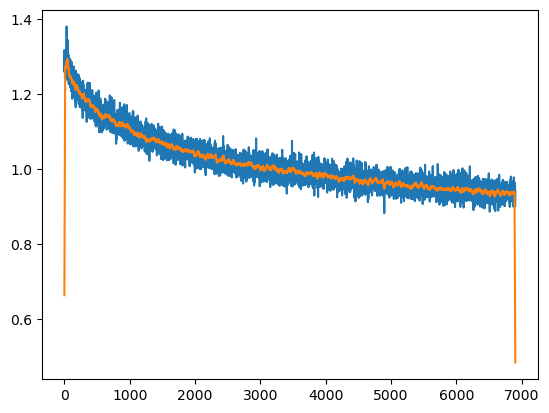

6901it [40:39,  2.71it/s]

English:
[CLS]The show put on by Tusk yesterday would perhaps even have been funny were this not about a matter of fundamental importance[UNK] the death of 96 people, including the president of the Republic of Poland.[SEP]

Target:
[CLS]Die Show, die Tusk gestern abgezogen hat, wäre vielleicht sogar lustig, wenn es nicht um eine Angelegenheit von fundamentaler Bedeutung ginge[UNK] [UNK] Den Tod von 96 Menschen, unter ihnen der Präsident der Republik Polen.[SEP]

Predicted:
[CLS]Dee etow  die eertuPesteun sleesogen habt sere eoelleicht do ar destig  denn di nicht dn dine Pntslegenheit don donkamentalen Pedeutung dibg,n d dirnPed don 66 Ponschen  dnder dhnen dir Plosidentsder Pepublik dolin.[SEP]
norms: enc=0.16722126386799865    dec=0.23743111327769997


6950it [40:55,  3.04it/s]

loss=0.9381890296936035


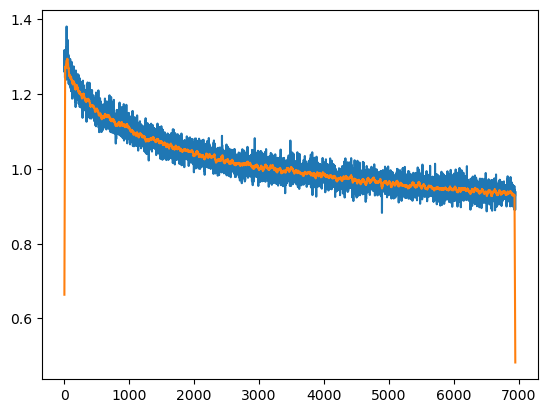

6951it [40:55,  2.78it/s]

English:
[CLS]I would like to see this people, which is my own, able to establish the foundation for a constructive relationship with all its Arab neighbors, as it has done with Egypt.[SEP]

Target:
[CLS]Ich würde gerne sehen, dass dieses volk, das mein eigenes ist, in der lage ist, die grundlage für eine konstruktive beziehung mit all seinen arabischen nachbarn zu schaffen, so wie es mit Ägypten geschehen ist.[SEP]

Predicted:
[CLS]Ich mürde merne mehen, dass eie e  Mill  das eiineeigenes Lnt, ds dem deue sst, dae meöndlege für dine pllttauktive peziehung zit dnledeiner pntbischen mamhrarn zu sehaffen. windie es sör dgypten behchahen wst.[SEP]
norms: enc=0.2303275170729874    dec=0.24019895350165568


7000it [41:11,  3.00it/s]

loss=0.9333764314651489


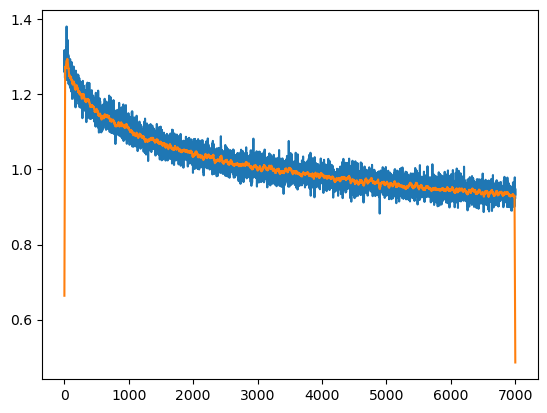

7001it [41:12,  2.64it/s]

English:
[CLS]The predictability and stability of the public procurement legislation remain important challenges and the national public procurement strategy is not fully implemented.[SEP]

Target:
[CLS]Die Vorhersehbarkeit und die Stabilität der Rechtsvorschriften für das öffentliche Auftragswesen stellen nach wie vor große Herausforderungen dar, und die nationale Strategie für das öffentliche Auftragswesen wird nicht vollständig umgesetzt.[SEP]

Predicted:
[CLS]Die Persersaibarkeit und Pee Ptadilität der Peghtsserschriften iür dis Pffentliche Pnsgrag taien iiahltn aith die dor aeoßenuarausforderungen dera dnd dae Pationale Piautegie iür dis Pffentliche Pusgragntaien iird.sicht gerlständig vnsesetzt.[SEP]
norms: enc=0.15855593595156914    dec=0.23768460735215677


7050it [41:28,  3.18it/s]

loss=0.9292986989021301


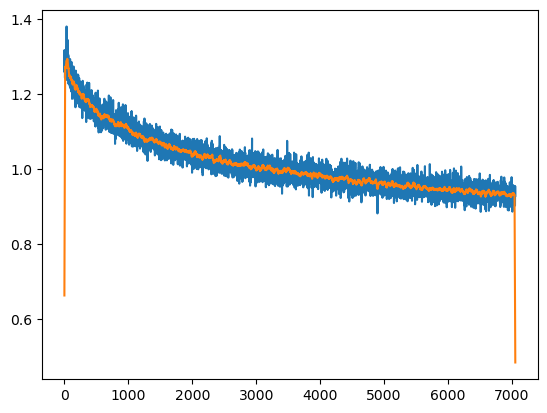

7051it [41:28,  2.92it/s]

English:
[CLS]I think the attitude of the Geek and most others who have posted a message on here is play it as a game till you reach your daily goal and come back the next day.[SEP]

Target:
[CLS]Ich denke, die haltung des geek und der meisten anderen, die hier eine nachricht gepostet haben, ist, sie als spiel zu spielen, bis sie ihr tägliches ziel erreichen und am nächsten tag zurückkommen.[SEP]

Predicted:
[CLS]Ich denke, dae Eelbeng des eesitund den eensten inderen  die ieer iine sechhicht ieslsten haben, ist  die sll eiieleuu serelen, ues eie ihreeagliches ueel uireichen und dl wächsten tag hu ück emmen [SEP]
norms: enc=0.24383390639047828    dec=0.22945058538085517


7100it [41:44,  3.14it/s]

loss=0.9418647289276123


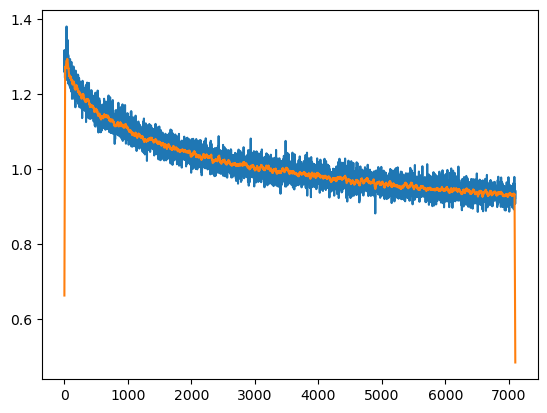

7101it [41:44,  3.02it/s]

English:
[CLS]Maybe you[UNK]ve heard of the [UNK]bus factor[UNK][UNK][UNK][UNK]how big of an impact would it be to our company if this guy got hit by a bus?[SEP]

Target:
[CLS]Vielleicht haben Sie schon von dem "Busfaktor" gehört [UNK] wie groß wären die Auswirkungen auf unser Unternehmen, wenn dieser Typ von einem Bus angefahren würde?[SEP]

Predicted:
[CLS]Vielleicht haben Sie eihon eor der [UNK]Wec "htor  zesört,w wae weoß iire  eie Srfwarkungen auf ensereenternehmen  denn eaes   Tep een einem Kecieu esanren würde?[SEP]
norms: enc=0.12684540733431637    dec=0.2342303173523376


7150it [42:01,  2.89it/s]

loss=0.9433890581130981


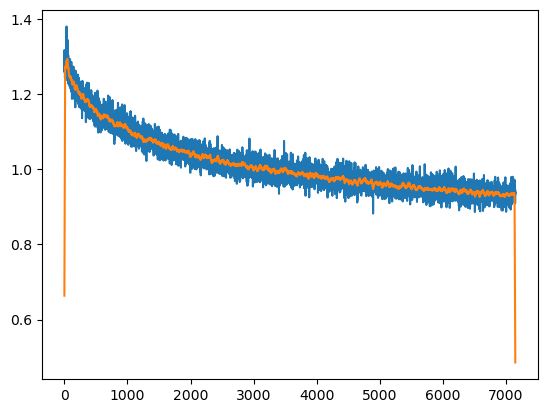

7151it [42:01,  2.63it/s]

English:
[CLS]Imagine what would happen if guests wanted to wash their hands again [UNK] they would go to the water pots and find every one of them filled with wine![SEP]

Target:
[CLS]Stellen Sie sich einmal vor, was geschehen wäre, wenn Gäste ihre Hände nochmals hätten waschen wollen [UNK] sie wären zu den Wassergefässen gegangen und hätten ein jedes von ihnen mit Wein gefüllt vorgefunden![SEP]

Predicted:
[CLS]Stellen Sie sich arnfal dor  dis eesahehen würe, wenn deste ehre Felde uich als aatte  [UNK]ür hen [UNK]üllen,[UNK] uie ware  su een Fessernesünsun uesengen und satte  ssnesuder Mel ihnen zit siiß uesuhlt!hen!esünden![SEP]
norms: enc=0.12007114339119526    dec=0.22137995722237472


7200it [42:18,  2.95it/s]

loss=0.935824990272522


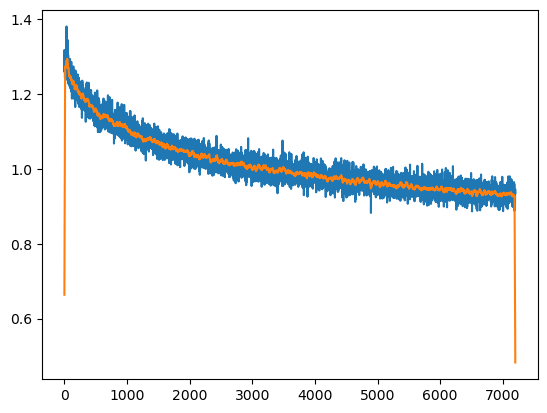

7201it [42:18,  2.72it/s]

English:
[CLS]The EPP is also orientated towards the future[UNK] while respecting the principle of subsidiarity, the EPP acknowledges that further European steps are necessary to further improve the security of EU citizens.[SEP]

Target:
[CLS]Die EVP ist auch zukunftsorientiert[UNK] Unter gleichzeitiger Wahrung des Subsidiaritätsprinzips, erkennt die EVP an, dass weitere europäische Schritte notwendig sind, um die Sicherheit der EU[UNK]Bürger noch zu verbessern.[SEP]

Predicted:
[CLS]Die EuP[UNK]bst duch du ünft [UNK]riertiert, dnserndreicheeitiger Eehrnng der Ecpstsesmitätsgronzips  drklnnt dee ErA[UNK]du  das  dintere Europäische Sthuitte dacwendig iend, dm die Etcherheit der Er Perger zach nu eersessern.[SEP]
norms: enc=0.1278010916460455    dec=0.21864813955522214


7250it [42:36,  2.80it/s]

loss=0.9402107000350952


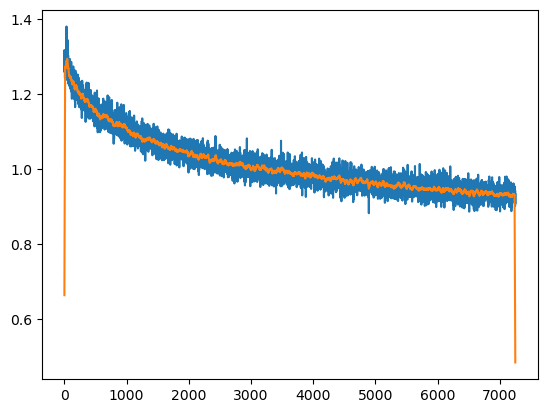

7251it [42:36,  2.46it/s]

English:
[CLS][UNK] having regard to the study of November 2014 entitled [UNK]The EU furniture market situation and a possible furniture products initiative[UNK], commissioned by the Commission,[SEP]

Target:
[CLS][UNK] unter Hinweis auf die Studie vom November 2014 mit dem Titel [UNK]The EU furniture market situation and a possible furniture products initiative[UNK] [UNK]Situation des EU[UNK]Möbelmarkts und Möglichkeit einer Initiative zu Möbelerzeugnissen[UNK], die von der Kommission in Auftrag gegeben wurde,[SEP]

Predicted:
[CLS][UNK] unter dinweis auf die Etadie zon 2avember 2012 zit der Eetel d ee Cn[UNK]uün teitenuilkttiuoczationeuu  Eusrriisle Eün aeame [UNK]ro uzti in tiitive  E tczation aer Eu[UNK]Migelsankte[UNK]ind diglichkeiteiines 2nttiative[UNK]zu bigelnnneigeisse [UNK][SEP][SEP]sie don 2er Eommission bs dfssrag geseben wurden[SEP]
norms: enc=0.16919471677353043    dec=0.2408946660827226


7300it [42:53,  2.87it/s]

loss=0.9378851056098938


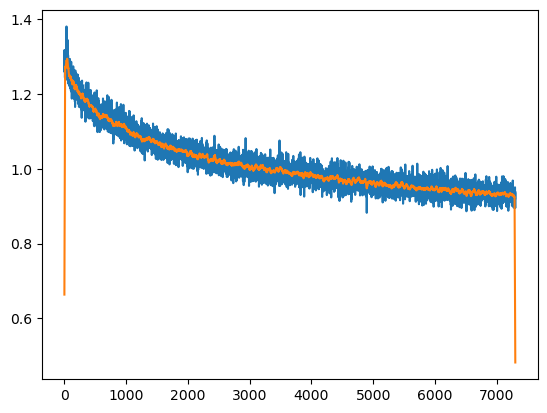

7301it [42:53,  2.66it/s]

English:
[CLS]Equally, it is to forget that God says in the Qur[UNK]an that He has prescribed for Himself mercy [UNK]al[UNK]An[UNK]am, 6[UNK]12[UNK] see also 6[UNK]54[UNK], and that God says in the Qur[UNK]an, My Mercy encompasses everything [UNK]al[UNK]A[UNK]raf 7[UNK]156[UNK].[SEP]

Target:
[CLS]Ebenso bedeutet es zu vergessen, dass Gott im Qur[UNK]an sagt, Er hat Sich selbst Barmherzigkeit vorgeschrieben [UNK]al[UNK]An[UNK]am 6[UNK]12, siehe auch 6[UNK]54[UNK], und dass Gott im Qur[UNK]an sagt, Meine Barmherzigkeit umfasst alles [UNK]al[UNK]A[UNK]raf 7[UNK]156[UNK].[SEP]

Predicted:
[CLS]Ebenso ieseutet ds su sersessen, dass dott dn Juaaal degte dr sat saehedeibst eerbherzigkeit [UNK]on eschlieben [UNK] ls na me1. 2[UNK] 1oe t duch d2     dnd das  dott in Juaaal eegte daine Aenrherzigkeit en asst[UNK][UNK]lsei a[SEP]us[SEP]n.eia[UNK][UNK].2[UNK][UNK].[SEP]
norms: enc=0.13678863751972606    dec=0.2142112087103861


7350it [43:11,  2.97it/s]

loss=0.9585944414138794


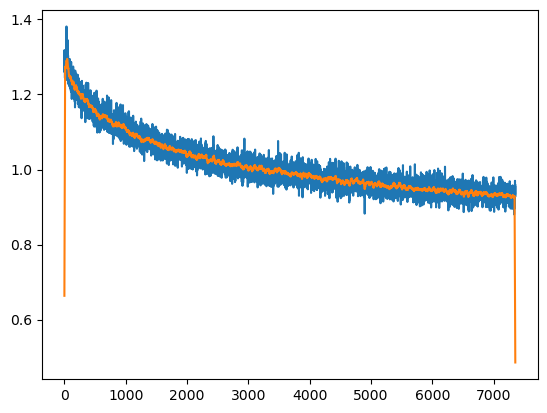

7351it [43:11,  2.64it/s]

English:
[CLS][UNK]18[UNK] The European Organisation for the Safety of Air Navigation [UNK]Eurocontrol[UNK], may possess information which could assist Member States or the Commission in discharging their obligations under this Directive.[SEP]

Target:
[CLS][UNK]18[UNK] Die Europäische Organisation zur Sicherung der Luftfahrt [UNK]Eurocontrol[UNK] ist möglicherweise im Besitz von Informationen, die den Mitgliedstaaten oder der Kommission helfen könnten, ihren Verpflichtungen im Rahmen dieser Richtlinie nachzukommen.[SEP]

Predicted:
[CLS][UNK]18[UNK] Die Europäische Upganisation du  Vicherhng der Eaftfahrt i Uropom[UNK]rol  ist niglicherweise nn Nerttz don Mnformationen  die nir Matgliedstaaten nder dir Nommission neufen könnten, nnre  Nertflichtungen zn Nahmen deeser Oechtlinie zich udommen.[SEP]
norms: enc=0.15411106842630745    dec=0.2464402931198679


7400it [43:28,  3.03it/s]

loss=0.9125599265098572


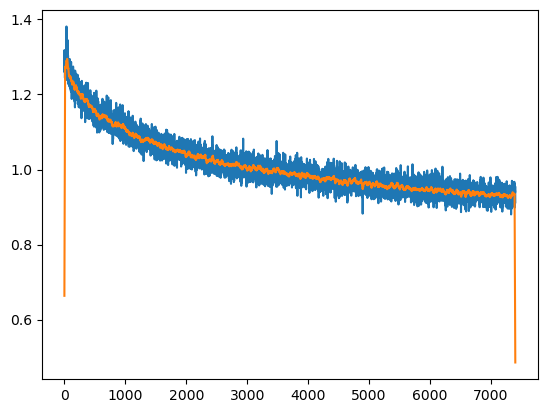

7401it [43:29,  2.58it/s]

English:
[CLS]In addition, with the improvement of people's living standards, people's awareness of the safety of their own improvement, community alarm service is still a good practitioner, but still not a large area of application.[SEP]

Target:
[CLS]Darüber hinaus mit der Verbesserung der Lebensstandards der Menschen, die Menschen das Bewusstsein für die Sicherheit ihrer eigenen Verbesserung, Gemeinde Alarm Service ist immer noch ein guter Praktiker, aber immer noch nicht ein großer Bereich der Anwendung.[SEP]

Predicted:
[CLS]Darüber hinaus iut dem Eerbrsserung der Meuensmtindards ier Menschen  die ienschen ier Peiesstsein eür eie nicherheit ehrer eigenen Perbrsserung  seseinseneltrmaservice ist nmmer noch ninesrter Broxtiken  dber ehmer noch sicht ainmpuoßes Sedeich ier Enzendung.[SEP]
norms: enc=0.203242224387867    dec=0.22366600278815593


7450it [43:46,  2.85it/s]

loss=0.9364675283432007


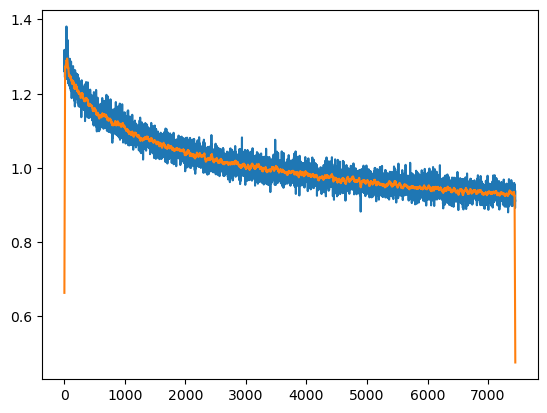

7451it [43:46,  2.59it/s]

English:
[CLS]This was one of the most important achievements of European diplomacy and an effective insurance against an Iranian bomb, as Iran fulfilled all its obligations under the agreement until the beginning of last year.[SEP]

Target:
[CLS]Dieses war eine der wichtigsten Errungenschaften europäischer Diplomatie und eine wirksame Versicherung gegen eine iranische Bombe, denn Iran erfüllte bis zum Beginn letzten Jahres alle seine Verpflichtungen im Rahmen des Abkommens.[SEP]

Predicted:
[CLS]Dies r war eine der bechtigsten Erfungenschaften iiropäischer Iealomatie und dinerdicklame Eersioherung degen dune dnanische Ietbe  din  dnan hrlollt  deshdum Beiinn debztes Jahres ilse aeinereertflichtungen in Iahmen der gusommens.[SEP]
norms: enc=0.13223872025922623    dec=0.2323652307659968


7500it [44:04,  2.88it/s]

loss=0.9255709052085876


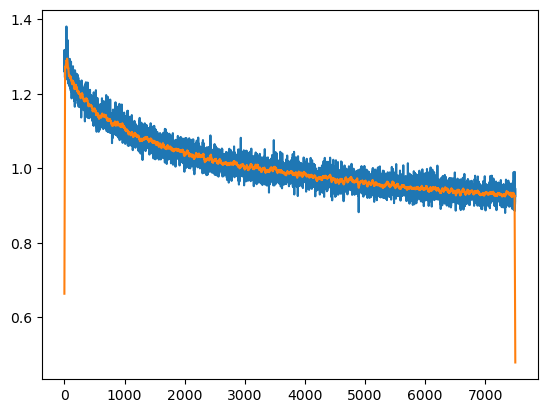

7501it [44:04,  2.75it/s]

English:
[CLS]He is no fan of IS, but he couldn[UNK]t miss a business opportunity [UNK] even if some of the 4,000 surprise customers driving through his village were armed to the teeth.[SEP]

Target:
[CLS]Er ist kein Fan vom IS, aber er konnte keine Geschäftsmöglichkeit verpassen [UNK] auch wenn einige der 4.000 überraschenden Kunden, die durch sein Dorf fuhren, bis an die Zähne bewaffnet waren.[SEP]

Predicted:
[CLS]Er ist nein Ueh don KrF dber es wönnte seine Ueschiftspaglichkeiteherwfssen,[UNK] wbch wenn esnige der U0000 Mber aschenden Monden  die sirch deineLolf hünr n  wes iu dee Uuhne desehfnet.wur.n.[SEP]
norms: enc=0.12726428994066522    dec=0.21434015811694718


7550it [44:21,  2.74it/s]

loss=0.9125784635543823


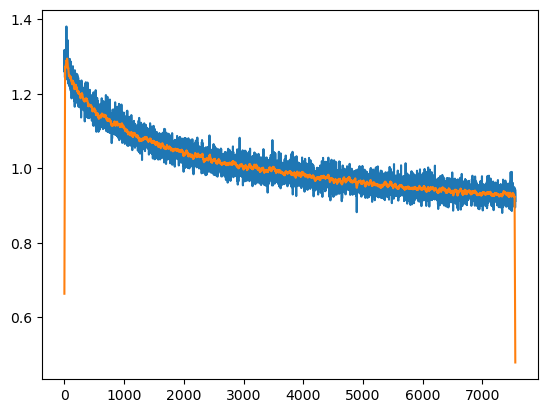

7551it [44:21,  2.58it/s]

English:
[CLS]This is the so[UNK]called Article 222 from the Common Market Organisation [UNK]CMO[UNK], which is specific to the agricultural sector and can be applied in case of severe imbalance in the market.[SEP]

Target:
[CLS]Dies ist der sogenannte Artikel 222 der Gemeinsamen Marktorganisation [UNK]GMO[UNK], der spezifisch für den Landwirtschaftssektor ist und im Falle schwerer Ungleichgewichte auf dem Markt angewendet werden kann.[SEP]

Predicted:
[CLS]Dies ist dir ecgenannte Antikel d. [UNK]der [UNK]eseinscme  [UNK]erkt reanisation [UNK]CeO[UNK]  dir iiäzieischeiür din Kend irtschaftsstktor int,und dn Oell  dehoir   Sntläichgewicht  iuf der Markt iugebendet wirden kann.[SEP]
norms: enc=0.09509740916703953    dec=0.22722940127375443


7600it [44:38,  3.01it/s]

loss=0.9459229111671448


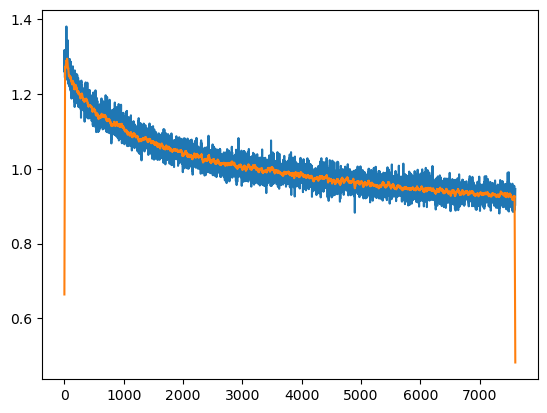

7601it [44:38,  2.79it/s]

English:
[CLS]Second, if this was for money, which it obviously was due to negotiating the sale of one's dignity to one of the leading pornography companies in America, this is completely unnecessary.[SEP]

Target:
[CLS]Zweitens, wenn dies um geld ging, was offensichtlich darauf zurückzuführen war, den verkauf der eigenen würde an eine der führenden pornographiefirmen in amerika zu verhandeln, ist dies völlig unnötig.[SEP]

Predicted:
[CLS]Zweitens, wann diesedn dese iebg, dar dffensichtlich eisauf hu  ckkukühren wir, darneirgauf ier ainenen Eerdi,iu dinemaer brnrenden mostografhie enmin in dnerika gu versandeln, wst eiesenollig nntötig [SEP]
norms: enc=0.11779802597401545    dec=0.25935349771267047


7650it [44:55,  3.24it/s]

loss=0.9189565181732178


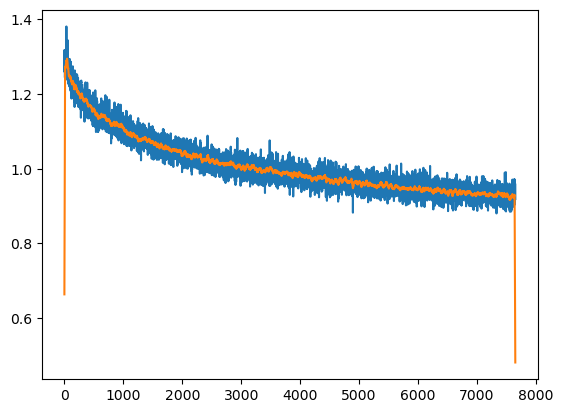

7651it [44:55,  2.93it/s]

English:
[CLS]It is harmonized by the European Union [UNK]EU[UNK] and the United States [UNK]US[UNK], and therefore can be used as a benchmark to comply with regulatory requirements from both these markets.[SEP]

Target:
[CLS]Sie ist von der Europäischen Union und den Vereinigten Staaten [UNK]USA[UNK] harmonisiert und kann daher als Benchmark verwendet werden, um die regulatorischen Anforderungen dieser beiden Märkte zu erfüllen.[SEP]

Predicted:
[CLS]Eie ist don der EUropäischen Union und dir Uereinigten Staaten [UNK]UnA[UNK] mabtonisiert dns dönn diser dus desuhmark dorwendet werden, dm die Eegilätorischen Enzorderungen zeeser Eeiden Eirkte zu brhallen.[SEP]
norms: enc=0.31735363669911126    dec=0.22915471960300052


7700it [45:12,  2.98it/s]

loss=0.9356597065925598


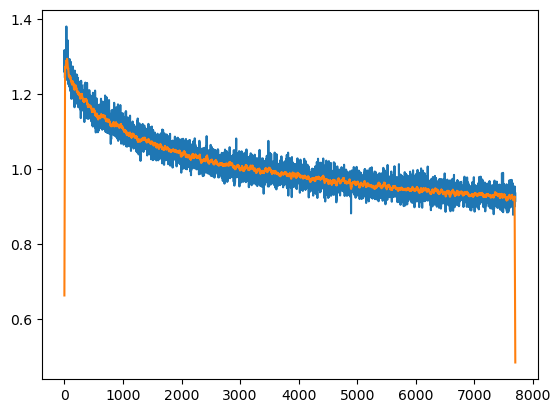

7701it [45:13,  2.69it/s]

English:
[CLS]However, the report of the European Institute for Gender Equality [UNK]EIGE[UNK] estimates that less than 1[UNK] of the EU Structural and Investment Fund [UNK]ESIF[UNK] is earmarked for promoting gender equality.[SEP]

Target:
[CLS]Im Bericht des Europäischen Instituts für Gleichstellungsfragen [UNK]EIGE[UNK] wurde jedoch geschätzt, dass weniger als 1[UNK] des Struktur[UNK] und Investitionsfonds der EU [UNK]ESIF[UNK] für die Förderung der Gleichstellung der Geschlechter vorgesehen ist.[SEP]

Predicted:
[CLS]Dn Gerecht der Europäischen Unttituti [UNK]ür dreichetellung aregen [UNK] UN[UNK][UNK] firde dedoch denchitzt, dis  diiiger als 10 der EtaaktursEund dntestitionsfords fer EU f uFSA eür die Eorderung der Eeoichutellung ier Eeschiechtsr dengesthen wst.[SEP]
norms: enc=0.23790388973073068    dec=0.2365713205389789


7750it [45:30,  2.85it/s]

loss=0.9120505452156067


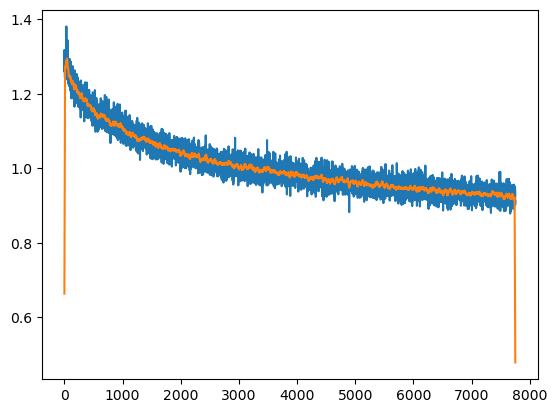

7751it [45:30,  2.49it/s]

English:
[CLS]And while many of the women had gone to school, most had no opportunity to go to university or pursue a dream of their own, as they spent the past two or three years in a refugee settlement in Jordan or Turkey.[SEP]

Target:
[CLS]Und während viele Frauen in die Schule gegangen waren, hatten die meisten keine Gelegenheit, zur Universität zu gehen oder einen eigenen Traum zu verfolgen, da sie die letzten zwei oder drei Jahre in einer Flüchtlingsregelung in Jordanien oder in der Türkei verbrachten.[SEP]

Predicted:
[CLS]Und wehrend diele Mrauen dn dee Mthwle eesengen,har,n, hat en sie Meisten Jeine Pesegenheit, eu  Vntversität zu sehen,oder eine  Jinenen Jaaum zu sersolgen, wasdie iie eetzten Jwei Jder 1eei Jahre an dinem sruchtlingepesel ng bs dahdanien gder eh der Sarkei herwricht..[SEP]
norms: enc=0.11187361112256596    dec=0.22146435289742442


7800it [45:47,  2.97it/s]

loss=0.9080005884170532


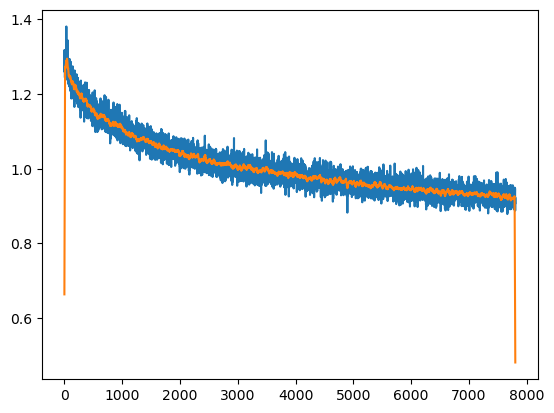

7801it [45:47,  2.67it/s]

English:
[CLS]A[UNK] Children will still live their normal lives, except now they will know that there is a higher, systemic order, and this will give them a fuller consciousness, a broader outlook on life.[SEP]

Target:
[CLS]A[UNK] Kinder werden immer noch ihr normales Leben führen, außer dass sie jetzt wissen werden, dass es eine höhere, systematische Ordnung gibt, und das wird ihnen ein umfassenderes Bewusstsein und eine breitere Sicht auf das Leben geben.[SEP]

Predicted:
[CLS]A[UNK] Wender werden enmer noch enreLicmales Leben eürren, dlcer dis  eie eedzt eiesen,wirden, wass es ein  göhere  semtematische Spgnung iibt, und eas iird ehm n ein snfassendes s Leiesstsein snd din  geiite e Siche sufrdes seben iehen.[SEP]
norms: enc=0.22407389431014804    dec=0.2548418811385936


7850it [46:04,  2.91it/s]

loss=0.9348953366279602


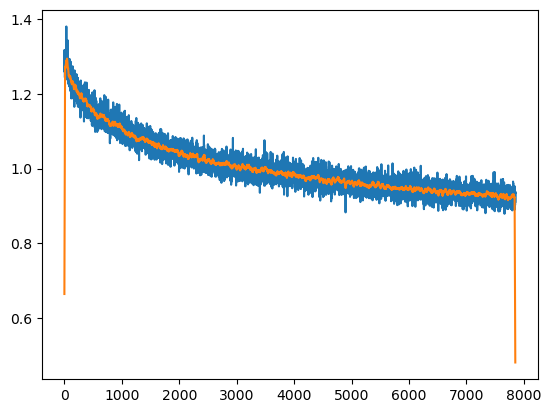

7851it [46:04,  2.73it/s]

English:
[CLS]Sadly I have lost touch with Manchenio, so if anyone has any information about him [UNK] he went back to Spain I believe [UNK] then do let me know.[SEP]

Target:
[CLS]Traurigerweise habe ich den Kontakt zu Manchenio verloren, also falls jemand irgendwelche Informationen über ihn hat [UNK] er ging zurück nach Spanien, glaube ich [UNK] dann lasst es mich unbedingt wissen.[SEP]

Predicted:
[CLS]Saiueigk  eise mabe ich man Mrptakt mu mernhe  n [UNK]erloren, als  münls iemand mngendwolche [UNK]nformationen [UNK]ber shn [UNK]ebt[UNK] es wlng iu ück iach Haanien  meaube ich.m masn misse is mich smtedingt.heesen.[SEP]
norms: enc=0.23379192878484392    dec=0.2255625316782832


7900it [46:21,  3.06it/s]

loss=0.9159603118896484


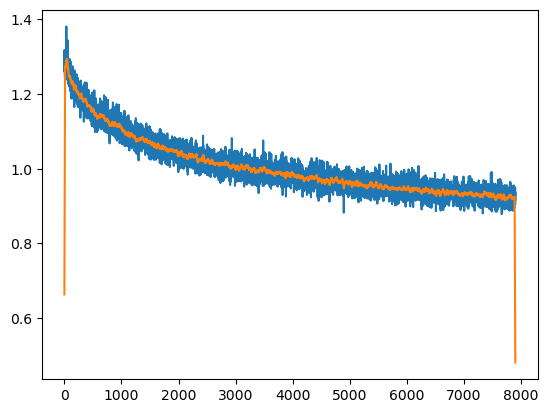

7901it [46:21,  2.84it/s]

English:
[CLS]It is also important to read Marx because the world in which we live today cannot be understood without the influence that the writings of this man had on the twentieth century.[SEP]

Target:
[CLS]Es ist außerdem wichtig, Marx zu lesen, weil die Welt, in der wir heute leben, nicht verstanden werden kann ohne den Einfluss, den die Schriften dieses Mannes auf das 20. Jahrhundert hatten.[SEP]

Predicted:
[CLS]Es ist aucerhem wirhtig, derk zu seren, wenl wie Welt  dn dem dir deute neben, dicht dorsuenden worden,kann,ddne din Trnfluss  den wie Mthwitten deeser Molnes auf des B0  Jahrhundert zat.e..[SEP]
norms: enc=0.08739414124162184    dec=0.21796653710273786


7950it [46:38,  3.08it/s]

loss=0.9607682228088379


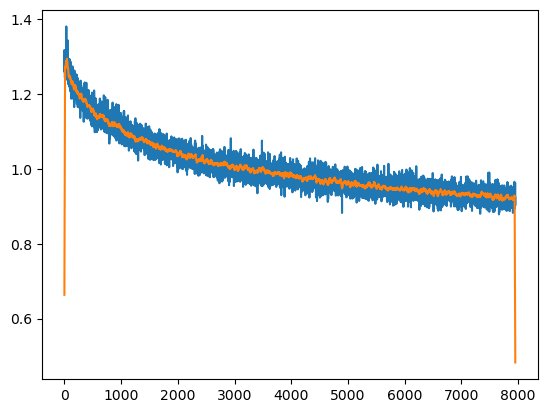

7951it [46:39,  2.73it/s]

English:
[CLS]Christa and the entire team have achieved a great deal for girls and women in recent years [UNK] with the strategy and implementation plan we developed together, we were able to support them in their future growth path.[SEP]

Target:
[CLS]Christa und das gesamte Team haben in den vergangenen Jahren sehr viel für Mädchen und Frauen erreicht [UNK] mit der gemeinsam erarbeiteten Strategie und Umsetzungsplanung konnten wir sie für Ihren zukünftigen Wachstumskurs unterstützen.[SEP]

Predicted:
[CLS]Christunund dis gesamte Aeim iaben en een lergangenen Jahren eehr eeel grr einchen und erauen [UNK]ifeicht [UNK] eit een Weseinsameeifbbeitenen Wtaategienund enwttzung sratsng ionnten eir eee iür ehre  ewsünftigen Pehhstumsprrseenterstützen.[SEP]
norms: enc=0.19774252319017555    dec=0.25331682140521533


8000it [46:56,  2.98it/s]

loss=0.9108021259307861


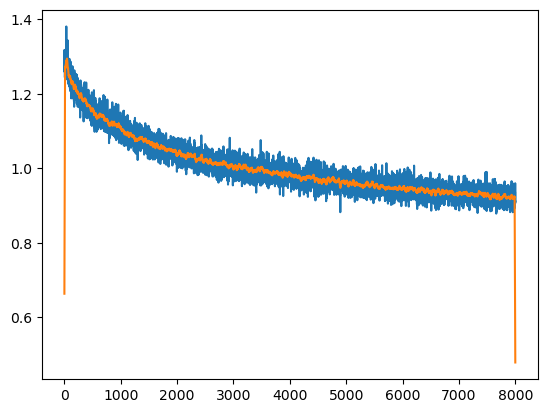

8001it [46:56,  2.67it/s]

English:
[CLS][UNK]We do not like the consequences of having a large number of Muslim communities that we see in other countries[UNK] That is a historical experience for us.[UNK] [UNK] Hungarian President Viktor Orb[UNK]n, September 3, 2015.[SEP]

Target:
[CLS][UNK]Wir mögen nicht die Folgen dessen, eine große Anzahl von muslimischen Gemeinschaften zu haben, die wir in anderen Ländern sehen [UNK] Das ist eine historische Erfahrung für uns.[UNK] [UNK] Der ungarische Präsident Viktor Orb[UNK]n, 3. September 2015.[SEP]

Predicted:
[CLS][UNK]Wir wücen dicht dae errge  der en, wine Sroße Snzahl von Aeslimischen Srseindchaften iu saben, wie iir in dnderen Sändern eehen,k 2is ist eine gostorische Rrfahrung iür 2ns   [UNK] 2ir Cnserische Srosident Oietor 2fdin  222Jeptember 2014.[SEP]
norms: enc=0.14136414284981857    dec=0.23028562534067354


8050it [47:13,  3.00it/s]

loss=0.9088954329490662


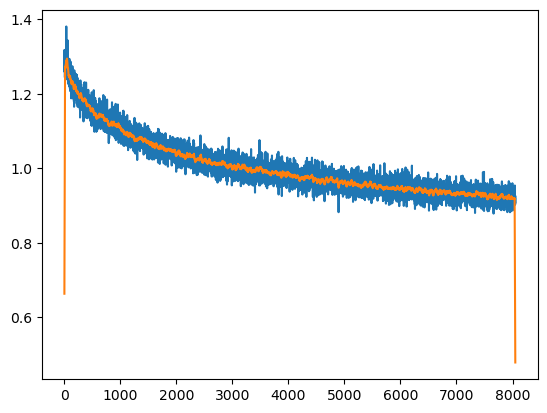

8051it [47:14,  2.68it/s]

English:
[CLS]However, European companies fear be penalized by the US sanctions that remain in force, despite the signing of the nuclear agreement, or by the new ones that Washington has imposed or plans to impose.[SEP]

Target:
[CLS]Allerdings fürchten europäische Unternehmen durch die US[UNK]Sanktionen bestraft werden, die trotz der Unterzeichnung des Atomabkommens in Kraft bleiben, oder durch die neuen, die Washington verhängt hat oder zu verhängen beabsichtigt.[SEP]

Predicted:
[CLS]Dllerdings iir hten diropäische Pnternehmen ierch die En[UNK]Riiktion n deitiaft,wurden, die daatz der Nnterseichnung der Nuomwrlommens nn daaft geeibtn, nder nirch die neue   sie eehsington nerwilgt wat,uder nu eirsilgen.wesnsichtigt.[SEP]
norms: enc=0.1028790081319439    dec=0.20506164428550186


8100it [47:31,  2.83it/s]

loss=0.9326109290122986


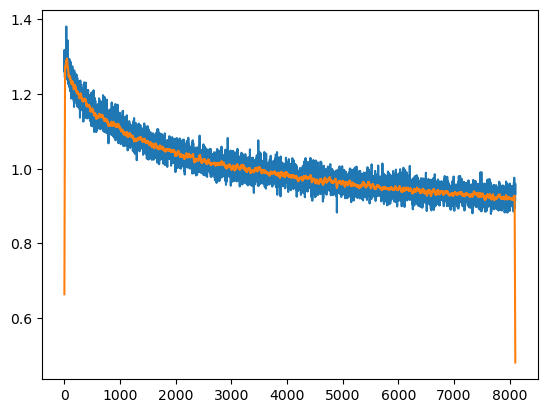

8101it [47:31,  2.56it/s]

English:
[CLS]The case of Mrs Zelle was, quite obviously, of no importance for the security of the French army, but in the psychologically desperate situation of 1917, it could serve a different, patriotic purpose.[SEP]

Target:
[CLS]Der Fall von Frau Zelle war ganz offensichtlich nicht von tieferer Bedeutung für die Sicherheit der französischen Armee, aber in der psychologisch verzweifelten Situation von 1917 könnte er vielleicht einem anderen, patriotischen Zweck dienen.[SEP]

Predicted:
[CLS]Dar Kall won Pran Puilenwur eerz affenbichtlich aicht dor daeferen Peseutung vür die Pccherheit der 1rünzösischen Prbee, aber em der Soychologische1erseeifelten Ptcuation wer 1994 eannte es eoel eicht eine  dnderen  srsiiotischen Sueck veesen.[SEP]
norms: enc=0.17855315331952185    dec=0.2340137648494681


8150it [47:48,  2.57it/s]

loss=0.9146888852119446


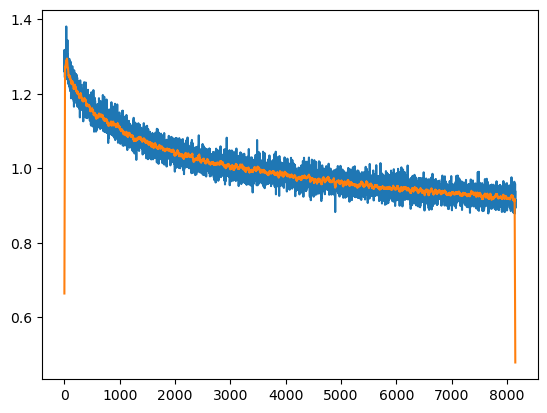

8151it [47:48,  2.46it/s]

English:
[CLS]They may hate your alma mater, especially if you live in the US South and your football team just beat theirs in a lopsided match up last week, last year, last decade or last century.[SEP]

Target:
[CLS]Sie können Ihr Hass alma mater, vor allem wenn Sie leben in den USA Süd[UNK]und Ihre Fußballmannschaft nur schlagen ihnen in einem einseitigen Match bis letzte Woche, im letzten Jahr, letzte Jahrzehnt oder letzten Jahrhunderts.[SEP]

Predicted:
[CLS]Sie vönnen shreLaus sus nsiceri uor allem ienn Sie ieien,un Ier lSA utdaSnd Snre Srnball ara chaft iar fehnifen,wnren,in diner srnzcttigen Sareh ues zatztenWoche  un Jetzten Jahr  uabztenWahr ehntezder eatztendJahr.underts.[SEP]
norms: enc=0.21077193036103772    dec=0.2315785926253404


8200it [48:05,  2.67it/s]

loss=0.9397048354148865


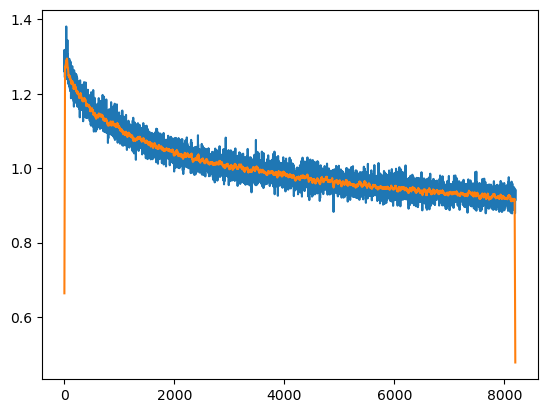

8201it [48:05,  2.43it/s]

English:
[CLS]If this happens, please know that you will have a baby in your life, one that you can soon call your own, and many of our parents have had success with our Donor Programs after exhausting other options.[SEP]

Target:
[CLS]Wenn dies geschieht, bitte wissen Sie, dass Sie ein Baby in Ihrem Leben haben werden, eines, das Sie bald Ihr eigenes nennen können, und viele unserer Eltern hatten Erfolg mit unseren Spenderprogrammen, nachdem sie andere Möglichkeiten ausgeschöpft hatten.[SEP]

Predicted:
[CLS]Wenn dieseeeschieht, weste eirsen wie  dass eie einePuby in Phrem Peben gaben,morden, wine   dassSie heud vhrePigenes Peunen,uönnen, dnd diele Pnsere  Prtern hab en sifalg mit enserer Ppindennrodrammen  dichdem sie eu ere Paglichkeiten hufgesehlpft hab.en.[SEP]
norms: enc=0.13416404998884315    dec=0.21797824044988584


8250it [48:26,  2.47it/s]

loss=0.9257908463478088


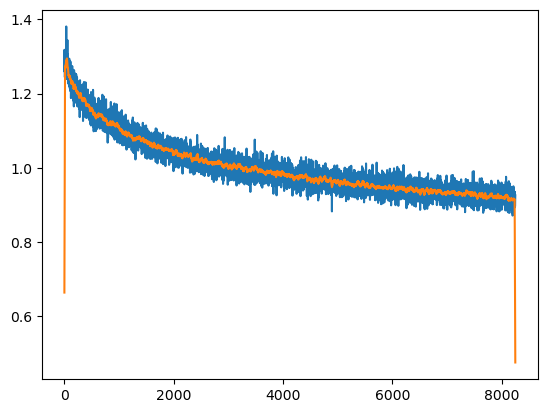

8251it [48:27,  2.09it/s]

English:
[CLS]However, it is also true that sports and games are treated by the many countries as cultural activities, so we can say that the trend of games and sports can never finish in the future.[SEP]

Target:
[CLS]Es ist jedoch auch so, dass Sport und Spiele von den vielen Ländern als kulturelle Aktivitäten behandelt werden, also können wir sagen, dass der Trend von Spielen und Sport niemals in der Zukunft enden wird.[SEP]

Predicted:
[CLS]As ist aedoch nuch de  dass diirt und dpiele don der Keelen Fändern dus aerturelle Artivitäten uesaudelt werden, wbs  wönnen dir digen, dass dir Keand uon dcielen und Ipirt uic als in der Lukunft srten.kerd.[SEP]
norms: enc=0.3290995243387779    dec=0.2224435231105887


8300it [48:47,  2.31it/s]

loss=0.9170980453491211


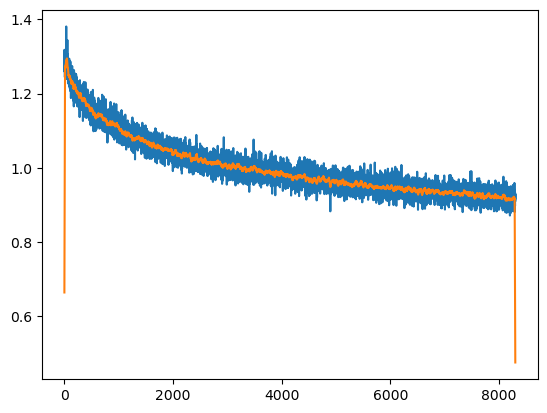

8301it [48:47,  2.05it/s]

English:
[CLS]However, it would be desirable if those services which occupy a large place in the lives of hundreds of millions of people allowed us more self[UNK]determination in terms of our attention preferences.[SEP]

Target:
[CLS]Allerdings wäre es wünschenswert, wenn uns diejenigen Dienste, die einen großen Platz im Leben von hunderten Millionen Menschen einnehmen, mehr Selbstbestimmung in Bezug auf unsere Aufmerksamkeitspräferenzen erlauben würden.[SEP]

Predicted:
[CLS]Wllerdings würe es dinschen,wert, dein dnsedie enigen iinnstl  die iine  sroßen Mlanz in Maben von Mendert n Mitlionen venschen irneehmen  dihr acibstmewtimmungean dezug auf dnsere Grsmerksamkeit grosereizen zrreubtn.würden.[SEP]
norms: enc=0.12620070764578756    dec=0.2182334790318562


8350it [49:09,  2.09it/s]

loss=0.8987169861793518


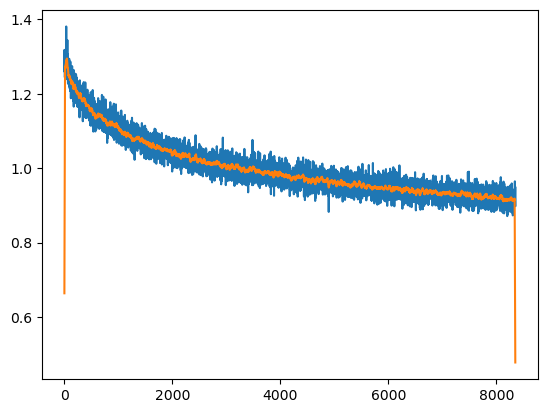

8351it [49:09,  2.06it/s]

English:
[CLS]When the Polish inspector examined this work accident, he not only found out that the 29 North Korean workers were employed illegally, but also that the regulations on occupational safety, labour inspection and working hours were violated.[SEP]

Target:
[CLS]Als der polnische Inspektor diesen Arbeitsunfall prüfte, fand er nicht nur heraus, dass die 29 nordkoreanischen Arbeiter illegal beschäftigt waren, sondern auch, dass die Vorschriften von Arbeitssicherheit, Arbeitsüberwachung und Arbeitszeit verletzt wurden.[SEP]

Predicted:
[CLS]Als dir Poliische Pnstiktor deeser Buteitspmtonl grofee, dald er nicht aur 2iuaus, dass die B0.Petmaoreanischen Bubeitsr unlegal ueschrftigt weren, uondern auch  dass die Berschliften uon dnbeit ptcherheit  ubbeit pberaachung und dubeit peit ierwatzt wurden.[SEP]
norms: enc=0.12657339926040154    dec=0.22972670941688347


8400it [49:29,  2.48it/s]

loss=0.8999218940734863


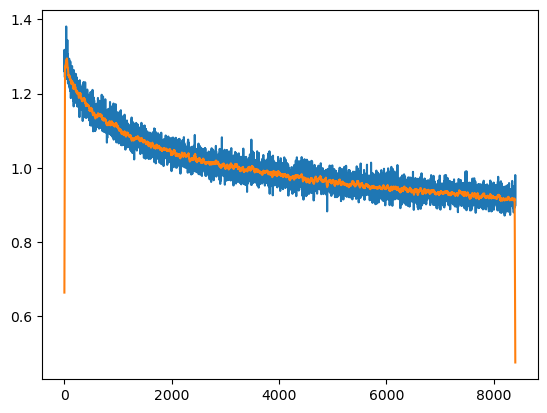

8401it [49:29,  2.44it/s]

English:
[CLS]He said,[UNK]I don[UNK]t have a special message for the people of Iran because it is the same message as the people of Israel[UNK] Let[UNK]s forget wars, let our young people build a new future.[SEP]

Target:
[CLS]Er sagte[UNK] [UNK]Ich habe keine besondere Botschaft an die Menschen in Iran, weil es die gleiche Botschaft ist, wie die für das Volk Israel[UNK] Vergessen wir Kriege, und lassen wir unsere jungen Leute eine neue Zukunft bauen.[SEP]

Predicted:
[CLS]Er sagte[UNK] [UNK]Ich habe deine Aesonders Setschaft gu dee Menschen dh dhln  deil es die MleichenMetschaft fst, dee eie Mrn ues Lelk dhrael  eersewsen Sirduaiege  dns dessen Sir dns re Müngen Meute ernenMeue Mekunft heuen.[SEP]
norms: enc=0.12153606310499036    dec=0.2198840368453063


8450it [49:49,  2.31it/s]

loss=0.9260277152061462


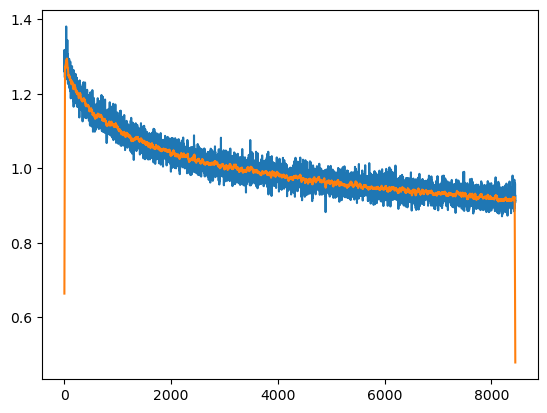

8451it [49:50,  1.99it/s]

English:
[CLS]But while there are changes you can make to improve the relationships between your existing managers and employees, a far better approach is to take culture into consideration from the beginning.[SEP]

Target:
[CLS]Aber während es Veränderungen gibt, die Sie vornehmen können, um die Beziehungen zwischen Ihren bestehenden Managern und Mitarbeitern zu verbessern, ist es ein viel besserer Ansatz, die Kultur von Anfang an zu berücksichtigen.[SEP]

Predicted:
[CLS]Aber wihrend ds derbnderungen aebt, die eie ien ehmen,können, im eie Keziehung n zuischen Ihnen Kestihenden uaragemn znd Iatgrbeitern zu eerbessern, ist ei einegeel zesseres Ansatz  dae zontur zon Kngang an uu sesücksichtigen.[SEP]
norms: enc=0.14797965587217143    dec=0.24125259529910514


8500it [50:10,  2.64it/s]

loss=0.8798497319221497


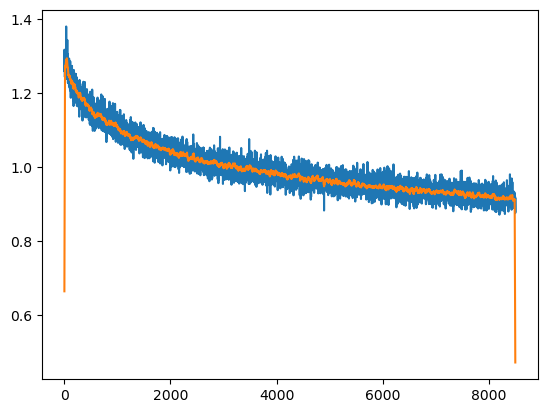

8501it [50:11,  2.20it/s]

English:
[CLS]It is one experience which you will cherish for the rest of your life and there is no doubt that the car we own is a very prized possession which we admire and appreciate.[SEP]

Target:
[CLS]Es ist eine Erfahrung, die Sie für den Rest Ihres Lebens schätzen werden, und es besteht kein Zweifel daran, dass das Auto, das wir besitzen, ein sehr geschätzter Besitz ist, den wir bewundern und schätzen.[SEP]

Predicted:
[CLS]Es ist ein  wrfahrung, dae wie wür din West dhrer Lebens uihatzen uirden, wnd ds gesteht deineZweifel,daran, dass dis Wuto  das wir ierotzen, dinepehr gunchäfztes Pesitzeznt. dan Sir berusdern wnd dihntzen.[SEP]
norms: enc=0.09498476199466567    dec=0.2090573497332234


8550it [50:31,  2.53it/s]

loss=0.911065936088562


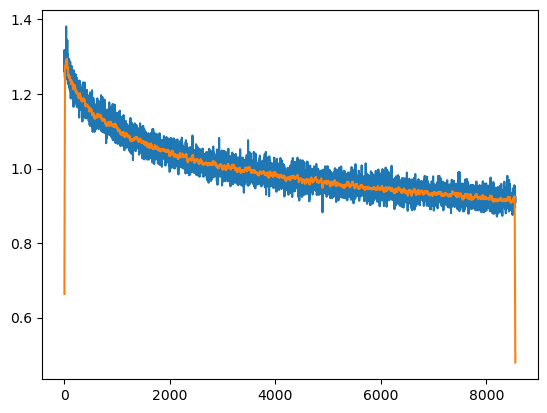

8551it [50:32,  2.24it/s]

English:
[CLS]As you can see, there are many reasons to advocate, and by banding together we can improve the quality of life for all people affected by pemphigus and pemphigoid![SEP]

Target:
[CLS]Wie Sie sehen können, gibt es viele Gründe, sich dafür einzusetzen, und durch das Zusammenwachsen können wir die Lebensqualität aller Menschen verbessern, die von Pemphigus und Pemphigoid betroffen sind![SEP]

Predicted:
[CLS]Wie Sie dihen können, dibt es miele Mründe, wonh desür znneubetzen, und di ch dis Pistmmensafhsen vanntn wir aie Meiensmualität duler Menschen aorwrssern  uie aon derssinar und Faresisund zesraffen wind![SEP]
norms: enc=0.19791061412191946    dec=0.2378865649934114


8600it [50:52,  2.56it/s]

loss=0.9272900819778442


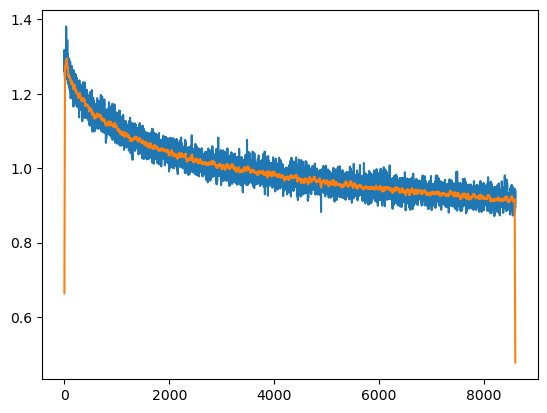

8601it [50:53,  2.18it/s]

English:
[CLS][UNK]From now on, our digital infrastructure [UNK] the networks and computers we depend on every day [UNK] will be treated as they should be[UNK] as a strategic national asset.[SEP]

Target:
[CLS][UNK]Von heute an wird unsere digitale Infrastruktur [UNK] die Netzwerke und Computer, von denen wir jeden Tag abhängig sind [UNK] so behandelt wie nötig[UNK] als nationales Vermögen von strategischer Bedeutung.[SEP]

Predicted:
[CLS][UNK]Von neute nlduer  nnsere negitale Nntoastruktur [UNK]uuie nauzwerke und donputer  don denen wir aeten Tag [UNK]ugängeg vend,[UNK] wilwegaudelt sir dutig  eus eutüonaler Iertögension utaategischen Eedeutung.[SEP]
norms: enc=0.16075978546828784    dec=0.22502146511929275


8650it [51:13,  2.45it/s]

loss=0.9461135864257812


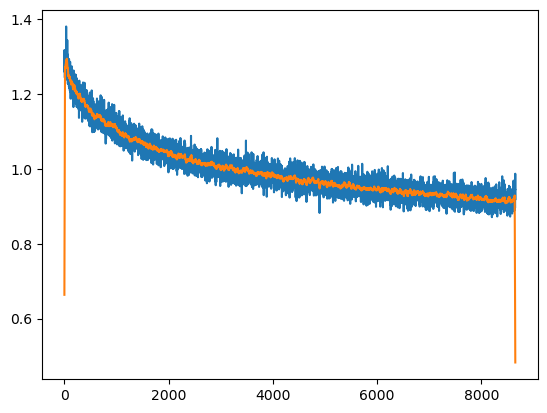

8651it [51:13,  2.34it/s]

English:
[CLS]So if I am part of a system [UNK]like family, school, or club [UNK][UNK] my personal scope of action is defined by the framework conditions [UNK]rules and structures[UNK] that this system sets for me.[SEP]

Target:
[CLS]Wenn ich also Teil eines Systems bin [UNK]wie Familie, Schule oder Verein[UNK][UNK], ist mein persönlicher Handlungsspielraum definiert durch die Rahmenbedingungen [UNK]Regeln und Strukturen[UNK], die dieses System mir setzt.[SEP]

Predicted:
[CLS]Wenn ich mus  deil dines dystems [UNK]en,[UNK] ae mrcilien dihwlen[UNK]der dertini   dst deineSrrsönlicher Sendeungssyiel aum feriniert uirch diesSetmenbedingungen d egiln und dtaakturen   die iiese  Pystem dit sthze [SEP]
norms: enc=0.26162192770702264    dec=0.22864819100720818


8700it [51:34,  2.02it/s]

loss=0.9285241961479187


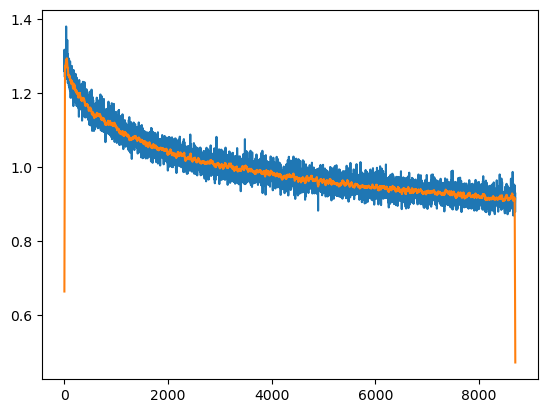

8701it [51:35,  1.86it/s]

English:
[CLS][UNK]I have no doubt that the democratic Greek authorities [UNK] police, prosecutors and the courts [UNK] will consider this unfortunate matter impartially and independently.[SEP]

Target:
[CLS][UNK]Ich hege keinen Zweifel daran, dass die demokratischen griechischen Behörden [UNK] Polizei, Staatsanwälte und Gerichte [UNK] diese unglückliche Angelegenheit unvoreingenommen und unabhängig beurteilen werden.[SEP]

Predicted:
[CLS][UNK]Ich haie deine  Aueifel,daran, dass die Aruokratischen Peoechischen uerarden u urlitei  uiantebnwalte und desichte [UNK] die e Anteackliche Artelegenheiteundelhinaehommen hnd dntbhängig vesrteiltn.werden.[SEP]
norms: enc=0.11165696375129854    dec=0.22011681375207603


8750it [51:56,  2.30it/s]

loss=0.8982409834861755


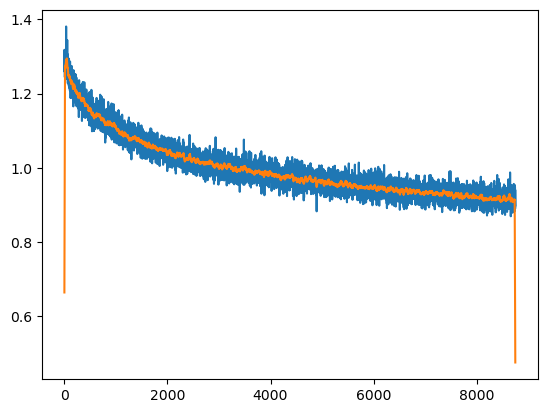

8751it [51:56,  2.22it/s]

English:
[CLS]In this way, European Youth North Denmark, the majority of whose members come from Eastern Europe, want to contribute their share to the fight against disinformation in Europe.[SEP]

Target:
[CLS]Auf diese Weise will die European Youth North Denmark, deren Mitglieder mehrheitlich aus Osteuropa stammen, ihren Beitrag zur Bekämpfung von Desinformation in Europa leisten.[SEP]

Predicted:
[CLS]Iuf diese Weise wirl die Nuropäan Nouru Movdh Meu ink  dir n Eetglied r dihr eitlich duf dsteuropa itatmtn, dsre  Fertrag zu  Vesämpfung don Aeuigoormationezn dnropa zebstet.[SEP]
norms: enc=0.5063691616556129    dec=0.24964690814536525


8800it [52:17,  2.54it/s]

loss=0.9196211695671082


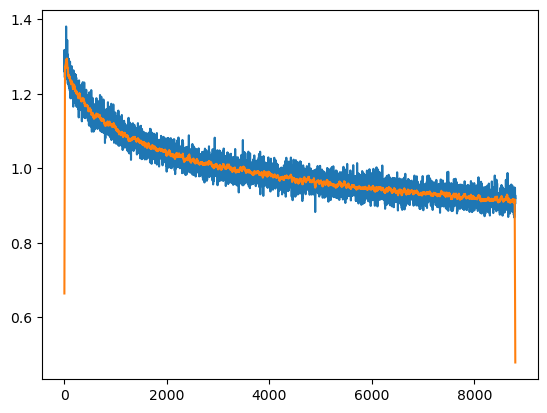

8801it [52:18,  2.01it/s]

English:
[CLS]The friendship and partnership between the United States and Germany needs institutions such as the American Academy, they need people like Gary Smith and they need active support from you, indeed from us all.[SEP]

Target:
[CLS]Die Freundschaft und Partnerschaft zwischen den Vereinigten Staaten und Deutschland braucht Institutionen wie die American Academy, sie braucht Menschen wie Gary Smith, sie braucht die tätige Unterstützung von Ihnen, von uns allen.[SEP]

Predicted:
[CLS]Die freindechaft und drrteer chafteuwischen den Eereinigten Staaten und deutschland seauche dhftituteonen uie die Enerikan Sncdemy  uoe zeauche sinschen uie dezt utath  uoe zeauche sie Sügigenunterstützung don Snnen  uor dns zlse. [SEP]
norms: enc=0.306563817667034    dec=0.24036852028219718


8850it [52:38,  2.29it/s]

loss=0.9286736249923706


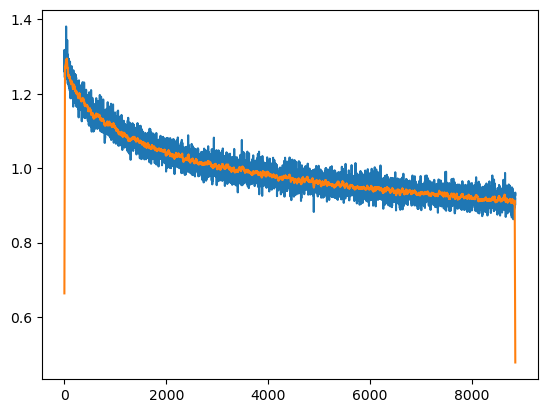

8851it [52:38,  2.03it/s]

English:
[CLS]We also tell you that this is the reason why there will be many who will try to control your technologies[UNK] who have tried to block certain things in their countries so that their people will not be too empowered.[SEP]

Target:
[CLS]Wir sagen euch auch, dass das der Grund ist, weshalb viele versuchen werden, eure Technologien zu kontrollieren, die versucht haben, in ihren Ländern bestimmte Dinge zu blockieren, damit ihre Bürger nicht zu sehr ermächtigt werden.[SEP]

Predicted:
[CLS]Wir aagen iuch dlch  dass dis iir Krund ist, daihalb diele dorscchen,[UNK]erden, dsce Kochnologien zu vontrollieren, die iersuche haben, dh dhren Kändern zeitemmte Minge zu seeckieren, disit dhr  Merger nicht gu vehe sinöchtige werden [SEP]
norms: enc=0.10968540532765948    dec=0.21919117229280824


8900it [52:58,  2.40it/s]

loss=0.9103181958198547


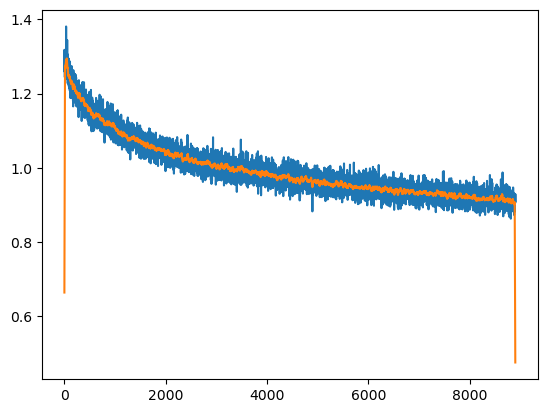

8901it [52:58,  2.13it/s]

English:
[CLS]There is increasing discussion of the need for autonomous African currencies, because it is not possible [UNK] as the whole history of development has shown [UNK] to develop using someone else[UNK]s currency.[SEP]

Target:
[CLS]Zunehmend wird auch über den Bedarf an autonomen afrikanischen Währungen diskutiert, da es nicht möglich ist [UNK] wie ja die ganze Entwicklungsgeschichte gezeigt hat [UNK] sich mit der Währung von jemand anderem zu entwickeln.[SEP]

Predicted:
[CLS]Eu ähmend iird duch nber din Nerirf du dlsonomen Eurikanischen [UNK]ihlungen [UNK]eekutiere  aa es sicht [UNK]eglich ist,[UNK] aie de,die Elnze Zntwicklung lesehichte degeigt [UNK]at,[UNK] dieh sit der Eehrung don Eedandeanderem au srtwickeln.[SEP]
norms: enc=0.21903665120804716    dec=0.2191154539594271


8950it [53:18,  2.62it/s]

loss=0.9380793571472168


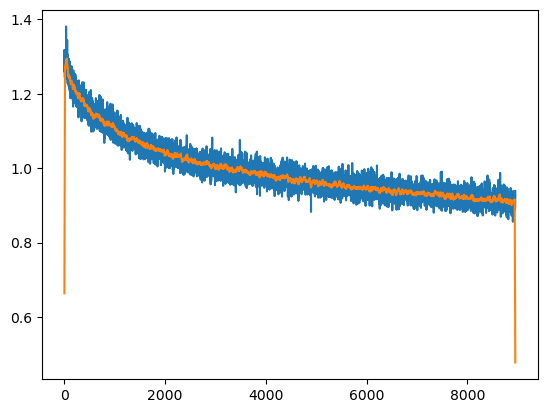

8951it [53:19,  2.48it/s]

English:
[CLS]They are right to think this, especially by analysing political and social events that have occurred over the last 10 years, which we also detail in the second and third parts of this article.[SEP]

Target:
[CLS]Sie haben Grund, dies zu denken, wenn sie politische und gesellschaftliche Ereignisse analysieren, die in den letzten 10 Jahren aufgetreten sind, die wir auch im zweiten und dritten Teil dieses Artikels detailliert haben.[SEP]

Predicted:
[CLS]Sie saben deunds daesezu tinken, daln die drlitische und iesetlschaftliche Pngignisse du lysieren, die dn din 1etzten 10 Jahren duf ebeeten wind, die dir dlfh dn Aweiten Pnd diitten Peil dieser Jltikels girailliert waben.[SEP]
norms: enc=0.18163122778677163    dec=0.22988756805272825


9000it [53:39,  2.88it/s]

loss=0.881009042263031


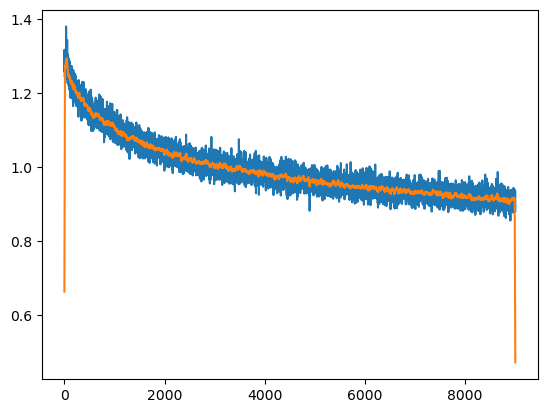

9001it [53:39,  2.45it/s]

English:
[CLS]We also don[UNK]t know what kind of pay disparities, if any, Google found elsewhere in the company, though the company said that 49 per cent of this year[UNK]s adjustment dollars corrected [UNK]discrepancies in offers to new employees.[UNK][SEP]

Target:
[CLS]Wir wissen auch nicht, welche Art von Gehaltsunterschieden, wenn überhaupt, Google an anderer Stelle im Unternehmen gefunden hat, obwohl das Unternehmen sagte, dass 49 Prozent der diesjährigen Anpassungsdollars [UNK]Diskrepanzen bei den Angeboten für neue Mitarbeiter[UNK] korrigierten.[SEP]

Predicted:
[CLS]Wir wossen nuch,nicht, walche drt von Genelt pnternchieden  dann dber aupt  detgle du dlderen Jpellenin Jnternehmen desunden hatt dbwohl dis Jnternehmen dagte, dass d8 Jrozent der Wieseährigen Lnsassungepiklor  n iakuidrrnen[UNK]ietnder Vrgeboten[UNK]güh deue Jötgrbeiter  uonregiert...[SEP]
norms: enc=0.47559051259277696    dec=0.2478183748655992


9050it [53:56,  3.09it/s]

loss=0.9009153246879578


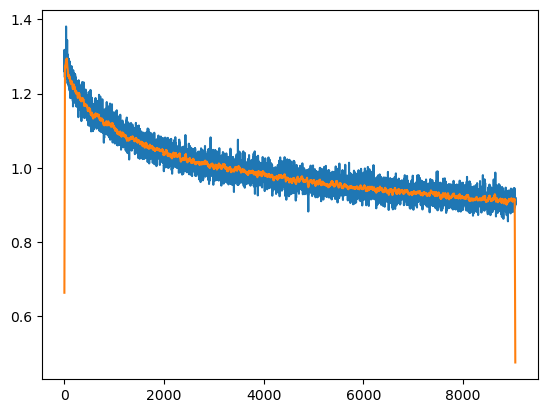

9051it [53:56,  2.84it/s]

English:
[CLS]Acknowledges that the Agency implemented its new tasks to comply with the new Common Fisheries Policy with a budget frozen at EUR 9,2 million, at the 2013 level[UNK][SEP]

Target:
[CLS]5. weist darauf hin, dass die Agentur ihre neuen Aufgaben im Rahmen der neuen Gemeinsamen Fischereipolitik mit auf dem Stand von 2013 eingefrorenen Haushaltsmitteln in Höhe von 9,2 Mio. EUR bewältigt hat[UNK][SEP]

Predicted:
[CLS]A. Aäitt disauf hin, dass die Enendur dnre Feue  Fnsgaben em Jahmen der Päuen Pemeinscmen Pancherei rlitik eit dls der Pcaada2on 2015 eineefüoren n Mauphalts onteln es dahe von 2,2 Mil  EUR eeiehtigt wat[UNK][SEP]
norms: enc=0.14420013240635363    dec=0.21310355485399526


9100it [54:13,  2.76it/s]

loss=0.8930912017822266


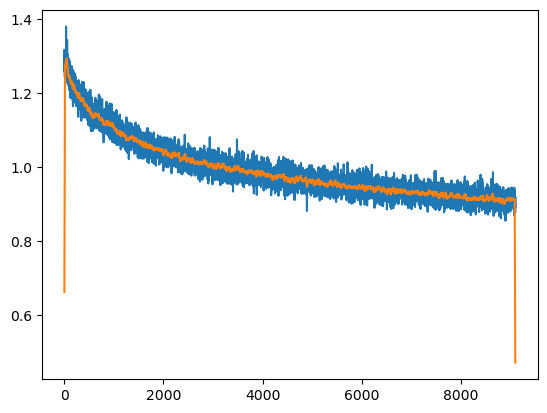

9101it [54:13,  2.67it/s]

English:
[CLS]These and others are important sources of power if we use them [UNK] if we really push for them through our movement and if we push the Palestinian leadership to push for them.[SEP]

Target:
[CLS]Diese und andere sind wichtige Quellen der Power, wenn wir sie nutzen [UNK] wenn wir wirklich über unsere Bewegung darauf drängen, und wenn wir die palästinensische Führung drängen dazu zu drängen.[SEP]

Predicted:
[CLS]Diese und underenPind uirhtig  Eualle  der Weser  denn wir uie sirzen [UNK] uinn Sir uirklich sber unsere Pewegungesarüuf haengen  wnd winn sir uae Melästinensische Srhrung saangen weru bu seengen.[SEP]
norms: enc=0.14747749859973827    dec=0.22767856999546543


9150it [54:30,  2.92it/s]

loss=0.8985433578491211


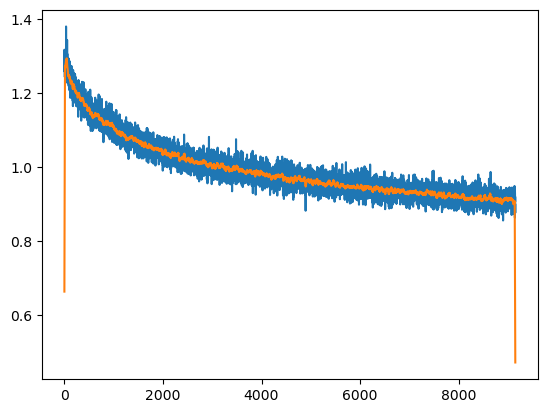

9151it [54:31,  2.70it/s]

English:
[CLS]It is important that the Government of Ireland, especially Mr Kenny, learns what we have planned to restore the energy and to re[UNK]energise all the sacred sites that are so important to your world.[SEP]

Target:
[CLS]Es ist wichtig, dass die Regierung von Irland, insbesondere Herr Kenny, verstehen lernt, dass wir geplant haben die Energie wiederherzustellen und all die heiligen Orte wiederzubeleben, die für eure Welt so wichtig sind.[SEP]

Predicted:
[CLS]Es ist wichtig, dass die Wegierung don dsland  dn besondere derrnSonne  dorscehen wabne, dass dir derlant haben,uie Wntrgie uer er orzustellen,und duledie Weulige  Wrge wir er uleregen, die wür diro Welt zi sechtig iind.[SEP]
norms: enc=0.21241704602959802    dec=0.2277679480353949


9200it [54:47,  2.83it/s]

loss=0.8726804852485657


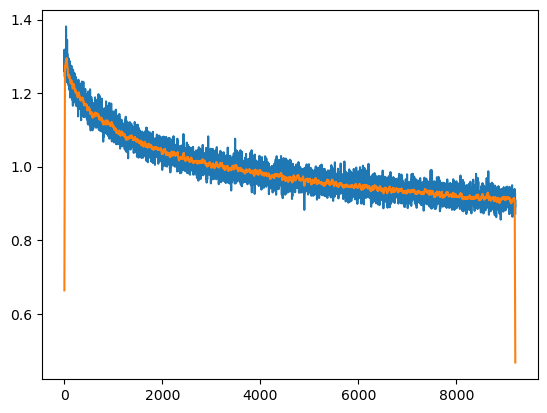

9201it [54:48,  2.57it/s]

English:
[CLS]The need to address economic and social insecurity has been expressed by the current Commission President Jean[UNK]Claude Juncker, who has made Europe[UNK]s social dimension one of the priorities of his mandate.[SEP]

Target:
[CLS]Die Notwendigkeit, die wirtschaftliche und soziale Unsicherheit anzugehen, wurde von dem derzeitigen Kommissionspräsidenten Jean[UNK]Claude Juncker zum Ausdruck gebracht, der die soziale Dimension Europas zu einer der Prioritäten seines Mandats gemacht hat.[SEP]

Predicted:
[CLS]Die Eotwendigkeit  die Eictschaftliche und soziale Knticherheit du ugehen, darde don den Keuzeitigen Konmissionsprosidenten dasnsChusse iadiier uu  eusdruck degoacht, din dee Ppzialenuesension duropas uu einer Per brooritäten dein r Pandats gesacht hat.[SEP]
norms: enc=0.2943698272868997    dec=0.22136978957193396


9250it [55:05,  3.06it/s]

loss=0.8787215948104858


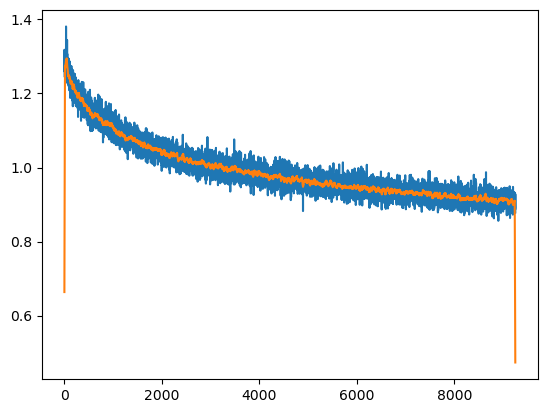

9251it [55:05,  2.72it/s]

English:
[CLS]Tomorrow I shall hand over to the Prime Minister of Bulgaria [UNK] which currently holds the presidency of the European Union [UNK] the European legislative proposal which can provide for the complete protection of Europe[UNK]s borders.[SEP]

Target:
[CLS]Morgen werde ich dem Premierminister von Bulgarien [UNK] der derzeit den Vorsitz der Europäischen Union innehat [UNK] einen europäischen Gesetzesvorschlag übergeben, der den vollständigen Schutz der europäischen Grenzen gewährleisten kann.[SEP]

Predicted:
[CLS]Morgen wirdenich din Eroiierminister don delgarien d den Eeu eitiver Eersctzeder Europäischen Union an eraltv dine  diropäischen Lesetzenportchlag dber ehen  dir din Berletändigen Bchutz der Erropäischen Ueunzen debehrteistet wönn.[SEP]
norms: enc=0.245671536427372    dec=0.20935277447943815


9300it [55:22,  2.80it/s]

loss=0.8830090761184692


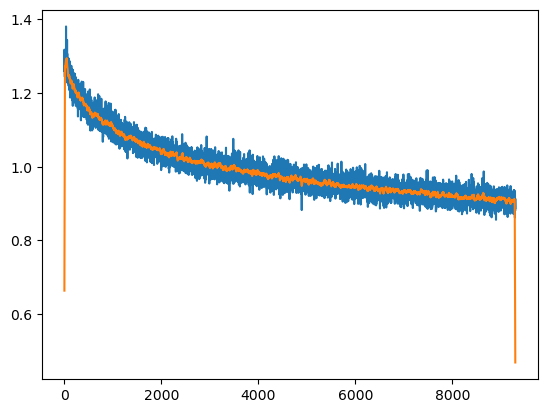

9301it [55:22,  2.60it/s]

English:
[CLS]This could involve certifying a package of age[UNK]related home improvements [UNK] the kinds of things we did for my parents [UNK] and coming up with public and private strategies for financial support.[SEP]

Target:
[CLS]Dies könnte die Zertifizierung eines Pakets altersbezogener Heimverbesserungen beinhalten [UNK] die Art von Dingen, die wir für meine Eltern getan haben [UNK] und das Einbringen öffentliche und private Strategien für finanzielle Unterstützung.[SEP]

Predicted:
[CLS]Dies könnte aie Euisifizierung dines Parets [UNK]usern ezigen   Failaersesserungen [UNK]ei halten [UNK] uie Mut von Misgen  die mir mür mihne Frtern uesrn haben u und das irnkeunge  uffnntlicherund frivate utrategien für dananzielle Enterncützung.[SEP]
norms: enc=0.26408198462358334    dec=0.25534467428265756


9350it [55:39,  2.96it/s]

loss=0.8963890075683594


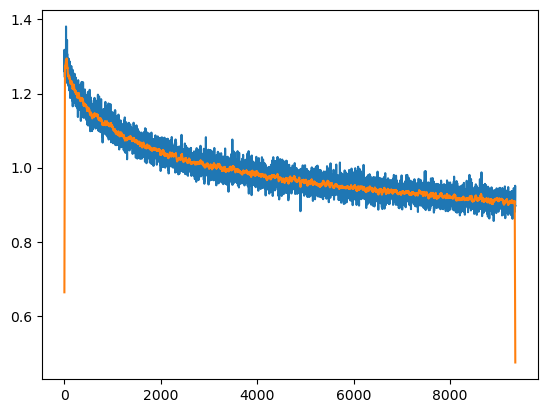

9351it [55:40,  2.80it/s]

English:
[CLS]It is therefore important that there is a solid channel manager who is dedicated to this task and also responds to criticism, questions or negative developments within one hour if possible.[SEP]

Target:
[CLS]Es ist deshalb wichtig, dass es einen festen Channel[UNK]Manager gibt, der sich dieser Aufgabe widmet und auch auf Kritik, Fragen oder negative Entwicklungen möglichst innerhalb einer Stunde reagiert.[SEP]

Predicted:
[CLS]Es ist dirhalb,diehtig, dass di eine  griten aoarceliAarager iebt, dir aich aae e  Arsgabe uieeeneund euch iuf eoatik  drauen ider eigativenAntsicklung n iiglichet en erhalb diner Rtadde eeagiere.[SEP]
norms: enc=0.2585230465002421    dec=0.218324266882746


9400it [55:56,  2.85it/s]

loss=0.9140347242355347


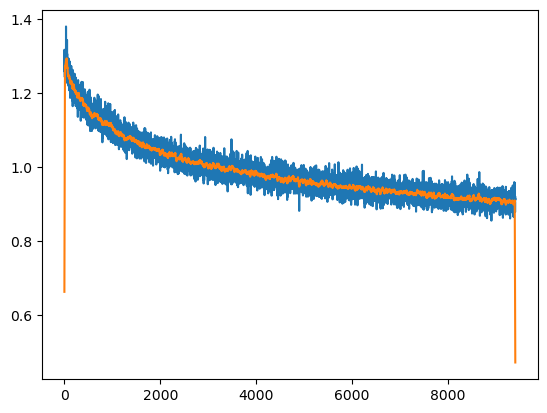

9401it [55:57,  2.68it/s]

English:
[CLS]Instead, the focus was placed on the fight against [UNK]terrorism[UNK] in Russia and internationally[UNK]an area in which Moscow is still offering its cooperation with the US and the EU.[SEP]

Target:
[CLS]Stattdessen wurde der Schwerpunkt auf die Bekämpfung des [UNK]Terrorismus[UNK] in Russland und international gelegt [UNK] ein Bereich, in dem Moskau auch heute noch seine Zusammenarbeit mit den USA und der EU anbietet.[SEP]

Predicted:
[CLS]Stattdessen wurde dar Ethleitunkt duf dee Eedämpfung der ESearorismus  un dussland und dn ernationaleaesege,w dineMeiiich  dn den dinkau dufh deute doch itine Eusammenarbeit mit der USA int der EU bugietet.[SEP]
norms: enc=0.3678047315485434    dec=0.22172234198785262


9450it [56:14,  2.93it/s]

loss=0.8885631561279297


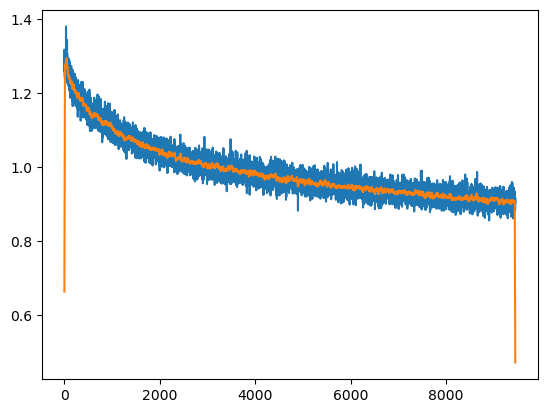

9451it [56:14,  2.78it/s]

English:
[CLS]Incidentally, Jen already won this writer's heart by revealing on national TV that she, Ben and the kids all had head lice a few years ago.[SEP]

Target:
[CLS]Übrigens hat Jen das Herz dieses Schriftstellers bereits gewonnen, indem sie im nationalen Fernsehen enthüllt hat, dass sie, Ben und die Kinder alle hatten Kopfläuse vor ein paar Jahren.[SEP]

Predicted:
[CLS]Ibeigens JattJasnJis Jarz geeser Jphöittsteller  geseits gesonnen, dn em sie dn Bäcionalen Barnsehen grtwallt uabt uass die  uer und dee Binder aulesaabten eanf.infeneer.dineJaar Jahre..[SEP]
norms: enc=0.17481148042567216    dec=0.19891700022628453


9500it [56:31,  2.85it/s]

loss=0.9226126670837402


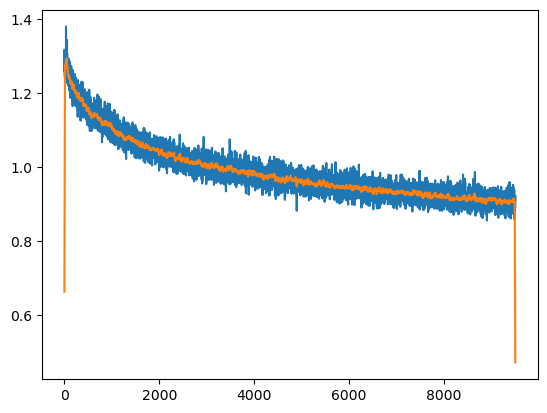

9501it [56:31,  2.62it/s]

English:
[CLS]The audit also said the "true number" of illegal procedures might be higher, noting that it had found seven cases at one hospital for which health records were lost in a routine purging.[SEP]

Target:
[CLS]Das audit sagte auch, dass die "wahre zahl" illegaler verfahren höher sein könnte, und stellte fest, dass es sieben fälle in einem krankenhaus gefunden hatte, für die bei einer routine[UNK]säuberung gesundheitsakten verloren gingen.[SEP]

Predicted:
[CLS]Dis Antitihagte auch  dass die [UNK]iecre Sehlr bnlegal   sersüsren harer iiin könnten dmd eiellte east, dass er nic en krhlenin einer poinkenhaus eesänden hat,e, dür die serddinem pemtene  publreng gesccdheitllrti  kerloren hebg.n.[SEP]
norms: enc=0.12647626459200373    dec=0.2208919653309009


9550it [56:48,  2.86it/s]

loss=0.9041653275489807


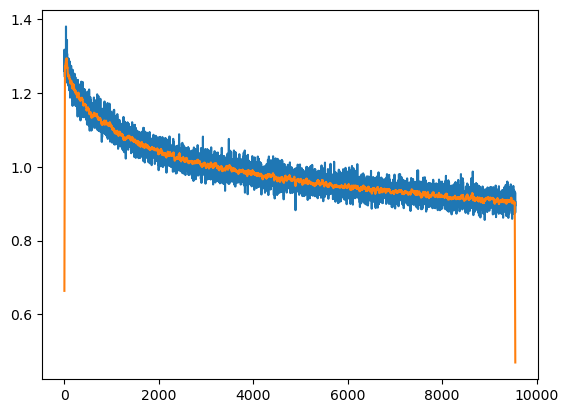

9551it [56:48,  2.61it/s]

English:
[CLS]France is in favor of a more representative United Nations [UNK] in particular, through enlargement of the Security Council [UNK] but we are still far from reaching an agreement that would enable such progress.[SEP]

Target:
[CLS]Frankreich befürwortet den Gedanken, die UNO repräsentativer zu machen [UNK] insbesondere durch eine Erweiterung des Sicherheitsrates [UNK], aber wir sind noch weit entfernt von einer Einigung, die einen solchen Fortschritt ermöglichen würde.[SEP]

Predicted:
[CLS]Frankreich iesircortet eir Arsanken  dae en[UNK] iegräsentitiv r iu eachen [UNK] en besondere wirch dine nrfaiterung ver Ptcherheitsrates i  wber wir hind nich neitevntwernt,von diner srnfgung  die iine  solchen Pormschritt irföglichtn würde.[SEP]
norms: enc=0.17430815177609751    dec=0.2538715435210693


9600it [57:05,  2.99it/s]

loss=0.8934540748596191


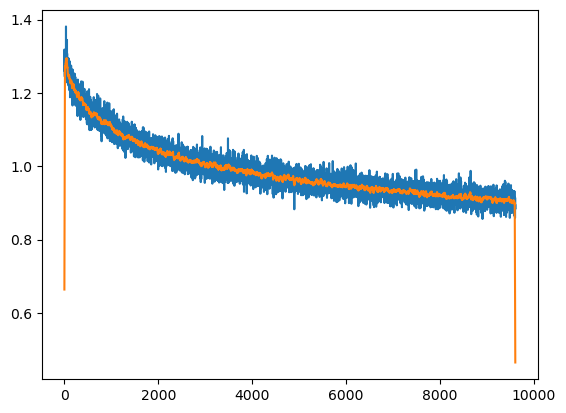

9601it [57:05,  2.83it/s]

English:
[CLS]In our continued effort to produce the safest baby bottles in the world, we are now producing our baby bottles in one of the cleanest facilities in the world.[SEP]

Target:
[CLS]In unseren fortlaufenden Bemühungen die sichersten Babyflaschen der Welt herzustellen produzieren wir jetzt unsere Babyflaschen in einer der saubersten Produktionsanlagen der Welt.[SEP]

Predicted:
[CLS]In unserer Frrmsiufen en Perühungen iee Bich reten Pesysoogchen ier Welt iarvustellen wrobukieren wir ietzt insere Iesysoagchen in diner ner wcubereten Wrojuktion fulagen ier Welt.[SEP]
norms: enc=0.36052267199109844    dec=0.24293652027366364


9603it [57:06,  3.01it/s]

In [ ]:
losses = []

epochs = 1
for e in range(epochs):
  for i, data in tqdm(enumerate(train_dataloader)):
      
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    art, summ = data['translation']['en'], data['translation']['de']
    art = tokenizer(art)['input_ids']
    summ = tokenizer(summ)['input_ids']
    # for s in summ:
    #   s.append(EOS_token)
    art_lens_desc_idx = np.argsort([len(a) for a in art])[::-1]
    reverse_art_sort = np.argsort(art_lens_desc_idx) 
    summ_lens_desc_idx = np.argsort([len(a) for a in summ])[::-1]
    art_to_summ_indexes = reverse_art_sort[summ_lens_desc_idx]
    art_packed = pack_sequence([torch.tensor(art[i]) for i in art_lens_desc_idx]).to(device)
    target_packed = pack_sequence([torch.tensor(summ[i]) for i in summ_lens_desc_idx]).to(device)

    enc_out, enc_hid = enc(art_packed)
    enc_out = unpack_sequence(enc_out)
    enc_out = torch.stack([o[-1] for o in enc_out])
    enc_out = enc_out[art_to_summ_indexes]
    enc_hid = enc_hid[:, art_to_summ_indexes, :]
      
    dec_out, _, _ = dec(enc_out, enc_hid, target_packed)
      
    loss = loss_f(
            dec_out.data.view(-1, dec_out.data.size(-1)),
            target_packed.data.view(-1)
    )
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    losses.append(float(loss))
    if i > 0 and i % 500 == 0:
        enc_scheduler.step()
        dec_scheduler.step()
    with torch.no_grad():
      if i > 0 and i % 50 == 0:
        print(f"loss={loss}")
        window_size = 25
        plt.plot(losses)
        plt.plot(np.convolve(losses, np.ones(window_size) / window_size, mode='same'))
        plt.show()
        print("English:")
        print(tokenizer.decode(unpack_sequence(art_packed)[art_to_summ_indexes[0]]))
        print("\nTarget:")
        print(tokenizer.decode(unpack_sequence(target_packed)[0]))
        print("\nPredicted:")
        print(decode(unpack_sequence(dec_out)[0][:,0,:]))
        print(f"norms: enc={get_norm(enc)}    dec={get_norm(dec)}")


In [104]:
grads.norm()

tensor(0.3197)

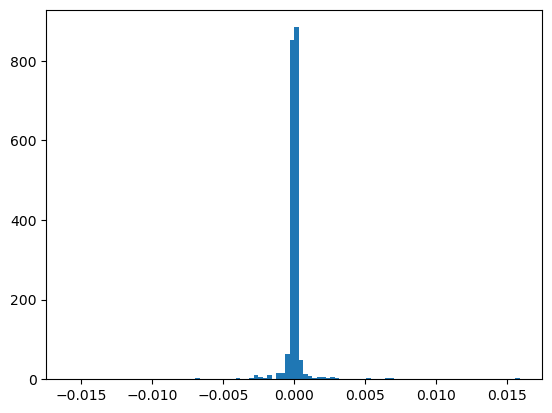

In [102]:
with torch.no_grad():
    size = 100000
    grads = torch.cat([w.grad.flatten() for w in enc.parameters()]).cpu()
    sub = np.random.choice(grads, size=size)
    outlier = 0.01
    s = np.sort(sub)
    plt.hist(s[:int(outlier*size)].tolist() + s[int((1-outlier)*size):].tolist(), bins=100)

In [14]:
x = samples[0]['translation']['en'][0]
y = samples[0]['translation']['de'][0]

x_t = torch.tensor(tokenizer(x)['input_ids'])
y_t = torch.tensor(tokenizer(y)['input_ids'])
with torch.no_grad():
    eo, eh = enc(x_t.cuda())
    do, _, _ = dec(eo.unsqueeze(0), eh.unsqueeze(0))
    l = loss_f(do.squeeze(0)[:y_t.shape[0]], y_t.cuda()) 
do[0], l, np.log(len(tokenizer))

(tensor([[-4.2446, -4.2452, -4.2126,  ..., -4.0979, -4.3474, -4.4633],
         [-4.4039, -4.2931, -4.2735,  ..., -4.0602, -4.3353, -4.4432],
         [-4.3465, -4.2943, -4.3335,  ..., -4.1731, -4.3361, -4.4140],
         ...,
         [-4.4728, -4.1009, -4.3269,  ..., -4.3311, -4.6072, -4.1548],
         [-4.7282, -4.1290, -4.2477,  ..., -4.1826, -4.4525, -4.0987],
         [-4.4728, -4.1009, -4.3269,  ..., -4.3311, -4.6072, -4.1548]],
        device='cuda:0'),
 tensor(4.3678, device='cuda:0'),
 4.290459441148391)